In [2]:
from pathlib import Path
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import lit,to_timestamp, coalesce, col, date_format, when
from functools import reduce
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dtale
import numpy as np
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pmdarima as pm

from scipy.stats import zscore

import pmdarima as pm
from scipy.stats import zscore


spark = SparkSession.builder.getOrCreate()

In [3]:
from pathlib import Path

# Define la ruta base
base_path = Path("/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS")

# Lista 1: Archivos .csv que contienen "AQ_SEP" en su nombre
lista_aq_sep = [archivo for archivo in base_path.rglob("*.csv") if "AQ_SEP" in archivo.name]

# Lista 2: Archivos .csv que contienen "AirQualityUnit01" en su nombre
lista_airqualityunit01 = [archivo for archivo in base_path.rglob("*.csv") if "AirQualityUnit01" in archivo.name]

# Lista 3: Archivos .csv que contienen "AirQualityUnit02" en su nombre
lista_airqualityunit02 = [archivo for archivo in base_path.rglob("*.csv") if "AirQualityUnit02" in archivo.name]


In [4]:
# Imprimir las listas archivos AQ_SEP
print("Archivos con 'AQ_SEP':")
for archivo in lista_aq_sep:
    print(archivo)

Archivos con 'AQ_SEP':
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Abril 2024/6etmrenvironmentobserved - AQ_SEP-data-2024-04-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Junio 2024/6etmrenvironmentobserved - AQ_SEP, activa desde el 1ero de mayo-data-2024-06-14.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Agosto 2024/6etmrenvironmentobserved - AQ_SEP, activa desde el 1ero de mayo-data-2024-08-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Febrero 2024/6etmrenvironmentobserved - AQ_SEP-data-2024-02-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Diciembre 2023/6etmrenvironmentobserved - AQ_SEP-data-2023-12-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Marzo 2024/6etmrenvironmentobserved - AQ_SEP-data-2024-03-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Noviembre 2023/6etmrenvironmentobserved - AQ_SEP-data-2023-11-15.

In [7]:
# Imprimir las listas archivos AirQualityUnit01
print("\nArchivos con 'AirQualityUnit01':")
for archivo in lista_airqualityunit01:
    print(archivo)


Archivos con 'AirQualityUnit01':
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Abril 2024/7etmrairqualityobserved - AirQualityUnit01-data-2024-04-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Junio 2024/7etmrairqualityobserved - AirQualityUnit01-data-2024-06-14.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Julio 2024/7etmrairqualityobserved - AirQualityUnit01-data-2024-07-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Agosto 2024/7etmrairqualityobserved - AirQualityUnit01-data-2024-08-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Febrero 2024/7etmrairqualityobserved - AirQualityUnit01-data-2024-02-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Diciembre 2023/7etmrairqualityobserved - AirQualityUnit01-data-2023-12-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Marzo 2024/7etmrairqualityobserved - AirQualityUnit01-data-2

In [8]:
# Imprimir las listas archivos AirQualityUnit02
print("\nArchivos con 'AirQualityUnit02':")
for archivo in lista_airqualityunit02:
    print(archivo)


Archivos con 'AirQualityUnit02':
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Abril 2024/8etmrairqualityobserved - AirQualityUnit02-data-2024-04-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Junio 2024/8etmrairqualityobserved - AirQualityUnit02-data-2024-06-14.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Agosto 2024/8etmrairqualityobserved - AirQualityUnit02-data-2024-08-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Febrero 2024/8etmrairqualityobserved - AirQualityUnit02-data-2024-02-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Diciembre 2023/8etmrairqualityobserved - AirQualityUnit02-data-2023-12-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Marzo 2024/8etmrairqualityobserved - AirQualityUnit02-data-2024-03-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Noviembre 2023/8etmrairqualityobserved - AirQualityUnit02-da

In [9]:
def detect_separator_simple(file_path, sample_size=1024):
    """
    Detecta el separador de un archivo CSV leyendo una muestra del archivo.

    Args:
        file_path (str): Ruta del archivo CSV.
        sample_size (int, optional): Número de bytes a leer para el análisis. Por defecto es 1024.

    Returns:
        str: El caracter delimitador detectado o None si no se pudo detectar.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            sample = f.read(sample_size)
        dialect = csv.Sniffer().sniff(sample)
        return dialect.delimiter
    except Exception as e:
        print(f"Error al detectar el separador: {e}")
        return None


In [10]:
def load_csv_correctly(path):
    # Leer el archivo como texto
    raw_df = spark.read.text(path)
    # Obtener la primera línea
    first_line = raw_df.first()[0]
    separator = detect_separator_simple(path)
    
    if first_line and isinstance(first_line, str) and first_line.startswith("sep="):
        # Omitir la primera línea usando zipWithIndex para mantener el orden
        lines_rdd = raw_df.rdd.zipWithIndex() \
                        .filter(lambda row_index: row_index[1] > 0) \
                        .map(lambda row_index: row_index[0][0])
        
        # Leer el CSV a partir del RDD de líneas
        df = spark.read.option("header", "true") \
                       .option("inferSchema", "true") \
                       .option("escape", '"') \
                       .option("quote", '"') \
                       .option("sep", separator) \
                       .csv(lines_rdd)
    else:
        # Leer el CSV normalmente desde la ruta
        df = spark.read.option("header", "true") \
                       .option("inferSchema", "true") \
                       .option("escape", '"') \
                       .option("quote", '"') \
                       .option("sep", separator) \
                       .csv(path)
    
    return df


In [11]:
DF_LIST_AQ_SEP = [load_csv_correctly(str(path)) for path in lista_aq_sep]
DF_LIST_AQ_01 = [load_csv_correctly(str(path)) for path in lista_airqualityunit01]
DF_LIST_AQ_02 = [load_csv_correctly(str(path)) for path in lista_airqualityunit02]

In [12]:
DF_LIST_AQ_SEP[1].show()

+-------------------+---------+---------------+---------+----------+-----------+------------+---------------+------------------+
|               Time|co AQ_SEP|humidity AQ_SEP|o3 AQ_SEP|pm1 AQ_SEP|pm10 AQ_SEP|pm2_5 AQ_SEP|pressure AQ_SEP|temperature AQ_SEP|
+-------------------+---------+---------------+---------+----------+-----------+------------+---------------+------------------+
|2024-05-15 00:02:05|     10.1|           94.1|       -1|       0.2|        0.9|         0.8|          75332|              13.6|
|2024-05-15 00:17:05|      9.0|           95.3|       -1|       0.3|        0.4|         0.4|          75316|              13.6|
|2024-05-15 00:32:05|      9.7|           95.3|       -1|       0.3|        1.0|         0.9|          75297|              13.5|
|2024-05-15 00:47:06|      8.6|           95.0|       -1|       0.2|        0.2|         0.2|          75287|              13.5|
|2024-05-15 01:02:07|      7.5|           96.3|       -1|       0.1|        0.2|         0.2|    

In [13]:
DF_LIST_AQ_01[0].show()

+----------------+----------------+----+----+----+-----+------+----+-----------------+----+------------+
|            Time|       entity_id| co |co2 | o3 |pm10 |pm2_5 |pm5 |relativehumidity |so2 |temperature |
+----------------+----------------+----+----+----+-----+------+----+-----------------+----+------------+
|19/03/2024 22:08|AirQualityUnit01|-999|-999|-999| -999|  -999|-999|           -999.0|-999|      -998.0|
| 01/04/2024 9:33|AirQualityUnit01|-999|-999|-999| -999|  -999|-999|           -999.0|-999|      -999.0|
|08/04/2024 18:39|AirQualityUnit01|   2|1008|-999|   58|    44|  29|             60.3|-999|        20.3|
|08/04/2024 18:41|AirQualityUnit01|   3|1028|-999|   56|    46|  30|             60.3|-999|        20.3|
|08/04/2024 18:43|AirQualityUnit01|   4|1053|-999|   56|    46|  30|             60.3|-999|        20.3|
|08/04/2024 18:45|AirQualityUnit01|   5|1090|-999|   61|    46|  28|             60.4|-999|        20.3|
|08/04/2024 18:48|AirQualityUnit01|   6|1155|-999|   61

In [14]:
# Función para limpiar los nombres de columnas
def clean_column_names(df):
    new_columns = [col.strip().replace(" ", "_").lower() for col in df.columns]
    return df.toDF(*new_columns) 

In [15]:
DF_LIST_AQ_SEP = [clean_column_names(df) for df in DF_LIST_AQ_SEP]
DF_LIST_AQ_01 = [clean_column_names(df) for df in DF_LIST_AQ_01]
DF_LIST_AQ_02 = [clean_column_names(df) for df in DF_LIST_AQ_02]

In [16]:
for i, df in enumerate(DF_LIST_AQ_SEP):
    print(f"DataFrame DF_LIST_AQ_SEP {i} columns: {df.columns}")


DataFrame DF_LIST_AQ_SEP 0 columns: ['time', 'co_aq_sep', 'no2_aq_sep', 'o3_aq_sep', 'pm1_aq_sep', 'pm10_aq_sep', 'pm2_5_aq_sep', 'pressure_aq_sep', 'relativehumidity_aq_sep', 'temperature_aq_sep']
DataFrame DF_LIST_AQ_SEP 1 columns: ['time', 'co_aq_sep', 'humidity_aq_sep', 'o3_aq_sep', 'pm1_aq_sep', 'pm10_aq_sep', 'pm2_5_aq_sep', 'pressure_aq_sep', 'temperature_aq_sep']
DataFrame DF_LIST_AQ_SEP 2 columns: ['time', 'co_aq_sep', 'humidity_aq_sep', 'o3_aq_sep', 'pm1_aq_sep', 'pm10_aq_sep', 'pm2_5_aq_sep', 'pressure_aq_sep', 'temperature_aq_sep']
DataFrame DF_LIST_AQ_SEP 3 columns: ['time', 'co_aq_sep', 'no2_aq_sep', 'o3_aq_sep', 'pm1_aq_sep', 'pm10_aq_sep', 'pm2_5_aq_sep', 'pressure_aq_sep', 'relativehumidity_aq_sep', 'temperature_aq_sep']
DataFrame DF_LIST_AQ_SEP 4 columns: ['time', 'co_aq_sep', 'no2_aq_sep', 'o3_aq_sep', 'pm1_aq_sep', 'pm10_aq_sep', 'pm2_5_aq_sep', 'pressure_aq_sep', 'relativehumidity_aq_sep', 'temperature_aq_sep']
DataFrame DF_LIST_AQ_SEP 5 columns: ['time', 'co_aq_se

In [17]:
for i, df in enumerate(DF_LIST_AQ_01):
    print(f"DataFrame DF_LIST_AQ_01 {i} columns: {df.columns}")


DataFrame DF_LIST_AQ_01 0 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_01 1 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_01 2 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_01 3 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_01 4 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_01 5 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_01 6 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFr

In [18]:
for i, df in enumerate(DF_LIST_AQ_02):
    print(f"DataFrame DF_LIST_AQ_02 {i} columns: {df.columns}")


DataFrame DF_LIST_AQ_02 0 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_02 1 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_02 2 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_02 3 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_02 4 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_02 5 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_02 6 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFr

In [19]:
def standardize_df(df):
    # Lista de columnas deseadas en el orden y con los nombres estándar
    desired_order = ["time", "pm2_5", "pm10", "co", "o3", "humidity", "temperature"]
    new_columns = []
    
    # Para cada columna deseada, buscar en el DataFrame original la primera columna que contenga la palabra clave
    for keyword in desired_order:
        # Buscar candidates: columnas cuyo nombre (en minúscula) contenga la palabra clave
        candidates = [col for col in df.columns if keyword in col.lower()]
        if candidates:
            # Si existen varias, se toma la primera (podrías ajustar esto si necesitas otro criterio)
            new_columns.append(F.col(candidates[0]).alias(keyword))
        else:
            # Si no existe la columna, se agrega una columna con valores nulos
            new_columns.append(F.lit(None).alias(keyword))
    
    # Seleccionar y devolver el nuevo DataFrame con las columnas en el orden deseado
    return df.select(*new_columns)

In [20]:
DF_LIST_AQ_SEP_S = [standardize_df(df) for df in DF_LIST_AQ_SEP]
TOTAL_LIST_AQ_SEP_S = 0
for i, df in enumerate(DF_LIST_AQ_SEP_S):
    print(f"DataFrame DF_LIST_AQ_SEP_S {i} columns: {df.columns} count: {df.count()}")
    TOTAL_LIST_AQ_SEP_S += df.count()
print(f"Total de filas en todos los DataFrames: {TOTAL_LIST_AQ_SEP_S}")
DF_LIST_AQ_SEP_S[0].show()

DataFrame DF_LIST_AQ_SEP_S 0 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 2927
DataFrame DF_LIST_AQ_SEP_S 1 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 1525
DataFrame DF_LIST_AQ_SEP_S 2 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 1591
DataFrame DF_LIST_AQ_SEP_S 3 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 2866
DataFrame DF_LIST_AQ_SEP_S 4 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 2765
DataFrame DF_LIST_AQ_SEP_S 5 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 2657
DataFrame DF_LIST_AQ_SEP_S 6 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 2959
DataFrame DF_LIST_AQ_SEP_S 7 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 2859
DataFrame DF_LIST_AQ_SEP_S 8 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'hum

In [21]:
DF_LIST_AQ_01_S = [standardize_df(df) for df in DF_LIST_AQ_01]
TOTAL_LIST_AQ_01_S = 0
for i, df in enumerate(DF_LIST_AQ_01_S):
    print(f"DataFrame DF_LIST_AQ_01_S {i} columns: {df.columns} count: {df.count()}")
    TOTAL_LIST_AQ_01_S += df.count()
print(f"Total de filas en todos los DataFrames: {TOTAL_LIST_AQ_01_S}")
DF_LIST_AQ_01_S[0].show()

DataFrame DF_LIST_AQ_01_S 0 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 2841
DataFrame DF_LIST_AQ_01_S 1 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 12962
DataFrame DF_LIST_AQ_01_S 2 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 14216
DataFrame DF_LIST_AQ_01_S 3 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 14879
DataFrame DF_LIST_AQ_01_S 4 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 14376
DataFrame DF_LIST_AQ_01_S 5 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 14168
DataFrame DF_LIST_AQ_01_S 6 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 13346
DataFrame DF_LIST_AQ_01_S 7 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 15215
DataFrame DF_LIST_AQ_01_S 8 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humid

In [22]:
DF_LIST_AQ_02_S = [standardize_df(df) for df in DF_LIST_AQ_02]
TOTAL_LIST_AQ_02_S = 0
for i, df in enumerate(DF_LIST_AQ_02_S):
    print(f"DataFrame DF_LIST_AQ_02_S {i} columns: {df.columns} count: {df.count()}")
    TOTAL_LIST_AQ_02_S += df.count()
print(f"Total de filas en todos los DataFrames: {TOTAL_LIST_AQ_02_S}")
DF_LIST_AQ_02_S[0].show()

DataFrame DF_LIST_AQ_02_S 0 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 2803
DataFrame DF_LIST_AQ_02_S 1 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 6471
DataFrame DF_LIST_AQ_02_S 2 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 3564
DataFrame DF_LIST_AQ_02_S 3 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 14385
DataFrame DF_LIST_AQ_02_S 4 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 13991
DataFrame DF_LIST_AQ_02_S 5 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 13471
DataFrame DF_LIST_AQ_02_S 6 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 14786
DataFrame DF_LIST_AQ_02_S 7 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 14245
DataFrame DF_LIST_AQ_02_S 8 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidit

In [23]:
# Combinar todos los DataFrames en uno solo - DF_LIST_AQ_SEP_S
DF_AQ_SEP = reduce(lambda df1, df2: df1.unionByName(df2), DF_LIST_AQ_SEP_S)
print(f"Total de filas en todos los DF_AQ_SEP: {DF_AQ_SEP.count()}")
DF_AQ_SEP.show()

Total de filas en todos los DF_AQ_SEP: 32172
+-------------------+-----+----+----+---+--------+-----------+
|               time|pm2_5|pm10|  co| o3|humidity|temperature|
+-------------------+-----+----+----+---+--------+-----------+
|2024-03-15 00:11:34|  0.5| 0.5|25.3|0.1|  -999.0|       11.5|
|2024-03-15 00:26:34|  0.7| 0.7|23.0|0.1|  -999.0|       11.6|
|2024-03-15 00:41:34|  0.7| 0.7|22.2|0.1|  -999.0|       11.2|
|2024-03-15 00:56:34|  0.6| 0.6|20.4|0.1|  -999.0|       11.1|
|2024-03-15 01:11:34|  0.6| 0.6|19.6|0.1|  -999.0|       10.6|
|2024-03-15 01:26:34|  0.5| 0.5|19.2|0.1|  -999.0|       10.6|
|2024-03-15 01:41:34|  0.7| 0.7|19.5|0.1|  -999.0|       10.4|
|2024-03-15 01:56:34|  0.6| 0.6|21.2|0.1|  -999.0|       10.5|
|2024-03-15 02:11:34|  0.5| 0.5|20.3|0.1|  -999.0|       10.1|
|2024-03-15 02:26:34|  0.6| 0.6|19.2|0.1|  -999.0|        9.9|
|2024-03-15 02:41:34|  0.5| 0.5|19.7|0.1|  -999.0|        9.7|
|2024-03-15 02:56:34|  0.4| 0.4|17.7|0.1|  -999.0|        9.1|
|2024-03-1

In [24]:
# Combinar todos los DataFrames en uno solo - DF_LIST_AQ_01_S
DF_AQ_1 = reduce(lambda df1, df2: df1.unionByName(df2), DF_LIST_AQ_01_S)
print(f"Total de filas en todos los DF_AQ_1: {DF_AQ_1.count()}")
DF_AQ_1.show()

Total de filas en todos los DF_AQ_1: 181913
+----------------+-----+----+----+----+--------+-----------+
|            time|pm2_5|pm10|  co|  o3|humidity|temperature|
+----------------+-----+----+----+----+--------+-----------+
|19/03/2024 22:08| -999|-999|-999|-999|  -999.0|     -998.0|
| 01/04/2024 9:33| -999|-999|-999|-999|  -999.0|     -999.0|
|08/04/2024 18:39|   44|  58|   2|-999|    60.3|       20.3|
|08/04/2024 18:41|   46|  56|   3|-999|    60.3|       20.3|
|08/04/2024 18:43|   46|  56|   4|-999|    60.3|       20.3|
|08/04/2024 18:45|   46|  61|   5|-999|    60.4|       20.3|
|08/04/2024 18:48|   45|  61|   6|-999|    60.5|       20.3|
|08/04/2024 18:50|   45|  61|   7|-999|    60.6|       20.3|
|08/04/2024 18:52|   46|  61|   8|-999|    60.7|       20.4|
|08/04/2024 18:54|   44|  53|   9|-999|    60.7|       20.4|
|08/04/2024 18:56|   44|  53|  10|-999|    60.7|       20.4|
|08/04/2024 19:00|   43|  52|  12|-999|     0.0|        0.0|
|08/04/2024 19:02|   40|  56|  13|-999|  

In [25]:
# Combinar todos los DataFrames en uno solo - DF_LIST_AQ_02_S
DF_AQ_2 = reduce(lambda df1, df2: df1.unionByName(df2), DF_LIST_AQ_02_S)
print(f"Total de filas en todos los DF_AQ_2: {DF_AQ_2.count()}")
DF_AQ_2.show()

Total de filas en todos los DF_AQ_2: 148552
+----------------+-----+----+----+----+--------+-----------+
|            time|pm2_5|pm10|  co|  o3|humidity|temperature|
+----------------+-----+----+----+----+--------+-----------+
|19/03/2024 22:09| -999|-999|-999|-999|  -999.0|     -998.0|
| 01/04/2024 9:33| -999|-999|-999|-999|  -999.0|     -999.0|
|08/04/2024 20:18|   39|  45|   1|-999|    78.0|       19.0|
|08/04/2024 20:20|   42|  54|   2|-999|    78.1|       19.3|
|08/04/2024 20:46|   40|  47|   1|-999|    72.0|       20.3|
|08/04/2024 20:48|   45|  59|   2|-999|    71.1|       20.4|
|08/04/2024 20:53|   44|  56|   4|-999|    69.5|       20.5|
|08/04/2024 20:55|   41|  51|   5|-999|    69.1|       20.5|
|08/04/2024 20:57|   41|  52|   6|-999|    68.7|       20.6|
|08/04/2024 20:59|   40|  52|   7|-999|    68.4|       20.6|
|08/04/2024 21:05|   38|  48|  10|-999|    67.7|       20.8|
|08/04/2024 21:07|   38|  51|  11|-999|    67.5|       20.8|
|08/04/2024 21:11|   39|  50|  13|-999|  

In [26]:
# Crear una condición que sea True cuando todas las columnas sean null

CONDITION = reduce(lambda acc, col: acc & F.col(col).isNull(), DF_AQ_2.columns, F.lit(True))

# Filtrar y contar las filas que cumplen la condición
DF_AQ_SEP_ALL_NULL = DF_AQ_SEP.filter(CONDITION).count()
DF_AQ_1_ALL_NULL = DF_AQ_1.filter(CONDITION).count()
DF_AQ_2_ALL_NULL = DF_AQ_2.filter(CONDITION).count()


print(" DF_AQ_SEP -> Cantidad de filas completamente null:", DF_AQ_SEP_ALL_NULL)
print(" DF_AQ_1 -> Cantidad de filas completamente null:", DF_AQ_1_ALL_NULL)
print(" DF_AQ_2 -> Cantidad de filas completamente null:", DF_AQ_2_ALL_NULL)

 DF_AQ_SEP -> Cantidad de filas completamente null: 0
 DF_AQ_1 -> Cantidad de filas completamente null: 0
 DF_AQ_2 -> Cantidad de filas completamente null: 0


In [27]:
def standardize_time_column(df):
    """
    Procesa la columna 'time' de un DataFrame y crea una nueva columna 'time_format'
    con el formato 'yyyy-MM-dd HH:mm:ss'.
    
    Considera varios formatos de fecha/hora:
      - dd/MM/yyyy H:mm       (Ej: 19/03/2024 22:09 o 01/04/2024 9:33)
      - yyyy-MM-dd H:mm:ss     (Ej: 2024-03-15 00:11:34)
      - yyyy-MM-dd H:mm        (Ej: 2024-03-15 11:34)
    """
    # Intenta convertir la columna "time" usando los diferentes formatos
    df = df.withColumn(
        "time_ts",
        coalesce(
            to_timestamp(col("time"), "dd/MM/yyyy H:mm"),
            to_timestamp(col("time"), "yyyy-MM-dd H:mm:ss"),
            to_timestamp(col("time"), "yyyy-MM-dd H:mm")
        )
    )
    
    # Formatea el timestamp al formato deseado y crea la nueva columna "time_format"
    df = df.withColumn("time_format", date_format(col("time_ts"), "yyyy-MM-dd HH:mm:ss"))
    
    # Elimina la columna intermedia si ya no es necesaria
    df = df.drop("time_ts")
    
    return df


In [28]:
#se crea una funcion que estandariza las fechas y agrega una nueva columna
DF_AQ_SEP = standardize_time_column(DF_AQ_SEP)
DF_AQ_1   = standardize_time_column(DF_AQ_1)
DF_AQ_2   = standardize_time_column(DF_AQ_2)


In [29]:
DF_AQ_SEP.show()

+-------------------+-----+----+----+---+--------+-----------+-------------------+
|               time|pm2_5|pm10|  co| o3|humidity|temperature|        time_format|
+-------------------+-----+----+----+---+--------+-----------+-------------------+
|2024-03-15 00:11:34|  0.5| 0.5|25.3|0.1|  -999.0|       11.5|2024-03-15 00:11:34|
|2024-03-15 00:26:34|  0.7| 0.7|23.0|0.1|  -999.0|       11.6|2024-03-15 00:26:34|
|2024-03-15 00:41:34|  0.7| 0.7|22.2|0.1|  -999.0|       11.2|2024-03-15 00:41:34|
|2024-03-15 00:56:34|  0.6| 0.6|20.4|0.1|  -999.0|       11.1|2024-03-15 00:56:34|
|2024-03-15 01:11:34|  0.6| 0.6|19.6|0.1|  -999.0|       10.6|2024-03-15 01:11:34|
|2024-03-15 01:26:34|  0.5| 0.5|19.2|0.1|  -999.0|       10.6|2024-03-15 01:26:34|
|2024-03-15 01:41:34|  0.7| 0.7|19.5|0.1|  -999.0|       10.4|2024-03-15 01:41:34|
|2024-03-15 01:56:34|  0.6| 0.6|21.2|0.1|  -999.0|       10.5|2024-03-15 01:56:34|
|2024-03-15 02:11:34|  0.5| 0.5|20.3|0.1|  -999.0|       10.1|2024-03-15 02:11:34|
|202

In [30]:
DF_AQ_1.show()

+----------------+-----+----+----+----+--------+-----------+-------------------+
|            time|pm2_5|pm10|  co|  o3|humidity|temperature|        time_format|
+----------------+-----+----+----+----+--------+-----------+-------------------+
|19/03/2024 22:08| -999|-999|-999|-999|  -999.0|     -998.0|2024-03-19 22:08:00|
| 01/04/2024 9:33| -999|-999|-999|-999|  -999.0|     -999.0|2024-04-01 09:33:00|
|08/04/2024 18:39|   44|  58|   2|-999|    60.3|       20.3|2024-04-08 18:39:00|
|08/04/2024 18:41|   46|  56|   3|-999|    60.3|       20.3|2024-04-08 18:41:00|
|08/04/2024 18:43|   46|  56|   4|-999|    60.3|       20.3|2024-04-08 18:43:00|
|08/04/2024 18:45|   46|  61|   5|-999|    60.4|       20.3|2024-04-08 18:45:00|
|08/04/2024 18:48|   45|  61|   6|-999|    60.5|       20.3|2024-04-08 18:48:00|
|08/04/2024 18:50|   45|  61|   7|-999|    60.6|       20.3|2024-04-08 18:50:00|
|08/04/2024 18:52|   46|  61|   8|-999|    60.7|       20.4|2024-04-08 18:52:00|
|08/04/2024 18:54|   44|  53

In [31]:
DF_AQ_2.show()

+----------------+-----+----+----+----+--------+-----------+-------------------+
|            time|pm2_5|pm10|  co|  o3|humidity|temperature|        time_format|
+----------------+-----+----+----+----+--------+-----------+-------------------+
|19/03/2024 22:09| -999|-999|-999|-999|  -999.0|     -998.0|2024-03-19 22:09:00|
| 01/04/2024 9:33| -999|-999|-999|-999|  -999.0|     -999.0|2024-04-01 09:33:00|
|08/04/2024 20:18|   39|  45|   1|-999|    78.0|       19.0|2024-04-08 20:18:00|
|08/04/2024 20:20|   42|  54|   2|-999|    78.1|       19.3|2024-04-08 20:20:00|
|08/04/2024 20:46|   40|  47|   1|-999|    72.0|       20.3|2024-04-08 20:46:00|
|08/04/2024 20:48|   45|  59|   2|-999|    71.1|       20.4|2024-04-08 20:48:00|
|08/04/2024 20:53|   44|  56|   4|-999|    69.5|       20.5|2024-04-08 20:53:00|
|08/04/2024 20:55|   41|  51|   5|-999|    69.1|       20.5|2024-04-08 20:55:00|
|08/04/2024 20:57|   41|  52|   6|-999|    68.7|       20.6|2024-04-08 20:57:00|
|08/04/2024 20:59|   40|  52

In [32]:
# Filtrar las filas donde time_format es null
df_null_time = DF_AQ_SEP.filter(col("time_format").isNull())
# Mostrar las filas filtradas
df_null_time.show()
# Opcional: contar el número de filas con time_format null
null_count = DF_AQ_SEP.filter(col("time_format").isNull()).count()
print("DF_AQ_SEP - Número de filas con time_format null:", null_count)

+----+-----+----+---+---+--------+-----------+-----------+
|time|pm2_5|pm10| co| o3|humidity|temperature|time_format|
+----+-----+----+---+---+--------+-----------+-----------+
+----+-----+----+---+---+--------+-----------+-----------+

DF_AQ_SEP - Número de filas con time_format null: 0


In [33]:
# Filtrar las filas donde time_format es null
df_null_time = DF_AQ_1.filter(col("time_format").isNull())
# Mostrar las filas filtradas
df_null_time.show()
# Opcional: contar el número de filas con time_format null
null_count = DF_AQ_1.filter(col("time_format").isNull()).count()
print("DF_AQ_1 - Número de filas con time_format null:", null_count)

+----+-----+----+---+---+--------+-----------+-----------+
|time|pm2_5|pm10| co| o3|humidity|temperature|time_format|
+----+-----+----+---+---+--------+-----------+-----------+
+----+-----+----+---+---+--------+-----------+-----------+



DF_AQ_1 - Número de filas con time_format null: 0


In [34]:
# Filtrar las filas donde time_format es null
df_null_time = DF_AQ_2.filter(col("time_format").isNull())
# Mostrar las filas filtradas
df_null_time.show()
# Opcional: contar el número de filas con time_format null
null_count = DF_AQ_2.filter(col("time_format").isNull()).count()
print("DF_AQ_2 - Número de filas con time_format null:", null_count)

+----+-----+----+---+---+--------+-----------+-----------+
|time|pm2_5|pm10| co| o3|humidity|temperature|time_format|
+----+-----+----+---+---+--------+-----------+-----------+
+----+-----+----+---+---+--------+-----------+-----------+



DF_AQ_2 - Número de filas con time_format null: 0


In [35]:
#despues de verificar que la columna time_format no tiene valores nulos se procede a eliminar la columna time
DF_AQ_SEP = DF_AQ_SEP.drop("time")
DF_AQ_1 = DF_AQ_1.drop("time")
DF_AQ_2 = DF_AQ_2.drop("time")

In [36]:
# Exportar DF_AQ_SEP a CSV en la ruta especificada
DF_AQ_SEP.write.mode("overwrite").option("header", "true").csv("/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/export/DF_AQ_SEP.csv")

# Exportar DF_AQ_1 a CSV
DF_AQ_1.write.mode("overwrite").option("header", "true").csv("/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/export/DF_AQ_1.csv")

# Exportar DF_AQ_2 a CSV
DF_AQ_2.write.mode("overwrite").option("header", "true").csv("/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/export/DF_AQ_2.csv")


In [37]:
DF_AQ_SEP = DF_AQ_SEP.withColumn("pm2_5",
    when(col("pm2_5") <= -990, None).otherwise(col("pm2_5"))
)
DF_AQ_SEP = DF_AQ_SEP.withColumn("pm10",
    when(col("pm10") <= -990, None).otherwise(col("pm10"))
)
DF_AQ_SEP = DF_AQ_SEP.withColumn("co",
    when(col("co") <= -990, None).otherwise(col("co"))
)
DF_AQ_SEP = DF_AQ_SEP.withColumn("o3",
    when(col("o3") <= -990, None).otherwise(col("o3"))
)
DF_AQ_SEP = DF_AQ_SEP.withColumn("humidity",
    when(col("humidity") <= -990, None).otherwise(col("humidity"))
)
DF_AQ_SEP = DF_AQ_SEP.withColumn("temperature",
    when(col("temperature") <= -990, None).otherwise(col("temperature"))
)

In [38]:
DF_AQ_1 = DF_AQ_1.withColumn("pm2_5",
    when(col("pm2_5") <= -990, None).otherwise(col("pm2_5"))
)
DF_AQ_1 = DF_AQ_1.withColumn("pm10",
    when(col("pm10") <= -990, None).otherwise(col("pm10"))
)
DF_AQ_1 = DF_AQ_1.withColumn("co",
    when(col("co") <= -990, None).otherwise(col("co"))
)
DF_AQ_1 = DF_AQ_1.withColumn("o3",
    when(col("o3") <= -990, None).otherwise(col("o3"))
)
DF_AQ_1 = DF_AQ_1.withColumn("humidity",
    when(col("humidity") <= -990, None).otherwise(col("humidity"))
)
DF_AQ_1 = DF_AQ_1.withColumn("temperature",
    when(col("temperature") <= -990, None).otherwise(col("temperature"))
)

In [39]:
DF_AQ_2 = DF_AQ_2.withColumn("pm2_5",
    when(col("pm2_5") <= -990, None).otherwise(col("pm2_5"))
)
DF_AQ_2 = DF_AQ_2.withColumn("pm10",
    when(col("pm10") <= -990, None).otherwise(col("pm10"))
)
DF_AQ_2 = DF_AQ_2.withColumn("co",
    when(col("co") <= -990, None).otherwise(col("co"))
)
DF_AQ_2 = DF_AQ_2.withColumn("o3",
    when(col("o3") <= -990, None).otherwise(col("o3"))
)
DF_AQ_2 = DF_AQ_2.withColumn("humidity",
    when(col("humidity") <= -990, None).otherwise(col("humidity"))
)
DF_AQ_2 = DF_AQ_2.withColumn("temperature",
    when(col("temperature") <= -990, None).otherwise(col("temperature"))
)

In [40]:
DF_AQ_SEP.show()

+-----+----+----+---+--------+-----------+-------------------+
|pm2_5|pm10|  co| o3|humidity|temperature|        time_format|
+-----+----+----+---+--------+-----------+-------------------+
|  0.5| 0.5|25.3|0.1|    NULL|       11.5|2024-03-15 00:11:34|
|  0.7| 0.7|23.0|0.1|    NULL|       11.6|2024-03-15 00:26:34|
|  0.7| 0.7|22.2|0.1|    NULL|       11.2|2024-03-15 00:41:34|
|  0.6| 0.6|20.4|0.1|    NULL|       11.1|2024-03-15 00:56:34|
|  0.6| 0.6|19.6|0.1|    NULL|       10.6|2024-03-15 01:11:34|
|  0.5| 0.5|19.2|0.1|    NULL|       10.6|2024-03-15 01:26:34|
|  0.7| 0.7|19.5|0.1|    NULL|       10.4|2024-03-15 01:41:34|
|  0.6| 0.6|21.2|0.1|    NULL|       10.5|2024-03-15 01:56:34|
|  0.5| 0.5|20.3|0.1|    NULL|       10.1|2024-03-15 02:11:34|
|  0.6| 0.6|19.2|0.1|    NULL|        9.9|2024-03-15 02:26:34|
|  0.5| 0.5|19.7|0.1|    NULL|        9.7|2024-03-15 02:41:34|
|  0.4| 0.4|17.7|0.1|    NULL|        9.1|2024-03-15 02:56:34|
|  0.6| 0.6|17.0|0.1|    NULL|        9.1|2024-03-15 03

In [41]:
DF_AQ_1.show()

+-----+----+----+----+--------+-----------+-------------------+
|pm2_5|pm10|  co|  o3|humidity|temperature|        time_format|
+-----+----+----+----+--------+-----------+-------------------+
| NULL|NULL|NULL|NULL|    NULL|       NULL|2024-03-19 22:08:00|
| NULL|NULL|NULL|NULL|    NULL|       NULL|2024-04-01 09:33:00|
|   44|  58|   2|NULL|    60.3|       20.3|2024-04-08 18:39:00|
|   46|  56|   3|NULL|    60.3|       20.3|2024-04-08 18:41:00|
|   46|  56|   4|NULL|    60.3|       20.3|2024-04-08 18:43:00|
|   46|  61|   5|NULL|    60.4|       20.3|2024-04-08 18:45:00|
|   45|  61|   6|NULL|    60.5|       20.3|2024-04-08 18:48:00|
|   45|  61|   7|NULL|    60.6|       20.3|2024-04-08 18:50:00|
|   46|  61|   8|NULL|    60.7|       20.4|2024-04-08 18:52:00|
|   44|  53|   9|NULL|    60.7|       20.4|2024-04-08 18:54:00|
|   44|  53|  10|NULL|    60.7|       20.4|2024-04-08 18:56:00|
|   43|  52|  12|NULL|     0.0|        0.0|2024-04-08 19:00:00|
|   40|  56|  13|NULL|    60.8|       20

In [42]:
DF_AQ_2.show()

+-----+----+----+----+--------+-----------+-------------------+
|pm2_5|pm10|  co|  o3|humidity|temperature|        time_format|
+-----+----+----+----+--------+-----------+-------------------+
| NULL|NULL|NULL|NULL|    NULL|       NULL|2024-03-19 22:09:00|
| NULL|NULL|NULL|NULL|    NULL|       NULL|2024-04-01 09:33:00|
|   39|  45|   1|NULL|    78.0|       19.0|2024-04-08 20:18:00|
|   42|  54|   2|NULL|    78.1|       19.3|2024-04-08 20:20:00|
|   40|  47|   1|NULL|    72.0|       20.3|2024-04-08 20:46:00|
|   45|  59|   2|NULL|    71.1|       20.4|2024-04-08 20:48:00|
|   44|  56|   4|NULL|    69.5|       20.5|2024-04-08 20:53:00|
|   41|  51|   5|NULL|    69.1|       20.5|2024-04-08 20:55:00|
|   41|  52|   6|NULL|    68.7|       20.6|2024-04-08 20:57:00|
|   40|  52|   7|NULL|    68.4|       20.6|2024-04-08 20:59:00|
|   38|  48|  10|NULL|    67.7|       20.8|2024-04-08 21:05:00|
|   38|  51|  11|NULL|    67.5|       20.8|2024-04-08 21:07:00|
|   39|  50|  13|NULL|    67.3|       20

In [43]:
# FILTRAR FILAS CON VALORES NULOS EN COLUMNAS DIFERENTES AL TIME
cols = ["pm2_5", "pm10", "co", "o3", "humidity", "temperature"]
# Construir la condición: cada columna debe ser null
condition = reduce(lambda acc, c: acc & col(c).isNull(), cols, lit(True))
# Filtrar el DataFrame
DF_AQ_SEP_null_rows = DF_AQ_SEP.filter(condition)
DF_AQ_2_null_rows = DF_AQ_2.filter(condition)
DF_AQ_1_null_rows = DF_AQ_1.filter(condition)
# Mostrar el resultado
print(DF_AQ_SEP_null_rows.count())
print(DF_AQ_1_null_rows.count())
print(DF_AQ_2_null_rows.count())

53


51
50


In [6]:
#AHORA SE ELIMINAN LAS FILAS CON VALORES NULOS
# Lista de columnas a verificar
cols = ["pm2_5", "pm10", "co", "o3", "humidity", "temperature"]

# Construir la condición que identifica filas donde todas las columnas son null
condition_all_null = reduce(lambda acc, c: acc & col(c).isNull(), cols, lit(True))

# Filtrar el DataFrame eliminando aquellas filas que cumplan la condición
DF_AQ_SEP = DF_AQ_SEP.filter(~condition_all_null)
DF_AQ_1 = DF_AQ_1.filter(~condition_all_null)
DF_AQ_2 = DF_AQ_2.filter(~condition_all_null)

NameError: name 'DF_AQ_SEP' is not defined

In [5]:
# FILTRAR FILAS CON VALORES NULOS EN COLUMNAS DIFERENTES AL TIME
cols = ["pm2_5", "pm10", "co", "o3", "humidity", "temperature"]
# Construir la condición: cada columna debe ser null
condition = reduce(lambda acc, c: acc & col(c).isNull(), cols, lit(True))
# Filtrar el DataFrame
DF_AQ_SEP_null_rows = DF_AQ_SEP.filter(condition)
DF_AQ_2_null_rows = DF_AQ_2.filter(condition)
DF_AQ_1_null_rows = DF_AQ_1.filter(condition)
# Mostrar el resultado
print(DF_AQ_SEP_null_rows.count())
print(DF_AQ_1_null_rows.count())
print(DF_AQ_2_null_rows.count())

NameError: name 'DF_AQ_SEP' is not defined

In [46]:
DF_AQ_SEP.show(1000)

+-----+----+----+---+--------+-----------+-------------------+
|pm2_5|pm10|  co| o3|humidity|temperature|        time_format|
+-----+----+----+---+--------+-----------+-------------------+
|  0.5| 0.5|25.3|0.1|    NULL|       11.5|2024-03-15 00:11:34|
|  0.7| 0.7|23.0|0.1|    NULL|       11.6|2024-03-15 00:26:34|
|  0.7| 0.7|22.2|0.1|    NULL|       11.2|2024-03-15 00:41:34|
|  0.6| 0.6|20.4|0.1|    NULL|       11.1|2024-03-15 00:56:34|
|  0.6| 0.6|19.6|0.1|    NULL|       10.6|2024-03-15 01:11:34|
|  0.5| 0.5|19.2|0.1|    NULL|       10.6|2024-03-15 01:26:34|
|  0.7| 0.7|19.5|0.1|    NULL|       10.4|2024-03-15 01:41:34|
|  0.6| 0.6|21.2|0.1|    NULL|       10.5|2024-03-15 01:56:34|
|  0.5| 0.5|20.3|0.1|    NULL|       10.1|2024-03-15 02:11:34|
|  0.6| 0.6|19.2|0.1|    NULL|        9.9|2024-03-15 02:26:34|
|  0.5| 0.5|19.7|0.1|    NULL|        9.7|2024-03-15 02:41:34|
|  0.4| 0.4|17.7|0.1|    NULL|        9.1|2024-03-15 02:56:34|
|  0.6| 0.6|17.0|0.1|    NULL|        9.1|2024-03-15 03

In [47]:
DF_AQ_1.show(1000)

+-----+----+---+----+--------+-----------+-------------------+
|pm2_5|pm10| co|  o3|humidity|temperature|        time_format|
+-----+----+---+----+--------+-----------+-------------------+
|   44|  58|  2|NULL|    60.3|       20.3|2024-04-08 18:39:00|
|   46|  56|  3|NULL|    60.3|       20.3|2024-04-08 18:41:00|
|   46|  56|  4|NULL|    60.3|       20.3|2024-04-08 18:43:00|
|   46|  61|  5|NULL|    60.4|       20.3|2024-04-08 18:45:00|
|   45|  61|  6|NULL|    60.5|       20.3|2024-04-08 18:48:00|
|   45|  61|  7|NULL|    60.6|       20.3|2024-04-08 18:50:00|
|   46|  61|  8|NULL|    60.7|       20.4|2024-04-08 18:52:00|
|   44|  53|  9|NULL|    60.7|       20.4|2024-04-08 18:54:00|
|   44|  53| 10|NULL|    60.7|       20.4|2024-04-08 18:56:00|
|   43|  52| 12|NULL|     0.0|        0.0|2024-04-08 19:00:00|
|   40|  56| 13|NULL|    60.8|       20.5|2024-04-08 19:02:00|
|   41|  56|  3|NULL|    60.9|       20.5|2024-04-08 19:09:00|
|   41|  50|  5|NULL|    60.9|       20.5|2024-04-08 19

In [48]:
DF_AQ_SEP.filter(F.col("pm2_5") >= 10).show(1000)

+-----+------+-----+----+--------+-----------+-------------------+
|pm2_5|  pm10|   co|  o3|humidity|temperature|        time_format|
+-----+------+-----+----+--------+-----------+-------------------+
| 34.0| 131.0| 20.7| 0.2|    62.4|       18.7|2024-08-06 16:57:42|
| 19.2|  83.8| 20.2| 0.0|    69.0|       13.5|2024-08-08 06:58:25|
| 12.9|  25.3| 39.4| 0.0|    69.3|       13.4|2024-08-08 07:13:25|
| 11.9|  12.0| 22.6| 0.0|    51.8|       20.9|2023-12-04 09:46:12|
| 15.0|  26.3| 34.7|0.07|    99.4|       9.61|2023-11-09 06:11:58|
| 10.9|  12.5| 17.4|0.15|   100.0|       9.93|2023-11-11 04:57:20|
| 10.6|  39.2| 32.5|0.02|    91.3|       12.1|2023-11-11 07:12:22|
| 10.9|  90.6| 29.3|0.12|    85.5|       11.5|2023-09-15 05:46:29|
| 14.8|  54.5| 34.8|0.12|    86.4|       11.3|2023-09-15 06:01:29|
| 14.8|  35.0| 33.8|0.09|    83.7|       11.8|2023-09-15 06:16:29|
| 10.5|  25.5| 33.5|0.06|    81.3|       12.0|2023-09-15 06:31:29|
| 10.9|  46.3| 29.3| 0.0|    56.6|       17.1|2023-09-15 07:46

In [49]:
DF_AQ_SEP.filter(col("time_format").startswith("2023-08-02")).show(100)

+-----+-----+----+---+--------+-----------+-------------------+
|pm2_5| pm10|  co| o3|humidity|temperature|        time_format|
+-----+-----+----+---+--------+-----------+-------------------+
| 17.7|124.0|33.7|0.0|    NULL|       11.2|2023-08-02 07:45:01|
| 12.4| 27.2|33.7|0.0|    NULL|       11.5|2023-08-02 08:00:01|
| 10.7| 22.8|33.7|0.0|    NULL|       11.8|2023-08-02 08:15:01|
| 18.1| 31.1|34.0|0.0|    NULL|       11.9|2023-08-02 08:30:01|
| 25.9|101.0|33.4|0.0|    NULL|       12.9|2023-08-02 08:45:01|
| 15.6| 29.0|32.2|0.0|    NULL|       13.9|2023-08-02 09:00:01|
| 10.1| 59.2|31.3|0.0|    NULL|       15.1|2023-08-02 09:15:01|
|  9.6| 59.0|30.4|0.0|    NULL|       15.8|2023-08-02 09:30:01|
|  6.8| 17.0|29.4|0.0|    NULL|       17.2|2023-08-02 09:45:01|
|  8.9| 27.3|28.7|0.0|    NULL|       18.2|2023-08-02 10:00:01|
|  2.9|  5.6|29.0|0.0|    NULL|       17.2|2023-08-02 10:15:01|
|  6.8| 14.1|29.7|0.1|    NULL|       17.3|2023-08-02 10:30:01|
|  4.8| 18.6|29.4|0.1|    NULL|       18

In [50]:
DF_AQ_1.filter(col("time_format").startswith("2023-08-02")).show(100)

+-----+----+---+----+--------+-----------+-------------------+
|pm2_5|pm10| co|  o3|humidity|temperature|        time_format|
+-----+----+---+----+--------+-----------+-------------------+
|   33|  39|  7|NULL|    65.7|       10.6|2023-08-02 07:31:53|
|   33|  39|  8|NULL|    65.7|       10.7|2023-08-02 07:33:58|
|   33|  39|  9|NULL|    65.8|       10.8|2023-08-02 07:36:07|
|   33|  39| 10|NULL|    65.8|       11.0|2023-08-02 07:38:06|
|   33|  39| 11|NULL|    65.7|       11.2|2023-08-02 07:40:12|
|   33|  39| 12|NULL|    65.5|       11.4|2023-08-02 07:42:18|
|   33|  39| 13|NULL|    65.2|       11.6|2023-08-02 07:44:23|
|   33|  39| 14|NULL|    64.8|       11.7|2023-08-02 07:46:36|
|   33|  39| 15|NULL|    64.5|       11.7|2023-08-02 07:48:30|
|   33|  39| 18|NULL|    62.9|       12.0|2023-08-02 07:54:55|
|   33|  39| 19|NULL|    62.8|       12.0|2023-08-02 07:57:00|
|   33|  39| 20|NULL|    62.8|       12.1|2023-08-02 07:59:05|
|   33|  39| 21|NULL|     0.0|        0.0|2023-08-02 08

In [51]:
DFP_AQ_SEP = DF_AQ_SEP.toPandas()
DFP_AQ1   = DF_AQ_1.toPandas()
DFP_AQ2   = DF_AQ_2.toPandas()

# 1. **Boxplot for DF_AQ_1**

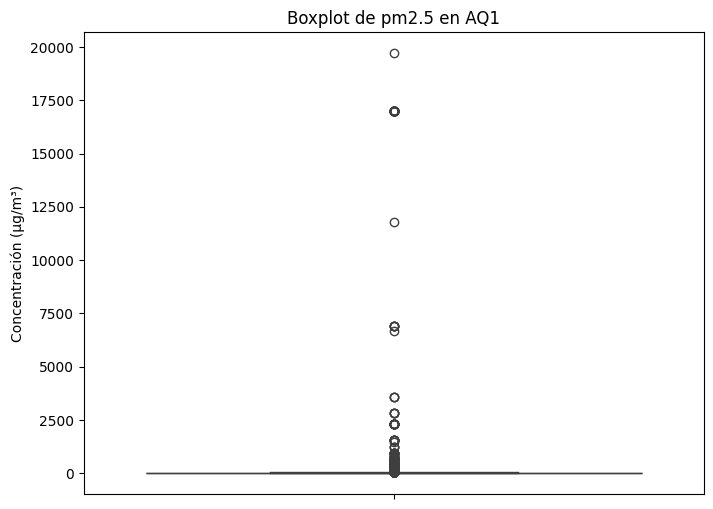

In [52]:
#Boxplot inicial de pm2.5 en DFP_AQ1
plt.figure(figsize=(8, 6))
sns.boxplot(y=DFP_AQ1['pm2_5'])
plt.title('Boxplot de pm2.5 en AQ1')
plt.ylabel('Concentración (µg/m³)')
plt.show()

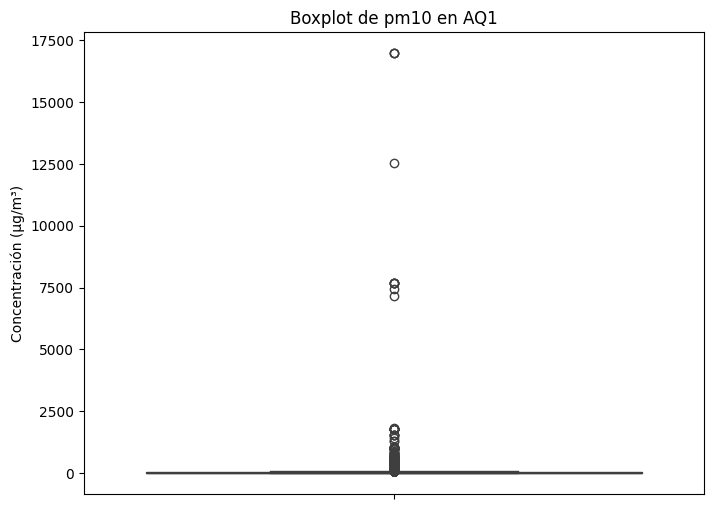

In [53]:
#Boxplot inicial de pm10 en DFP_AQ1
plt.figure(figsize=(8, 6))
sns.boxplot(y=DFP_AQ1['pm10'])
plt.title('Boxplot de pm10 en AQ1')
plt.ylabel('Concentración (µg/m³)')
plt.show()

# 1.1 **AJUSTE OUTLIERS CUARTILES - DF_AQ_1**

DFP_AQ1 - Número de registros antes: 181862
DFP_AQ1 - Número de registros después de remover outliers: 177427


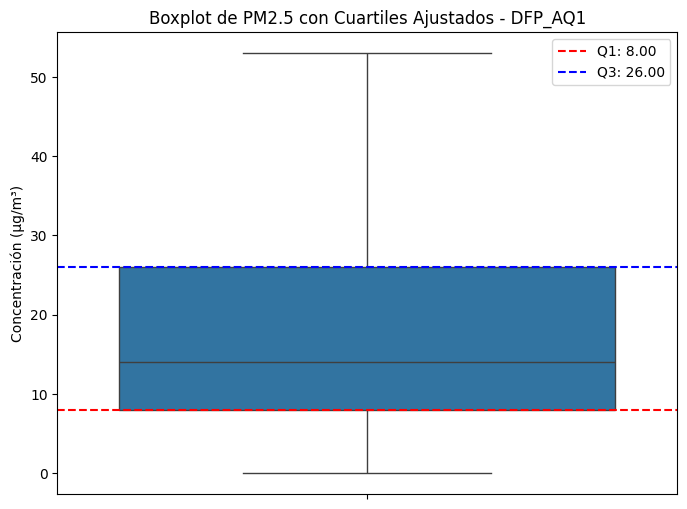

In [98]:
# Primero, eliminamos los outliers usando el método de cuartiles
Q1 = DFP_AQ1['pm2_5'].quantile(0.25)
Q3 = DFP_AQ1['pm2_5'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.4 * IQR
upper_bound = Q3 + 1.4 * IQR

# Filtrar el DataFrame para remover los outliers
DFP_AQ1_CPM2_5 = DFP_AQ1[(DFP_AQ1['pm2_5'] >= lower_bound) & (DFP_AQ1['pm2_5'] <= upper_bound)]

# Calcular los cuartiles en el DataFrame filtrado
Q1_filtered = DFP_AQ1_CPM2_5['pm2_5'].quantile(0.25)
Q3_filtered = DFP_AQ1_CPM2_5['pm2_5'].quantile(0.75)

print("DFP_AQ1 - Número de registros antes:", DFP_AQ1.shape[0])
print("DFP_AQ1 - Número de registros después de remover outliers:", DFP_AQ1_CPM2_5.shape[0])

# Graficar el boxplot para el DataFrame filtrado
plt.figure(figsize=(8, 6))
sns.boxplot(y=DFP_AQ1_CPM2_5['pm2_5'])
plt.axhline(Q1_filtered, color='red', linestyle='--', label=f'Q1: {Q1_filtered:.2f}')
plt.axhline(Q3_filtered, color='blue', linestyle='--', label=f'Q3: {Q3_filtered:.2f}')
plt.title('Boxplot de PM2.5 con Cuartiles Ajustados - DFP_AQ1')
plt.ylabel('Concentración (µg/m³)')
plt.legend()
plt.show()


DFP_AQ1 -Número de registros antes: 181862
DFP_AQ1 - Número de registros después de remover outliers: 177104


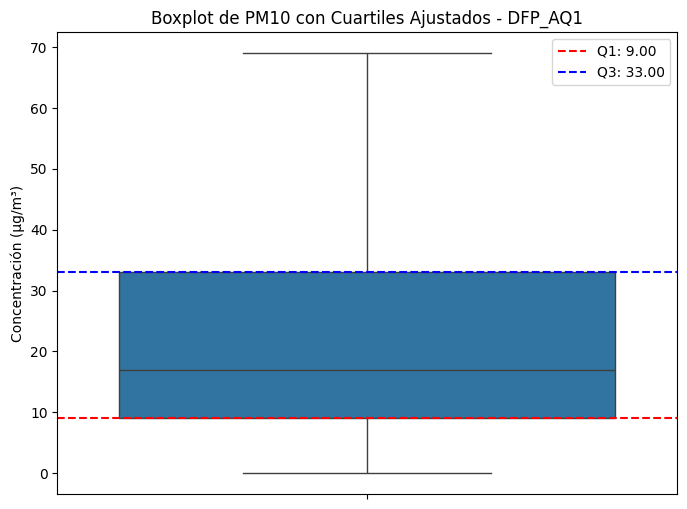

In [ ]:
# Primero, eliminamos los outliers usando el método de cuartiles
Q1 = DFP_AQ1['pm10'].quantile(0.25)
Q3 = DFP_AQ1['pm10'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.4 * IQR
upper_bound = Q3 + 1.4 * IQR

# Filtrar el DataFrame para remover los outliers
DFP_AQ1_CPM10 = DFP_AQ1[(DFP_AQ1['pm10'] >= lower_bound) & (DFP_AQ1['pm10'] <= upper_bound)]

# Calcular los cuartiles en el DataFrame filtrado
Q1_filtered = DFP_AQ1_CPM10['pm10'].quantile(0.25)
Q3_filtered = DFP_AQ1_CPM10['pm10'].quantile(0.75)

print("DFP_AQ1 -Número de registros antes:", DFP_AQ1.shape[0])
print("DFP_AQ1 - Número de registros después de remover outliers:", DFP_AQ1_CPM10.shape[0])

# Graficar el boxplot para el DataFrame filtrado
plt.figure(figsize=(8, 6))
sns.boxplot(y=DFP_AQ1_CPM10['pm10'])
plt.axhline(Q1_filtered, color='red', linestyle='--', label=f'Q1: {Q1_filtered:.2f}')
plt.axhline(Q3_filtered, color='blue', linestyle='--', label=f'Q3: {Q3_filtered:.2f}')
plt.title('Boxplot de PM10 con Cuartiles Ajustados - DFP_AQ1')
plt.ylabel('Concentración (µg/m³)')
plt.legend()
plt.show()


# 2. **Boxplot for DF_AQ_2**

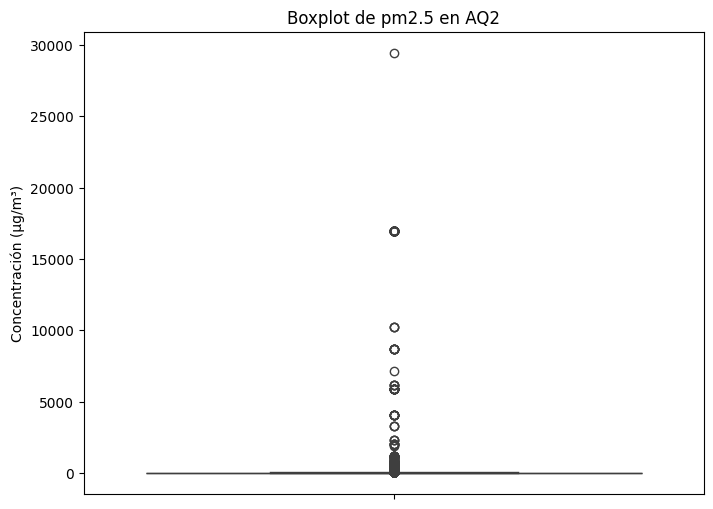

In [56]:
#Boxplot inicial de pm2.5 en DFP_AQ2
plt.figure(figsize=(8, 6))
sns.boxplot(y=DFP_AQ2['pm2_5'])
plt.title('Boxplot de pm2.5 en AQ2')
plt.ylabel('Concentración (µg/m³)')
plt.show()

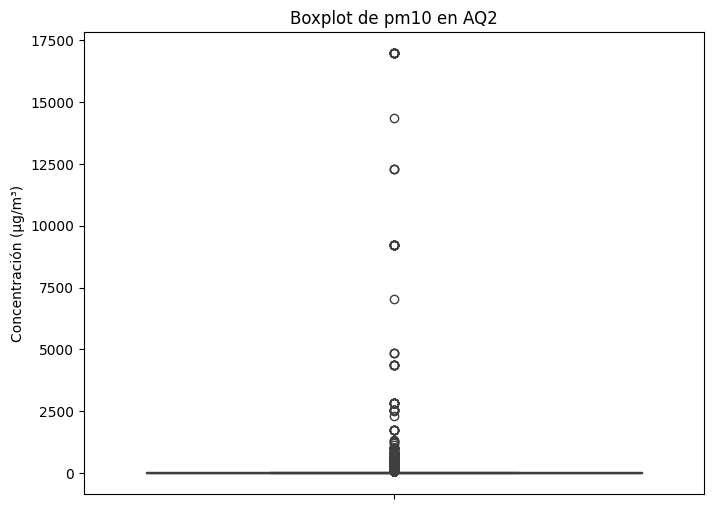

In [57]:
#Boxplot inicial de pm10 en DFP_AQ2
plt.figure(figsize=(8, 6))
sns.boxplot(y=DFP_AQ2['pm10'])
plt.title('Boxplot de pm10 en AQ2')
plt.ylabel('Concentración (µg/m³)')
plt.show()

# 2.1 **AJUSTE OUTLIERS CUARTILES - DF_AQ_2**

DFP_AQ2 - Número de registros antes: 148502
DFP_AQ2 -Número de registros después de remover outliers: 143356


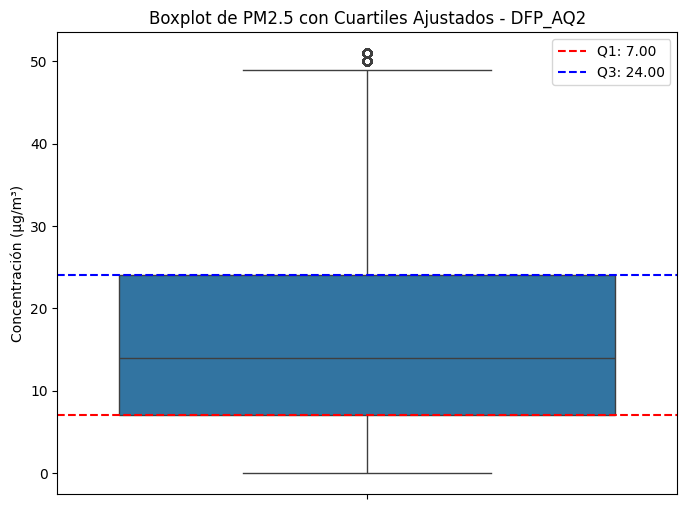

In [58]:
# Primero, eliminamos los outliers usando el método de cuartiles
Q1 = DFP_AQ2['pm2_5'].quantile(0.25)
Q3 = DFP_AQ2['pm2_5'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.4 * IQR
upper_bound = Q3 + 1.4 * IQR

# Filtrar el DataFrame para remover los outliers
DFP_AQ2_CPM2_5 = DFP_AQ2[(DFP_AQ2['pm2_5'] >= lower_bound) & (DFP_AQ2['pm2_5'] <= upper_bound)]

# Calcular los cuartiles en el DataFrame filtrado
Q1_filtered = DFP_AQ2_CPM2_5['pm2_5'].quantile(0.25)
Q3_filtered = DFP_AQ2_CPM2_5['pm2_5'].quantile(0.75)

print("DFP_AQ2 - Número de registros antes:", DFP_AQ2.shape[0])
print("DFP_AQ2 -Número de registros después de remover outliers:", DFP_AQ2_CPM2_5.shape[0])

# Graficar el boxplot para el DataFrame filtrado
plt.figure(figsize=(8, 6))
sns.boxplot(y=DFP_AQ2_CPM2_5['pm2_5'])
plt.axhline(Q1_filtered, color='red', linestyle='--', label=f'Q1: {Q1_filtered:.2f}')
plt.axhline(Q3_filtered, color='blue', linestyle='--', label=f'Q3: {Q3_filtered:.2f}')
plt.title('Boxplot de PM2.5 con Cuartiles Ajustados - DFP_AQ2')
plt.ylabel('Concentración (µg/m³)')
plt.legend()
plt.show()


DFP_AQ2 -Número de registros antes: 148502
DFP_AQ2 - Número de registros después de remover outliers: 142572


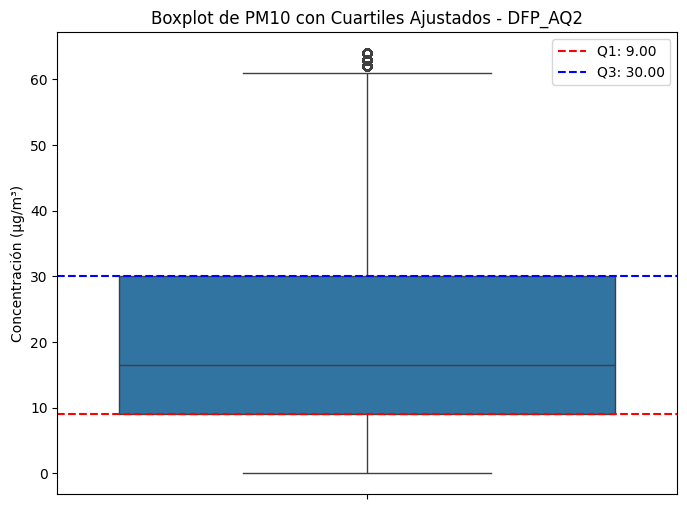

In [59]:
# Primero, eliminamos los outliers usando el método de cuartiles
Q1 = DFP_AQ2['pm10'].quantile(0.25)
Q3 = DFP_AQ2['pm10'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.4 * IQR
upper_bound = Q3 + 1.4 * IQR

# Filtrar el DataFrame para remover los outliers
DFP_AQ2_CPM10 = DFP_AQ2[(DFP_AQ2['pm10'] >= lower_bound) & (DFP_AQ2['pm10'] <= upper_bound)]

# Calcular los cuartiles en el DataFrame filtrado
Q1_filtered = DFP_AQ2_CPM10['pm10'].quantile(0.25)
Q3_filtered = DFP_AQ2_CPM10['pm10'].quantile(0.75)

print("DFP_AQ2 -Número de registros antes:", DFP_AQ2.shape[0])
print("DFP_AQ2 - Número de registros después de remover outliers:", DFP_AQ2_CPM10.shape[0])

# Graficar el boxplot para el DataFrame filtrado
plt.figure(figsize=(8, 6))
sns.boxplot(y=DFP_AQ2_CPM10['pm10'])
plt.axhline(Q1_filtered, color='red', linestyle='--', label=f'Q1: {Q1_filtered:.2f}')
plt.axhline(Q3_filtered, color='blue', linestyle='--', label=f'Q3: {Q3_filtered:.2f}')
plt.title('Boxplot de PM10 con Cuartiles Ajustados - DFP_AQ2')
plt.ylabel('Concentración (µg/m³)')
plt.legend()
plt.show()


# 3 **RESAMPLE - DFP_AQ1_CPM10**

In [60]:
display(DFP_AQ1_CPM10)

pm2_5  pm10  co   o3  humidity  temperature          time_format
0          44    58   2  NaN      60.3         20.3  2024-04-08 18:39:00
1          46    56   3  NaN      60.3         20.3  2024-04-08 18:41:00
2          46    56   4  NaN      60.3         20.3  2024-04-08 18:43:00
3          46    61   5  NaN      60.4         20.3  2024-04-08 18:45:00
4          45    61   6  NaN      60.5         20.3  2024-04-08 18:48:00
...       ...   ...  ..  ...       ...          ...                  ...
181857      3     3  13  1.0      57.3         13.8  2023-07-20 23:49:20
181858      3     3  14  1.0      57.2         13.7  2023-07-20 23:51:25
181859      3     3  15  1.0       0.0          0.0  2023-07-20 23:53:30
181860      3     3  16  1.0      57.1         13.6  2023-07-20 23:55:35
181861      3     3  18  1.0      57.3         13.5  2023-07-20 23:59:42

[177104 rows x 7 columns]

In [61]:
# Asegúrate de que 'time_format' esté en formato datetime
DFP_AQ1_CPM10['time_format'] = pd.to_datetime(DFP_AQ1_CPM10['time_format'])

# Establecer la columna 'time_format' como índice
DFP_AQ1_CPM10.set_index('time_format', inplace=True)

# Resampleo por hora y calcular la media de 'pm10' en cada intervalo
DFP_AQ1_CPM10_resampled = DFP_AQ1_CPM10.resample('H').median()

# Mostrar los primeros registros del DataFrame resampleado
print(DFP_AQ1_CPM10_resampled.head())

                     pm2_5  pm10    co   o3  humidity  temperature
time_format                                                       
2023-06-28 00:00:00    8.0  13.0  16.0  0.0      75.1         11.4
2023-06-28 01:00:00   18.0  22.0  14.0  0.0      79.6         10.5
2023-06-28 02:00:00   18.0  21.0  15.5  0.0      78.4         11.0
2023-06-28 03:00:00   21.0  26.0  14.0  0.0      81.6          9.7
2023-06-28 04:00:00   20.0  25.0  15.0  0.0      79.3          9.4


/tmp/ipykernel_268368/1936516632.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_268368/1936516632.py:8: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



In [62]:
display(DFP_AQ1_CPM10_resampled)

pm2_5  pm10    co   o3  humidity  temperature
time_format                                                       
2023-06-28 00:00:00    8.0  13.0  16.0  0.0      75.1         11.4
2023-06-28 01:00:00   18.0  22.0  14.0  0.0      79.6         10.5
2023-06-28 02:00:00   18.0  21.0  15.5  0.0      78.4         11.0
2023-06-28 03:00:00   21.0  26.0  14.0  0.0      81.6          9.7
2023-06-28 04:00:00   20.0  25.0  15.0  0.0      79.3          9.4
...                    ...   ...   ...  ...       ...          ...
2024-08-14 19:00:00   27.0  40.0  17.0  NaN      47.8         15.3
2024-08-14 20:00:00   32.0  43.0  15.0  NaN      51.5         14.2
2024-08-14 21:00:00   16.0  20.0  16.0  NaN      54.7         13.7
2024-08-14 22:00:00   27.5  35.0  13.5  NaN      62.4         13.2
2024-08-14 23:00:00   19.0  22.0  20.0  NaN      61.2         12.9

[9936 rows x 6 columns]

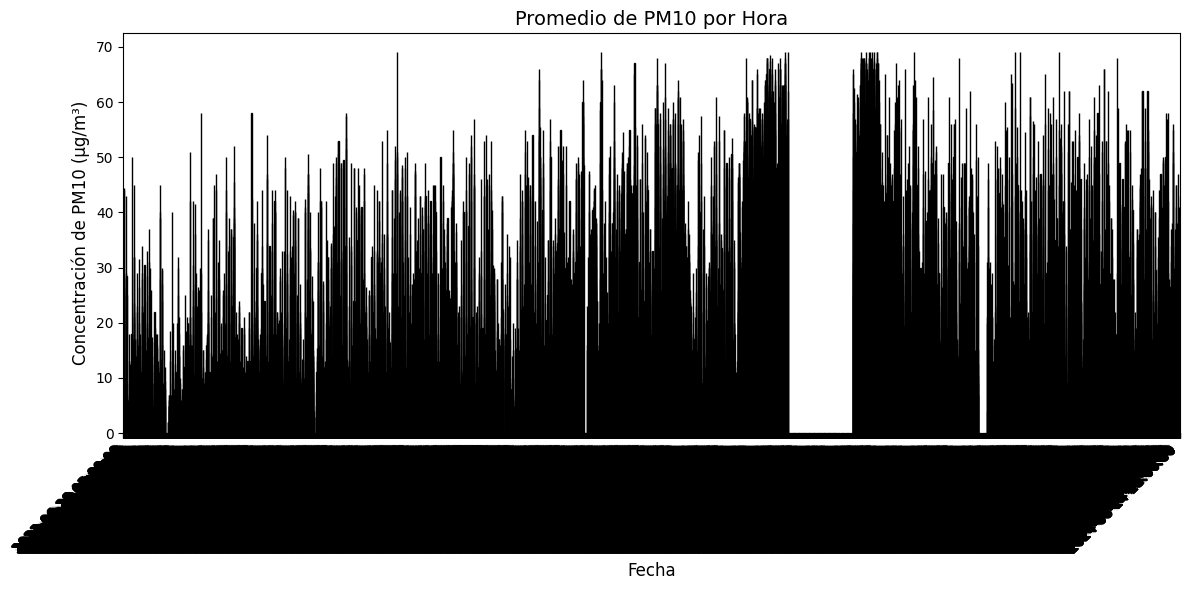

In [63]:
# Asegurarse de que los datos estén correctamente resampleados
# Usamos un gráfico de barras para mostrar las medias de pm10 por hora
plt.figure(figsize=(12, 6))

# Graficar el DataFrame resampleado
DFP_AQ1_CPM10_resampled['pm10'].plot(kind='bar', color='skyblue', edgecolor='black')

# Añadir título y etiquetas a los ejes
plt.title('Promedio de PM10 por Hora', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Concentración de PM10 (µg/m³)', fontsize=12)

# Ajustar el formato de las fechas en el eje X para que no se sobrepongan
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [64]:
display(DFP_AQ1_CPM10_resampled.columns)

Index(['pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'], dtype='object')

In [65]:
DFP_AQ1_CPM10_resampled

pm2_5  pm10    co   o3  humidity  temperature
time_format                                                       
2023-06-28 00:00:00    8.0  13.0  16.0  0.0      75.1         11.4
2023-06-28 01:00:00   18.0  22.0  14.0  0.0      79.6         10.5
2023-06-28 02:00:00   18.0  21.0  15.5  0.0      78.4         11.0
2023-06-28 03:00:00   21.0  26.0  14.0  0.0      81.6          9.7
2023-06-28 04:00:00   20.0  25.0  15.0  0.0      79.3          9.4
...                    ...   ...   ...  ...       ...          ...
2024-08-14 19:00:00   27.0  40.0  17.0  NaN      47.8         15.3
2024-08-14 20:00:00   32.0  43.0  15.0  NaN      51.5         14.2
2024-08-14 21:00:00   16.0  20.0  16.0  NaN      54.7         13.7
2024-08-14 22:00:00   27.5  35.0  13.5  NaN      62.4         13.2
2024-08-14 23:00:00   19.0  22.0  20.0  NaN      61.2         12.9

[9936 rows x 6 columns]

In [66]:
DFP_AQ1_CPM10_resampled.count()

pm2_5          9043
pm10           9043
co             9043
o3              790
humidity       9043
temperature    9043
dtype: int64

In [67]:
df_pm10_null = DFP_AQ1_CPM10_resampled[DFP_AQ1_CPM10_resampled['pm10'].isnull()]
# Mostrar el resultado
print(df_pm10_null)

                     pm2_5  pm10  co  o3  humidity  temperature
time_format                                                    
2023-07-13 20:00:00    NaN   NaN NaN NaN       NaN          NaN
2023-07-13 21:00:00    NaN   NaN NaN NaN       NaN          NaN
2023-07-13 22:00:00    NaN   NaN NaN NaN       NaN          NaN
2023-07-13 23:00:00    NaN   NaN NaN NaN       NaN          NaN
2023-07-14 00:00:00    NaN   NaN NaN NaN       NaN          NaN
...                    ...   ...  ..  ..       ...          ...
2024-06-06 17:00:00    NaN   NaN NaN NaN       NaN          NaN
2024-06-06 18:00:00    NaN   NaN NaN NaN       NaN          NaN
2024-06-26 16:00:00    NaN   NaN NaN NaN       NaN          NaN
2024-06-26 17:00:00    NaN   NaN NaN NaN       NaN          NaN
2024-07-23 07:00:00    NaN   NaN NaN NaN       NaN          NaN

[893 rows x 6 columns]


# 3.1 **IDENTIFICAR MEJOR INTERVALOR - DFP_AQ1_CPM10**

# 1 .Contar la cantidad de registros por día:
# - Convertir la columna de fechas a tipo datetime, extraer la fecha (sin hora) y agrupar para contar cuántos registros tenemos en cada día.

# 2 .Identificar intervalos continuos:
# - Una vez que tengas la serie de conteo diario, puedes detectar “intervalos” (periodos consecutivos sin saltos de días) y sumar los registros de cada uno. Finalmente, se selecciona los dos intervalos con mayor cantidad total de datos.

In [68]:
# Copiar el DataFrame resampleado y extraer el índice a una columna 'time'
df_resampled = DFP_AQ1_CPM10_resampled.copy()
df_resampled['time'] = df_resampled.index

# Asegurarse de que está ordenado por tiempo
df_resampled = df_resampled.sort_values('time')

# Calcular la diferencia en horas entre registros consecutivos
df_resampled['diff_hours'] = df_resampled['time'].diff().dt.total_seconds() / 3600

# Marcar el inicio de un nuevo intervalo cada vez que la diferencia no es 1 (o es NaN en la primera fila)
df_resampled['interval_group'] = (df_resampled['diff_hours'] != 1).cumsum()

# Agrupar por 'interval_group' para obtener resumen de cada intervalo
interval_summary = df_resampled.groupby('interval_group').agg(
    start_date=('time', 'min'),
    end_date=('time', 'max'),
    count=('time', 'count')
).reset_index()

# Ordenar los intervalos de mayor a menor cantidad de registros
interval_summary = interval_summary.sort_values('count', ascending=False)

print("Resumen de intervalos:")
print(interval_summary)

# Seleccionar los dos intervalos con mayor cantidad de datos
top2_intervals = interval_summary.head(2)
print("\nLos dos intervalos con mayor cantidad de datos son:")
print(top2_intervals)


Resumen de intervalos:
   interval_group start_date            end_date  count
0               1 2023-06-28 2024-08-14 23:00:00   9936

Los dos intervalos con mayor cantidad de datos son:
   interval_group start_date            end_date  count
0               1 2023-06-28 2024-08-14 23:00:00   9936


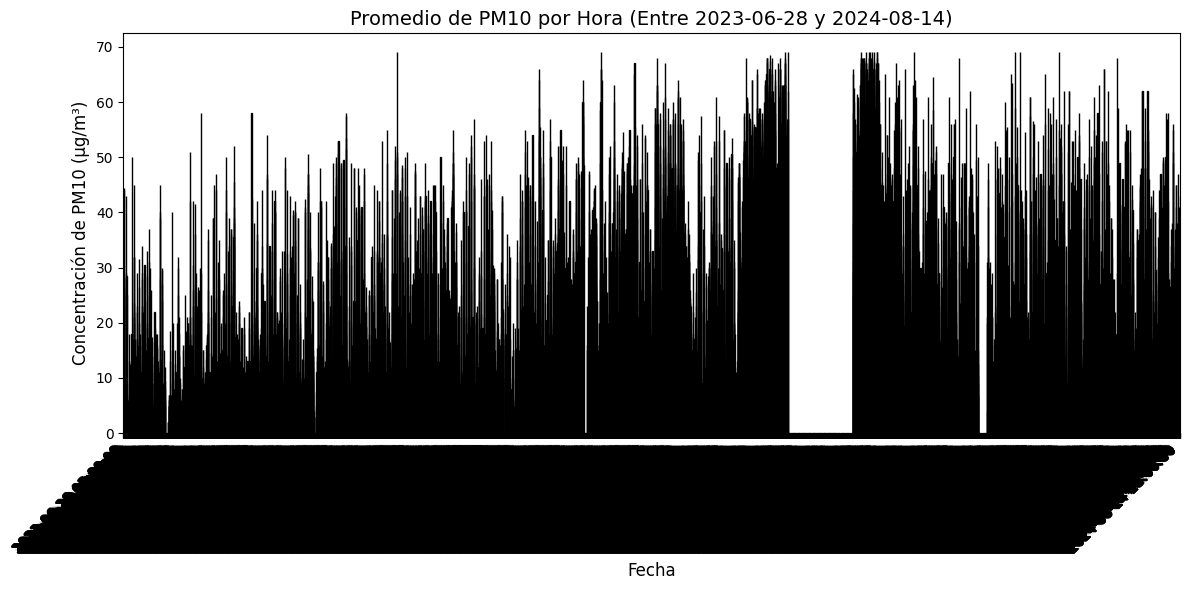

In [69]:
# Filtrar los datos entre el intervalo de fechas especificado
start_date = '2023-06-28 00:00:00'
end_date = '2024-08-14 23:00:00'


# Filtrar el DataFrame para que solo contenga los datos dentro del rango de fechas
filtered_df = DFP_AQ1_CPM10_resampled[(DFP_AQ1_CPM10_resampled.index >= start_date) & (DFP_AQ1_CPM10_resampled.index <= end_date)]

# Asegurarse de que los datos estén correctamente resampleados
# Usamos un gráfico de barras para mostrar las medias de pm10 por hora
plt.figure(figsize=(12, 6))

# Graficar el DataFrame resampleado filtrado
filtered_df['pm10'].plot(kind='bar', color='skyblue', edgecolor='black')

# Añadir título y etiquetas a los ejes
plt.title('Promedio de PM10 por Hora (Entre 2023-06-28 y 2024-08-14)', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Concentración de PM10 (µg/m³)', fontsize=12)

# Ajustar el formato de las fechas en el eje X para que no se sobrepongan
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


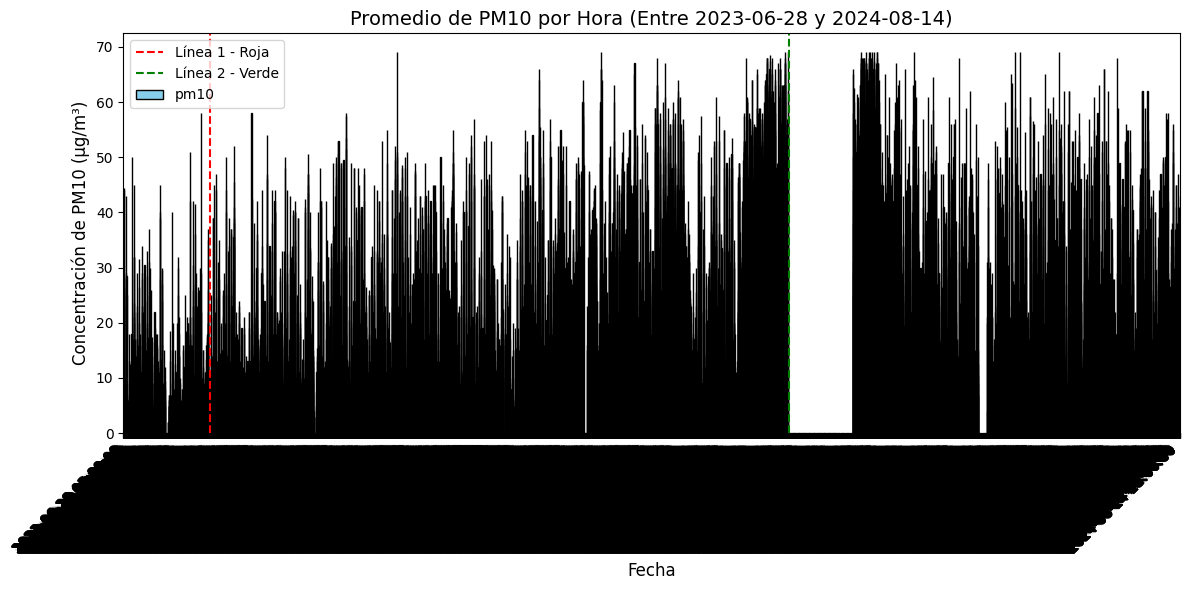

In [70]:
# Filtrar los datos entre el intervalo de fechas especificado
start_date = '2023-06-28 00:00:00'
end_date = '2024-08-14 23:00:00'

# Filtrar el DataFrame para que solo contenga los datos dentro del rango de fechas
filtered_df = DFP_AQ1_CPM10_resampled[(DFP_AQ1_CPM10_resampled.index >= start_date) & (DFP_AQ1_CPM10_resampled.index <= end_date)]

# Asegurarse de que los datos estén correctamente resampleados
# Usamos un gráfico de barras para mostrar las medias de pm10 por hora
plt.figure(figsize=(12, 6))

# Graficar el DataFrame resampleado filtrado
filtered_df['pm10'].plot(kind='bar', color='skyblue', edgecolor='black')

# Añadir título y etiquetas a los ejes
plt.title('Promedio de PM10 por Hora (Entre 2023-06-28 y 2024-08-14)', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Concentración de PM10 (µg/m³)', fontsize=12)

# Ajustar el formato de las fechas en el eje X para que no se sobrepongan
plt.xticks(rotation=45, ha='right')

# Fechas en las que se quiere agregar las líneas verticales
date_1 = pd.to_datetime('2023-08-01 00:00:00')
date_2 = pd.to_datetime('2024-03-15 00:00:00')

# Convertir las fechas a posiciones en el eje X
date_1_pos = filtered_df.index.get_loc(date_1)
date_2_pos = filtered_df.index.get_loc(date_2)

# Agregar las líneas verticales
plt.axvline(x=date_1_pos, color='red', linestyle='--', label='Línea 1 - Roja')  # Línea roja
plt.axvline(x=date_2_pos, color='green', linestyle='--', label='Línea 2 - Verde')  # Línea verde

# Mostrar leyenda
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


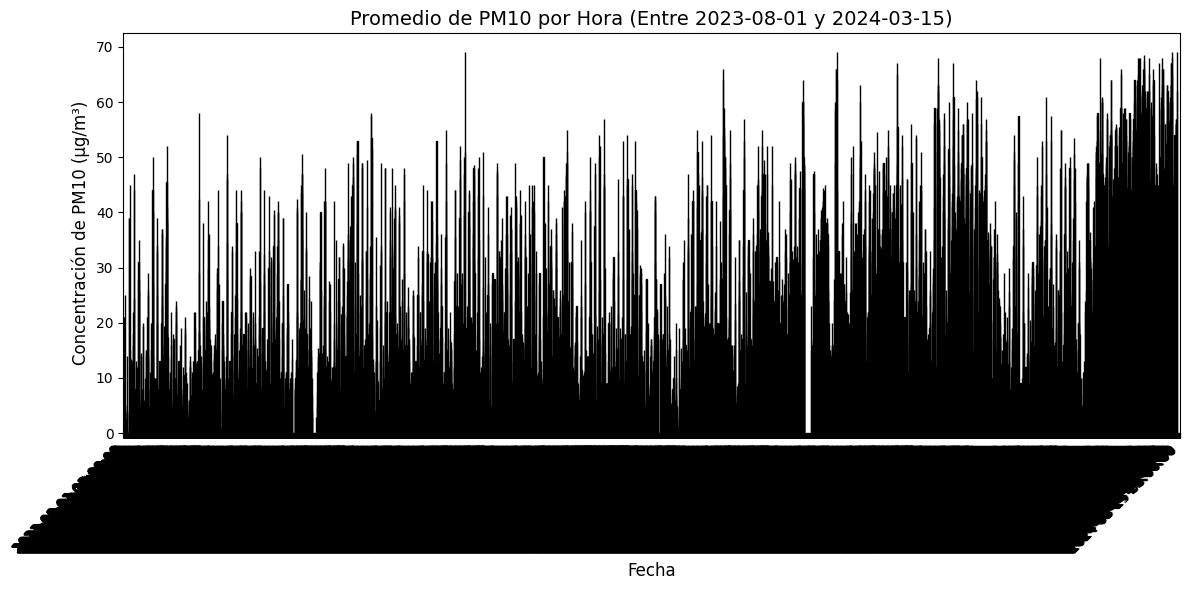

In [71]:
# Filtrar los datos entre el intervalo de fechas especificado
start_date = '2023-08-01 00:00:00'
end_date = '2024-03-15 00:00:00'

# Filtrar el DataFrame para que solo contenga los datos dentro del rango de fechas
DFP_AQ1_CPM10_RR = DFP_AQ1_CPM10_resampled[(DFP_AQ1_CPM10_resampled.index >= start_date) & (DFP_AQ1_CPM10_resampled.index <= end_date)]

# Asegurarse de que los datos estén correctamente resampleados
# Usamos un gráfico de barras para mostrar las medias de pm10 por hora
plt.figure(figsize=(12, 6))

# Graficar el DataFrame resampleado filtrado
DFP_AQ1_CPM10_RR['pm10'].plot(kind='bar', color='skyblue', edgecolor='black')

# Añadir título y etiquetas a los ejes
plt.title('Promedio de PM10 por Hora (Entre 2023-08-01 y 2024-03-15)', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Concentración de PM10 (µg/m³)', fontsize=12)

# Ajustar el formato de las fechas en el eje X para que no se sobrepongan
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [72]:
DFP_AQ1_CPM10_RR

pm2_5  pm10    co   o3  humidity  temperature
time_format                                                       
2023-08-01 00:00:00    7.0   9.0  14.0  1.0      60.6         13.3
2023-08-01 01:00:00    9.0  10.0  13.0  1.0      63.5         12.9
2023-08-01 02:00:00    7.0  11.0  13.0  1.0      64.8         12.8
2023-08-01 03:00:00    7.0   8.0  12.0  1.0      66.0         12.5
2023-08-01 04:00:00    9.0  10.0  13.0  1.0      67.3         12.3
...                    ...   ...   ...  ...       ...          ...
2024-03-14 20:00:00    NaN   NaN   NaN  NaN       NaN          NaN
2024-03-14 21:00:00    NaN   NaN   NaN  NaN       NaN          NaN
2024-03-14 22:00:00    NaN   NaN   NaN  NaN       NaN          NaN
2024-03-14 23:00:00    NaN   NaN   NaN  NaN       NaN          NaN
2024-03-15 00:00:00    NaN   NaN   NaN  NaN       NaN          NaN

[5449 rows x 6 columns]

In [73]:
# Crear una copia de DFP_AQ1_CPM10_RR
DFP_AQ1_CPM10_RR_COUNT = DFP_AQ1_CPM10_RR.copy()

# Convertir el índice (fecha y hora) a solo fecha (sin la hora)
DFP_AQ1_CPM10_RR_COUNT['date'] = DFP_AQ1_CPM10_RR_COUNT.index.date

# Agrupar por fecha y contar cuántos registros de pm10 hay por día
daily_counts = DFP_AQ1_CPM10_RR_COUNT.groupby('date').size().reset_index(name='counts')



In [74]:
daily_counts = daily_counts.sort_values('counts')

In [82]:
dtale.show(daily_counts)

 * Tip: There are .env or .flaskenv files present. Do "pip install python-dotenv" to use them.


In [83]:
DFP_AQ1_CPM10_RR

pm2_5  pm10    co   o3  humidity  temperature
time_format                                                       
2023-08-01 00:00:00    7.0   9.0  14.0  1.0      60.6         13.3
2023-08-01 01:00:00    9.0  10.0  13.0  1.0      63.5         12.9
2023-08-01 02:00:00    7.0  11.0  13.0  1.0      64.8         12.8
2023-08-01 03:00:00    7.0   8.0  12.0  1.0      66.0         12.5
2023-08-01 04:00:00    9.0  10.0  13.0  1.0      67.3         12.3
...                    ...   ...   ...  ...       ...          ...
2024-03-14 20:00:00    NaN   NaN   NaN  NaN       NaN          NaN
2024-03-14 21:00:00    NaN   NaN   NaN  NaN       NaN          NaN
2024-03-14 22:00:00    NaN   NaN   NaN  NaN       NaN          NaN
2024-03-14 23:00:00    NaN   NaN   NaN  NaN       NaN          NaN
2024-03-15 00:00:00    NaN   NaN   NaN  NaN       NaN          NaN

[5449 rows x 6 columns]

In [84]:
dtale.show(DFP_AQ1_CPM10_RR)

In [85]:
df_pm10_null = DFP_AQ1_CPM10_RR[DFP_AQ1_CPM10_RR['pm10'].isnull()]
dtale.show(df_pm10_null)

In [86]:
df_pm10_null

pm2_5  pm10  co  o3  humidity  temperature
time_format                                                    
2023-08-01 12:00:00    NaN   NaN NaN NaN       NaN          NaN
2023-08-01 13:00:00    NaN   NaN NaN NaN       NaN          NaN
2023-08-01 14:00:00    NaN   NaN NaN NaN       NaN          NaN
2023-08-01 15:00:00    NaN   NaN NaN NaN       NaN          NaN
2023-08-01 22:00:00    NaN   NaN NaN NaN       NaN          NaN
...                    ...   ...  ..  ..       ...          ...
2024-03-14 20:00:00    NaN   NaN NaN NaN       NaN          NaN
2024-03-14 21:00:00    NaN   NaN NaN NaN       NaN          NaN
2024-03-14 22:00:00    NaN   NaN NaN NaN       NaN          NaN
2024-03-14 23:00:00    NaN   NaN NaN NaN       NaN          NaN
2024-03-15 00:00:00    NaN   NaN NaN NaN       NaN          NaN

[149 rows x 6 columns]

In [75]:
DFP_AQ1_CPM10_RR.index.all

<bound method Index.all of DatetimeIndex(['2023-08-01 00:00:00', '2023-08-01 01:00:00',
               '2023-08-01 02:00:00', '2023-08-01 03:00:00',
               '2023-08-01 04:00:00', '2023-08-01 05:00:00',
               '2023-08-01 06:00:00', '2023-08-01 07:00:00',
               '2023-08-01 08:00:00', '2023-08-01 09:00:00',
               ...
               '2024-03-14 15:00:00', '2024-03-14 16:00:00',
               '2024-03-14 17:00:00', '2024-03-14 18:00:00',
               '2024-03-14 19:00:00', '2024-03-14 20:00:00',
               '2024-03-14 21:00:00', '2024-03-14 22:00:00',
               '2024-03-14 23:00:00', '2024-03-15 00:00:00'],
              dtype='datetime64[ns]', name='time_format', length=5449, freq='h')>

In [76]:
def imputar_valores_sarima(df, columna='pm10', plot=True, 
                               order=(1,1,1), seasonal_order=(1,1,1,24)):
    """
    Función para imputar valores faltantes en datos de calidad del aire (PM10)
    utilizando el modelo SARIMA, con manejo mejorado de índices de tiempo.
    
    Parámetros:
    -----------
    df : DataFrame
        DataFrame con índice temporal y columna de PM10 con valores faltantes
    columna : str, default='pm10'
        Nombre de la columna que contiene los datos de PM10
    plot : bool, default=True
        Si se deben mostrar gráficos de los resultados
    order : tuple, default=(1,1,1)
        Orden del modelo SARIMA (p,d,q)
    seasonal_order : tuple, default=(1,1,1,24)
        Orden estacional del modelo SARIMA (P,D,Q,s) - default estacionalidad diaria
        
    Retorna:
    --------
    DataFrame con los valores imputados
    """
    # Crear una copia del DataFrame original
    df_imputado = df.copy()
    
    # Asegurarse de que el índice es datetime
    if not isinstance(df_imputado.index, pd.DatetimeIndex):
        print("ADVERTENCIA: El índice no es de tipo datetime. Se recomienda establecer un índice de tiempo.")
    
    # Verificar si hay valores faltantes
    if not df_imputado[columna].isna().any():
        print("No hay valores faltantes en la columna", columna)
        return df_imputado
    
    # Identificar posiciones de valores faltantes
    mask_nan = df_imputado[columna].isna()
    indices_nan = np.where(mask_nan)[0]
    print(f"Se encontraron {len(indices_nan)} valores faltantes")
    
    # Si todos los valores son NaN, no podemos hacer imputación con SARIMA
    if len(indices_nan) == len(df_imputado):
        raise ValueError("Todos los valores son NaN, no se puede realizar la imputación con SARIMA")
    
    # Encontrar secuencias de valores NaN consecutivos
    secuencias_nan = []
    secuencia_actual = []
    
    for i in range(len(indices_nan)):
        if i == 0 or indices_nan[i] != indices_nan[i-1] + 1:
            if secuencia_actual:
                secuencias_nan.append(secuencia_actual)
            secuencia_actual = [indices_nan[i]]
        else:
            secuencia_actual.append(indices_nan[i])
    
    if secuencia_actual:
        secuencias_nan.append(secuencia_actual)
    
    print(f"Usando parámetros SARIMA: {order} x {seasonal_order}")
    
    # Función para imputar una secuencia de valores faltantes
    def imputar_secuencia(indices):
        # Si es el primer valor en el índice, no podemos usar datos anteriores
        if indices[0] == 0:
            inicio_entrenamiento = indices[-1] + 1
            fin_entrenamiento = min(inicio_entrenamiento + 24*7, len(df_imputado) - 1)  # Usar 1 semana de datos si está disponible
            
            if inicio_entrenamiento >= len(df_imputado) or fin_entrenamiento >= len(df_imputado):
                # Si no hay datos después, usar la media
                valor_medio = df_imputado[columna].mean()
                for idx in indices:
                    df_imputado.iloc[idx, df_imputado.columns.get_loc(columna)] = valor_medio
                print(f"Usando la media ({valor_medio}) para imputar valores al inicio")
                return
            
            # Entrenar modelo con datos posteriores
            train = df_imputado.iloc[inicio_entrenamiento:fin_entrenamiento+1][columna]
            
            # Ajustar modelo SARIMA
            try:
                modelo = SARIMAX(
                    train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                resultado = modelo.fit(disp=False)
                
                # Predecir valores anteriores - hacer forecast en dirección negativa
                # En lugar de usar predict con start/end, creamos manualmente predicciones
                predicciones = []
                for _ in range(len(indices)):
                    predicciones.insert(0, resultado.forecast(steps=1)[0])  # Insertamos al inicio
                
                # Imputar los valores predichos
                for i, idx in enumerate(indices):
                    df_imputado.iloc[idx, df_imputado.columns.get_loc(columna)] = predicciones[i]
            except Exception as e:
                print(f"Error al imputar valores al inicio: {e}")
                # Imputar con la media
                valor_medio = df_imputado[columna].mean()
                for idx in indices:
                    df_imputado.iloc[idx, df_imputado.columns.get_loc(columna)] = valor_medio
        
        # Si es el último valor en el índice, no podemos usar datos posteriores
        elif indices[-1] == len(df_imputado) - 1:
            fin_entrenamiento = indices[0] - 1
            inicio_entrenamiento = max(0, fin_entrenamiento - 24*7)  # Usar 1 semana de datos si está disponible
            
            if inicio_entrenamiento < 0 or fin_entrenamiento < 0:
                # Si no hay datos antes, usar la media
                valor_medio = df_imputado[columna].mean()
                for idx in indices:
                    df_imputado.iloc[idx, df_imputado.columns.get_loc(columna)] = valor_medio
                print(f"Usando la media ({valor_medio}) para imputar valores al final")
                return
            
            # Entrenar modelo con datos anteriores
            train = df_imputado.iloc[inicio_entrenamiento:fin_entrenamiento+1][columna]
            
            # Ajustar modelo SARIMA
            try:
                modelo = SARIMAX(
                    train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                resultado = modelo.fit(disp=False)
                
                # Predecir valores futuros
                predicciones = resultado.forecast(steps=len(indices))
                
                # Imputar los valores predichos
                for i, idx in enumerate(indices):
                    df_imputado.iloc[idx, df_imputado.columns.get_loc(columna)] = predicciones[i]
            except Exception as e:
                print(f"Error al imputar valores al final: {e}")
                # Imputar con la media
                valor_medio = df_imputado[columna].mean()
                for idx in indices:
                    df_imputado.iloc[idx, df_imputado.columns.get_loc(columna)] = valor_medio
        
        # Caso intermedio: hay datos antes y después
        else:
            # Identificar índices antes y después de la secuencia NaN
            indices_antes = list(range(0, indices[0]))
            indices_despues = list(range(indices[-1] + 1, len(df_imputado)))
            
            # Limitar a 7 días (168 horas) si hay suficientes datos
            if len(indices_antes) > 24*7:
                indices_antes = indices_antes[-24*7:]
            if len(indices_despues) > 24*7:
                indices_despues = indices_despues[:24*7]
            
            # Verificar si hay suficientes datos para entrenar
            if len(indices_antes) == 0 and len(indices_despues) == 0:
                valor_medio = df_imputado[columna].mean()
                for idx in indices:
                    df_imputado.iloc[idx, df_imputado.columns.get_loc(columna)] = valor_medio
                print(f"Usando la media ({valor_medio}) para imputar valores intermedios")
                return
            
            # Preparar datos de entrenamiento
            train_antes = df_imputado.iloc[indices_antes][columna].dropna() if indices_antes else pd.Series()
            train_despues = df_imputado.iloc[indices_despues][columna].dropna() if indices_despues else pd.Series()
            
            # Si alguno de los conjuntos de entrenamiento está vacío, usar el otro
            if len(train_antes) == 0:
                train = train_despues
            elif len(train_despues) == 0:
                train = train_antes
            else:
                train = pd.concat([train_antes, train_despues])
            
            # Si después de filtrar NaN no tenemos suficientes datos, usamos la media
            if len(train) < 5:  # Mínimo de puntos para ajuste razonable
                valor_medio = df_imputado[columna].mean()
                for idx in indices:
                    df_imputado.iloc[idx, df_imputado.columns.get_loc(columna)] = valor_medio
                print(f"Usando la media ({valor_medio}) para imputar valores (pocos datos)")
                return
            
            # Ajustar modelo SARIMA
            try:
                modelo = SARIMAX(
                    train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                resultado = modelo.fit(disp=False)
                
                # Calcular valores para imputar usando interpolación entre los datos antes y después
                # Este método evita problemas con predict() y fechas
                if len(train_antes) > 0 and len(train_despues) > 0:
                    # Si tenemos datos antes y después, usamos una combinación de ambos
                    ultimo_antes = df_imputado.iloc[indices_antes[-1]][columna]
                    primero_despues = df_imputado.iloc[indices_despues[0]][columna]
                    
                    # Generamos valores intermedios
                    total_gap = len(indices) + 1
                    for i, idx in enumerate(indices):
                        # Peso que varía de 0 (cerca de antes) a 1 (cerca de después)
                        peso = (i + 1) / total_gap
                        valor_base = ultimo_antes * (1 - peso) + primero_despues * peso
                        
                        # Agregar predicción del modelo como factor de corrección
                        prediccion = resultado.forecast(steps=1)[0]  # Solo un paso
                        factor_correccion = prediccion / train.mean() if train.mean() != 0 else 1
                        
                        # Aplicar corrección limitada para evitar valores extremos
                        factor_correccion = max(0.5, min(1.5, factor_correccion))
                        
                        # Valor final
                        valor_imputado = valor_base * factor_correccion
                        df_imputado.iloc[idx, df_imputado.columns.get_loc(columna)] = valor_imputado
                else:
                    # Si solo tenemos datos de un lado, generamos forecast
                    predicciones = resultado.forecast(steps=len(indices))
                    for i, idx in enumerate(indices):
                        df_imputado.iloc[idx, df_imputado.columns.get_loc(columna)] = predicciones[i]
            except Exception as e:
                print(f"Error al imputar valores intermedios: {e}")
                # Imputar con interpolación lineal simple
                if len(train_antes) > 0 and len(train_despues) > 0:
                    ultimo_antes = df_imputado.iloc[indices_antes[-1]][columna]
                    primero_despues = df_imputado.iloc[indices_despues[0]][columna]
                    total_gap = len(indices) + 1
                    for i, idx in enumerate(indices):
                        peso = (i + 1) / total_gap
                        valor_imputado = ultimo_antes * (1 - peso) + primero_despues * peso
                        df_imputado.iloc[idx, df_imputado.columns.get_loc(columna)] = valor_imputado
                    print("Usando interpolación lineal para imputar valores intermedios")
                else:
                    # Si solo hay datos de un lado, usamos la media
                    valor_medio = df_imputado[columna].mean()
                    for idx in indices:
                        df_imputado.iloc[idx, df_imputado.columns.get_loc(columna)] = valor_medio
                    print(f"Usando la media ({valor_medio}) para imputar valores")
    
    # Imputar cada secuencia de valores faltantes
    for i, secuencia in enumerate(secuencias_nan):
        print(f"Imputando secuencia {i+1} de {len(secuencias_nan)} ({len(secuencia)} valores)")
        imputar_secuencia(secuencia)
    
    # Mostrar gráficos si se solicita
    if plot:
        plt.figure(figsize=(15, 7))
        # Graficar serie original con NaNs
        serie_original = df[columna].copy()
        plt.plot(serie_original, 'o-', alpha=0.3, label='Original (con NaNs)')
        
        # Graficar solo los valores originales no-NaN
        valores_validos = df[~df[columna].isna()]
        plt.plot(valores_validos.index, valores_validos[columna], 'o', alpha=0.7, 
                label='Valores originales')
        
        # Graficar valores imputados
        valores_imputados = df_imputado[mask_nan]
        plt.plot(valores_imputados.index, valores_imputados[columna], 'rx', markersize=8, 
                label='Valores imputados')
        
        # Graficar serie completa imputada
        plt.plot(df_imputado.index, df_imputado[columna], 'g-', alpha=0.5, 
                label='Serie imputada')
        
        plt.xlabel('Fecha')
        plt.ylabel(f'Valores de {columna}')
        plt.title(f'Imputación de valores faltantes en {columna} usando SARIMA')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    return df_imputado

In [79]:
def imputar_valores_sarima_avanzado(df, columna='pm10', plot=True, 
                                   auto_arima=True, max_order=2, stepwise=True,
                                   order=(1,1,1), seasonal_order=(1,1,1,24),
                                   use_exog=False, exog_columns=None,
                                   validation=True, window_size=48):
    """
    Función avanzada para imputar valores faltantes usando SARIMA con múltiples mejoras:
    - Selección automática de parámetros con auto_arima
    - Uso de variables exógenas para mejorar predicciones
    - Validación de predicciones con backtesting
    - Aplicación de filtro de estabilización para predicciones anómalas
    - Tratamiento especializado para diferentes tipos de gaps
    
    Args:
        df: DataFrame con los datos
        columna: Nombre de la columna a imputar
        plot: Si se debe visualizar el resultado
        auto_arima: Si se deben determinar automáticamente los parámetros
        max_order: Orden máximo para auto_arima
        stepwise: Si usar búsqueda stepwise en auto_arima (más rápida)
        order: Orden ARIMA (p,d,q) por defecto
        seasonal_order: Orden estacional (P,D,Q,s) por defecto
        use_exog: Si usar variables exógenas
        exog_columns: Lista de columnas a usar como variables exógenas
        validation: Si realizar validación
        window_size: Tamaño de ventana para validación
    
    Retorna:
        DataFrame con los valores imputados y metadatos de calidad de imputación
    """
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_absolute_error
    import warnings
    
    warnings.filterwarnings('ignore')
    
    # Crear copia para no modificar el original
    df_imputado = df.copy()
    
    # Verificar índice y valores faltantes
    if not isinstance(df_imputado.index, pd.DatetimeIndex):
        print("ADVERTENCIA: El índice no es de tipo datetime.")
    
    if not df_imputado[columna].isna().any():
        print("No hay valores faltantes en la columna", columna)
        return df_imputado
    
    # Crear una columna para marcar valores imputados
    df_imputado['es_imputado'] = False
    
    # Identificar valores faltantes
    mask_nan = df_imputado[columna].isna()
    indices_nan = np.where(mask_nan)[0]
    print(f"Se encontraron {len(indices_nan)} valores faltantes")
    
    if len(indices_nan) == len(df_imputado):
        raise ValueError("Todos los valores son NaN, no se puede imputar con SARIMA")
    
    # Identificar secuencias consecutivas de NaN
    secuencias_nan = []
    secuencia_actual = []
    for i in range(len(indices_nan)):
        if i == 0 or indices_nan[i] != indices_nan[i-1] + 1:
            if secuencia_actual:
                secuencias_nan.append(secuencia_actual)
            secuencia_actual = [indices_nan[i]]
        else:
            secuencia_actual.append(indices_nan[i])
    if secuencia_actual:
        secuencias_nan.append(secuencia_actual)
    
    print(f"Se encontraron {len(secuencias_nan)} secuencias de valores faltantes")
    
    # Función para determinar parámetros óptimos con auto_arima
    def get_optimal_params(train_series, exog=None):
        if not auto_arima:
            return order, seasonal_order
        
        try:
            import pmdarima as pm
            
            # Usar auto_arima para encontrar los mejores parámetros
            automodel = pm.auto_arima(train_series, exogenous=exog,
                                      start_p=0, start_q=0, start_P=0, start_Q=0,
                                      max_p=max_order, max_q=max_order, max_P=max_order, max_Q=max_order,
                                      m=seasonal_order[3],  # Frecuencia estacional
                                      d=None, D=None,  # Auto-detección de d y D
                                      seasonal=True,
                                      stepwise=stepwise,
                                      suppress_warnings=True,
                                      error_action='ignore',
                                      trace=False)
            
            # Extraer los parámetros óptimos
            opt_order = automodel.order
            opt_seasonal_order = automodel.seasonal_order
            
            print(f"Parámetros óptimos determinados: {opt_order} x {opt_seasonal_order}")
            return opt_order, opt_seasonal_order
        
        except ImportError:
            print("No se pudo importar pmdarima. Usando parámetros por defecto.")
            return order, seasonal_order
        except Exception as e:
            print(f"Error en auto_arima: {e}. Usando parámetros por defecto.")
            return order, seasonal_order
    
    # Función para validar la calidad de las predicciones con backtesting
    def validate_forecast(train_series, test_size, opt_order, opt_seasonal_order, exog=None, exog_test=None):
        if len(train_series) <= test_size + 5:
            return None, None
        
        # Dividir en entrenamiento y validación
        train_val = train_series[:-test_size]
        test_val = train_series[-test_size:]
        
        # Ajustar modelo
        if exog is not None:
            exog_train_val = exog[:-test_size]
            modelo = SARIMAX(train_val, exog=exog_train_val,
                             order=opt_order, seasonal_order=opt_seasonal_order,
                             enforce_stationarity=False, enforce_invertibility=False)
        else:
            modelo = SARIMAX(train_val, order=opt_order, seasonal_order=opt_seasonal_order,
                             enforce_stationarity=False, enforce_invertibility=False)
        
        try:
            resultado = modelo.fit(disp=False)
            
            # Predecir
            if exog is not None:
                forecast = resultado.forecast(steps=test_size, exog=exog_test)
            else:
                forecast = resultado.forecast(steps=test_size)
            
            # Calcular métricas
            mae = mean_absolute_error(test_val, forecast)
            rmse = np.sqrt(np.mean((test_val - forecast) ** 2))
            
            return mae, rmse
        except Exception as e:
            print(f"Error en validación: {e}")
            return None, None
    
    # Función para determinar si una predicción es anómala
    def es_prediccion_anomala(forecast_vals, train_series, umbral_z=3):
        # Calcular estadísticas de la serie de entrenamiento
        media_train = train_series.mean()
        std_train = train_series.std()
        
        # Evitar división por cero
        if std_train == 0:
            std_train = 1e-6
        
        # Convertir a z-score
        z_scores = np.abs((forecast_vals - media_train) / std_train)
        
        # Identificar valores anómalos
        return z_scores > umbral_z
    
    # Función para suavizar predicciones anómalas
    def suavizar_predicciones(forecast_vals, anomalias, train_series):
        # Copiar para no modificar el original
        forecast_suavizado = forecast_vals.copy()
        
        # Para cada valor anómalo
        for i in range(len(forecast_vals)):
            if anomalias[i]:
                # Calcular un valor más razonable (promedio ponderado, mediana, etc.)
                forecast_suavizado[i] = max(0, min(forecast_vals[i], train_series.mean() + 2*train_series.std()))
        
        return forecast_suavizado
    
    # Función mejorada para ajustar y realizar forecast
    def ajustar_y_forecast(train_series, steps, usar_exog=False, exog_train=None, exog_forecast=None):
        """Ajusta el modelo SARIMA optimizado y retorna forecast."""
        
        # Determinar parámetros óptimos
        opt_order, opt_seasonal_order = get_optimal_params(train_series, exog_train)
        
        # Validar si se tienen suficientes datos
        if validation and len(train_series) > window_size:
            mae, rmse = validate_forecast(train_series, min(steps, window_size), 
                                         opt_order, opt_seasonal_order, 
                                         exog_train, exog_forecast)
            if mae is not None:
                print(f"Validación: MAE={mae:.4f}, RMSE={rmse:.4f}")
        
        # Ajustar modelo
        if usar_exog and exog_train is not None:
            modelo = SARIMAX(train_series, exog=exog_train,
                             order=opt_order, seasonal_order=opt_seasonal_order,
                             enforce_stationarity=False, enforce_invertibility=False)
        else:
            modelo = SARIMAX(train_series, order=opt_order, seasonal_order=opt_seasonal_order,
                             enforce_stationarity=False, enforce_invertibility=False)
        
        resultado = modelo.fit(disp=False)
        
        # Realizar forecast
        if usar_exog and exog_forecast is not None:
            forecast = resultado.forecast(steps=steps, exog=exog_forecast)
        else:
            forecast = resultado.forecast(steps=steps)
        
        # Verificar y suavizar predicciones anómalas
        anomalias = es_prediccion_anomala(forecast, train_series)
        if np.any(anomalias):
            print(f"Se detectaron {np.sum(anomalias)} predicciones anómalas")
            forecast = suavizar_predicciones(forecast, anomalias, train_series)
        
        # Asegurarse de que no haya valores negativos (si aplica para PM10)
        forecast = np.maximum(0, forecast)
        
        return forecast
    
    # Preparar variables exógenas si se van a usar
    exog_data = None
    if use_exog and exog_columns:
        # Verificar que todas las columnas exógenas existan
        valid_exog = [col for col in exog_columns if col in df_imputado.columns]
        if len(valid_exog) > 0:
            exog_data = df_imputado[valid_exog]
            # Llenar NaN en variables exógenas (podría mejorarse)
            exog_data = exog_data.fillna(method='ffill').fillna(method='bfill')
            print(f"Usando {len(valid_exog)} variables exógenas: {valid_exog}")
        else:
            print("No se encontraron variables exógenas válidas")
            use_exog = False
    
    # Función mejorada para imputar una secuencia
    def imputar_secuencia(indices):
        gap_length = len(indices)
        
        # CASO 1: Gap al inicio (índice 0)
        if indices[0] == 0:
            inicio_entrenamiento = indices[-1] + 1
            fin_entrenamiento = min(inicio_entrenamiento + max(24*14, gap_length*2), len(df_imputado))
            
            if inicio_entrenamiento >= len(df_imputado) - 5:  # Insuficientes datos
                valor_medio = df_imputado[columna].mean()
                df_imputado.iloc[indices, df_imputado.columns.get_loc(columna)] = valor_medio
                df_imputado.iloc[indices, df_imputado.columns.get_loc('es_imputado')] = True
                print(f"Usando la media ({valor_medio:.2f}) para imputar {gap_length} valores al inicio")
                return
            
            # Datos para entrenamiento
            train = df_imputado.iloc[inicio_entrenamiento:fin_entrenamiento][columna]
            
            # Manejar variables exógenas si aplica
            exog_train = None
            exog_forecast = None
            if use_exog and exog_data is not None:
                exog_train = exog_data.iloc[inicio_entrenamiento:fin_entrenamiento]
                # Para forecast hacia atrás, necesitamos invertir también las exógenas
                exog_forecast = exog_data.iloc[indices].iloc[::-1]
            
            try:
                # Invertir series para forecast hacia atrás
                train_rev = train[::-1]
                forecast_rev = ajustar_y_forecast(train_rev, steps=gap_length, 
                                                 usar_exog=use_exog, 
                                                 exog_train=exog_train, 
                                                 exog_forecast=exog_forecast)
                forecast_vals = forecast_rev[::-1]  # invertir de vuelta
            except Exception as e:
                print(f"Error al imputar valores al inicio: {e}")
                # Estrategia de fallback: usar valor medio o algún otro método
                forecast_vals = np.full(gap_length, df_imputado[columna].mean())
            
            # Asignar valores imputados
            df_imputado.iloc[indices, df_imputado.columns.get_loc(columna)] = forecast_vals
            df_imputado.iloc[indices, df_imputado.columns.get_loc('es_imputado')] = True
        
        # CASO 2: Gap al final
        elif indices[-1] == len(df_imputado) - 1:
            fin_entrenamiento = indices[0] - 1
            inicio_entrenamiento = max(0, fin_entrenamiento - max(24*14, gap_length*2))
            
            if inicio_entrenamiento >= fin_entrenamiento - 5:  # Insuficientes datos
                valor_medio = df_imputado[columna].mean()
                df_imputado.iloc[indices, df_imputado.columns.get_loc(columna)] = valor_medio
                df_imputado.iloc[indices, df_imputado.columns.get_loc('es_imputado')] = True
                print(f"Usando la media ({valor_medio:.2f}) para imputar {gap_length} valores al final")
                return
            
            # Datos para entrenamiento
            train = df_imputado.iloc[inicio_entrenamiento:fin_entrenamiento+1][columna]
            
            # Manejar variables exógenas si aplica
            exog_train = None
            exog_forecast = None
            if use_exog and exog_data is not None:
                exog_train = exog_data.iloc[inicio_entrenamiento:fin_entrenamiento+1]
                exog_forecast = exog_data.iloc[indices]
            
            try:
                forecast_vals = ajustar_y_forecast(train, steps=gap_length, 
                                                 usar_exog=use_exog, 
                                                 exog_train=exog_train, 
                                                 exog_forecast=exog_forecast)
            except Exception as e:
                print(f"Error al imputar valores al final: {e}")
                forecast_vals = np.full(gap_length, df_imputado[columna].mean())
            
            # Asignar valores imputados
            df_imputado.iloc[indices, df_imputado.columns.get_loc(columna)] = forecast_vals
            df_imputado.iloc[indices, df_imputado.columns.get_loc('es_imputado')] = True
        
        # CASO 3: Gap intermedio
        else:
            # Si el gap es muy corto, usar interpolación lineal
            if gap_length <= 2:
                interpolated = np.interp(
                    indices, 
                    [indices[0]-1, indices[-1]+1],
                    [df_imputado.iloc[indices[0]-1][columna],
                     df_imputado.iloc[indices[-1]+1][columna]]
                )
                df_imputado.iloc[indices, df_imputado.columns.get_loc(columna)] = interpolated
                df_imputado.iloc[indices, df_imputado.columns.get_loc('es_imputado')] = True
                return
            
            # Preparar datos de ambos lados
            inicio_antes = max(0, indices[0] - max(24*7, gap_length*2))
            fin_antes = indices[0]
            train_antes = df_imputado.iloc[inicio_antes:fin_antes][columna].dropna()
            
            inicio_despues = indices[-1] + 1
            fin_despues = min(len(df_imputado), inicio_despues + max(24*7, gap_length*2))
            train_despues = df_imputado.iloc[inicio_despues:fin_despues][columna].dropna()
            
            if len(train_antes) < 5 or len(train_despues) < 5:
                # Si no hay suficientes datos en ninguna dirección, usar interpolación lineal
                interpolated = np.interp(
                    indices, 
                    [indices[0]-1, indices[-1]+1],
                    [df_imputado.iloc[indices[0]-1][columna],
                     df_imputado.iloc[indices[-1]+1][columna]]
                )
                df_imputado.iloc[indices, df_imputado.columns.get_loc(columna)] = interpolated
                df_imputado.iloc[indices, df_imputado.columns.get_loc('es_imputado')] = True
                return
            
            # Variables exógenas para ambas direcciones (si se usan)
            exog_antes = None
            exog_forecast_antes = None
            exog_despues = None
            exog_forecast_despues = None
            
            if use_exog and exog_data is not None:
                if len(train_antes) >= 5:
                    exog_antes = exog_data.iloc[inicio_antes:fin_antes]
                    exog_forecast_antes = exog_data.iloc[indices]
                if len(train_despues) >= 5:
                    exog_despues = exog_data.iloc[inicio_despues:fin_despues]
                    exog_forecast_despues = exog_data.iloc[indices].iloc[::-1]
            
            # Inicializar arrays para predicciones
            forecast_antes = np.array([])
            forecast_despues = np.array([])
            
            # Predicciones desde antes del gap
            try:
                forecast_antes = ajustar_y_forecast(train_antes, gap_length,
                                                    usar_exog=use_exog,
                                                    exog_train=exog_antes,
                                                    exog_forecast=exog_forecast_antes)
            except Exception as e:
                print(f"Error en forecast desde antes: {e}")
                forecast_antes = np.array([])
            
            # Predicciones desde después del gap (forecast backward)
            try:
                train_despues_rev = train_despues[::-1]
                forecast_despues_rev = ajustar_y_forecast(train_despues_rev, gap_length,
                                                          usar_exog=use_exog,
                                                          exog_train=exog_despues,
                                                          exog_forecast=exog_forecast_despues)
                forecast_despues = forecast_despues_rev[::-1]
            except Exception as e:
                print(f"Error en forecast desde después: {e}")
                forecast_despues = np.array([])
            
            # Combinar ambas predicciones, asegurando que tengan la misma longitud
            if forecast_antes.size > 0 and forecast_despues.size > 0:
                # Recortar ambos arrays a la longitud mínima
                min_len = min(len(forecast_antes), len(forecast_despues))
                forecast_antes = forecast_antes[:min_len]
                forecast_despues = forecast_despues[:min_len]
                indices_comb = indices[:min_len]
                pesos_antes = np.linspace(1, 0, min_len)
                pesos_despues = np.linspace(0, 1, min_len)
                forecast_vals = (forecast_antes * pesos_antes + forecast_despues * pesos_despues) / (pesos_antes + pesos_despues)
                # Si el gap original es mayor, completar el resto por interpolación
                if min_len < gap_length:
                    remaining = indices[min_len:]
                    fallback = np.interp(remaining,
                                         [indices[0]-1, indices[-1]+1],
                                         [df_imputado.iloc[indices[0]-1][columna],
                                          df_imputado.iloc[indices[-1]+1][columna]])
                    forecast_vals = np.concatenate([forecast_vals, fallback])
            elif forecast_antes.size == gap_length:
                forecast_vals = forecast_antes
            elif forecast_despues.size == gap_length:
                forecast_vals = forecast_despues
            else:
                print("Usando interpolación como fallback en gap intermedio")
                forecast_vals = np.interp(
                    indices, 
                    [indices[0]-1, indices[-1]+1],
                    [df_imputado.iloc[indices[0]-1][columna],
                     df_imputado.iloc[indices[-1]+1][columna]]
                )
            
            df_imputado.iloc[indices[:len(forecast_vals)], df_imputado.columns.get_loc(columna)] = forecast_vals
            df_imputado.iloc[indices[:len(forecast_vals)], df_imputado.columns.get_loc('es_imputado')] = True

    # Imputar cada secuencia de NaN
    for i, secuencia in enumerate(secuencias_nan):
        print(f"\nImputando secuencia {i+1}/{len(secuencias_nan)} ({len(secuencia)} valores)")
        imputar_secuencia(secuencia)
    
    # Verificar si quedan NaN después de la imputación
    if df_imputado[columna].isna().any():
        print(f"ADVERTENCIA: Quedaron {df_imputado[columna].isna().sum()} valores NaN sin imputar")
        # Último recurso: llenar con la media
        df_imputado[columna] = df_imputado[columna].fillna(df_imputado[columna].mean())
        # Marcar como imputados
        df_imputado.loc[df_imputado[columna].isna(), 'es_imputado'] = True
    
    # Visualizar resultados
    if plot:
        plt.figure(figsize=(15, 7))
        # Graficar la serie original (con NaNs)
        plt.plot(df[columna], 'o-', alpha=0.3, label='Original (con NaNs)')
        # Graficar la serie imputada
        plt.plot(df_imputado.index, df_imputado[columna], 'g-', alpha=0.7, label='Serie imputada')
        # Resaltar valores imputados
        imputados_idx = df_imputado[df_imputado['es_imputado']].index
        imputados_vals = df_imputado.loc[imputados_idx, columna]
        plt.scatter(imputados_idx, imputados_vals, color='red', alpha=0.5, s=20, label='Valores imputados')
        
        plt.xlabel('Fecha')
        plt.ylabel(f'Valores de {columna}')
        plt.title(f'Imputación de {columna} usando SARIMA avanzado')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Gráfico adicional para mostrar la distribución
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.hist(df[columna].dropna(), bins=30, alpha=0.7, label='Original')
        plt.hist(df_imputado.loc[df_imputado['es_imputado'], columna], bins=30, alpha=0.7, label='Imputados')
        plt.title('Distribución de valores')
        plt.xlabel(columna)
        plt.legend()
        
        plt.subplot(1, 2, 2)
        # Boxplot para comparar distribuciones
        plt.boxplot([df[columna].dropna(), df_imputado.loc[df_imputado['es_imputado'], columna]], 
                   labels=['Original', 'Imputados'])
        plt.title('Comparación de distribuciones')
        plt.tight_layout()
        plt.show()
    
    return df_imputado


# Función adicional para evaluar la calidad de la imputación
def evaluar_imputacion(df_original, df_imputado, columna='pm10', simular_gaps=0.1):
    """
    Evalúa la calidad de la imputación simulando gaps en datos conocidos.
    
    Args:
        df_original: DataFrame original sin NaN
        df_imputado: DataFrame con valores imputados
        columna: Columna a evaluar
        simular_gaps: Fracción de datos a ocultar para simular gaps (0-1)
        
    Returns:
        Diccionario con métricas de evaluación
    """
    import numpy as np
    import pandas as pd
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    # Verificar que tengamos datos suficientes
    df_clean = df_original.dropna(subset=[columna])
    if len(df_clean) < 10:
        print("Insuficientes datos para evaluar")
        return None
    
    # Hacer copia para no modificar el original
    df_test = df_clean.copy()
    
    # Determinar cuántos valores ocultar
    n_total = len(df_test)
    n_hide = int(n_total * simular_gaps)
    
    if n_hide < 1:
        print("No hay suficientes datos para simular gaps")
        return None
    
    # Seleccionar índices aleatorios para ocultar (preservar el índice original)
    np.random.seed(42)  # Para reproducibilidad
    indices_orig = np.random.choice(df_test.index, size=n_hide, replace=False)
    
    # Guardar valores originales antes de ocultarlos
    valores_originales = df_test.loc[indices_orig, columna].copy()
    
    # Ocultar valores (convertir a NaN)
    df_test.loc[indices_orig, columna] = np.nan
    
    # Imputar valores usando nuestra función
    df_test_imputado = imputar_valores_sarima_avanzado(df_test, columna=columna, plot=False)
    
    # Extraer valores imputados
    valores_imputados = df_test_imputado.loc[indices_orig, columna]
    
    # Calcular métricas
    mae = mean_absolute_error(valores_originales, valores_imputados)
    rmse = np.sqrt(mean_squared_error(valores_originales, valores_imputados))
    r2 = r2_score(valores_originales, valores_imputados)
    
    # Porcentaje de error absoluto medio (MAPE)
    mape = np.mean(np.abs((valores_originales - valores_imputados) / valores_originales)) * 100
    
    # Mostrar resultados
    print(f"Evaluación de imputación (simulando {n_hide} gaps):")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    # Visualizar
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    plt.scatter(valores_originales, valores_imputados, alpha=0.7)
    plt.plot([valores_originales.min(), valores_originales.max()], 
             [valores_originales.min(), valores_originales.max()], 'r--')
    plt.xlabel('Valores originales')
    plt.ylabel('Valores imputados')
    plt.title(f'Comparación de valores originales vs imputados (R²={r2:.4f})')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'mape': mape,
        'n_imputados': n_hide
    }

In [ ]:
DFP_AQ1_CPM10_RR.index = pd.DatetimeIndex(DFP_AQ1_CPM10_RR.index).to_period('H').to_timestamp()

/tmp/ipykernel_258575/3129360505.py:1: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



In [140]:

dtale.show(DFP_AQ1_CPM10_RR_I_TEST)

 * Tip: There are .env or .flaskenv files present. Do "pip install python-dotenv" to use them.


In [95]:

#DFP_AQ1_CPM10_RR_imputado = imputar_valores_sarima_avanzado(DFP_AQ1_CPM10_RR, columna='pm10', plot=True)

In [103]:

dtale.show(DFP_AQ1_CPM10_RR)

Se encontraron 149 valores faltantes
Usando parámetros SARIMA: (2, 0, 1) x (0, 0, 0, 24)
Imputando secuencia 1 de 23 (4 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 2 de 23 (9 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 3 de 23 (2 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 4 de 23 (3 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 5 de 23 (4 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 6 de 23 (4 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 7 de 23 (1 valores)
Error al imputar valores 

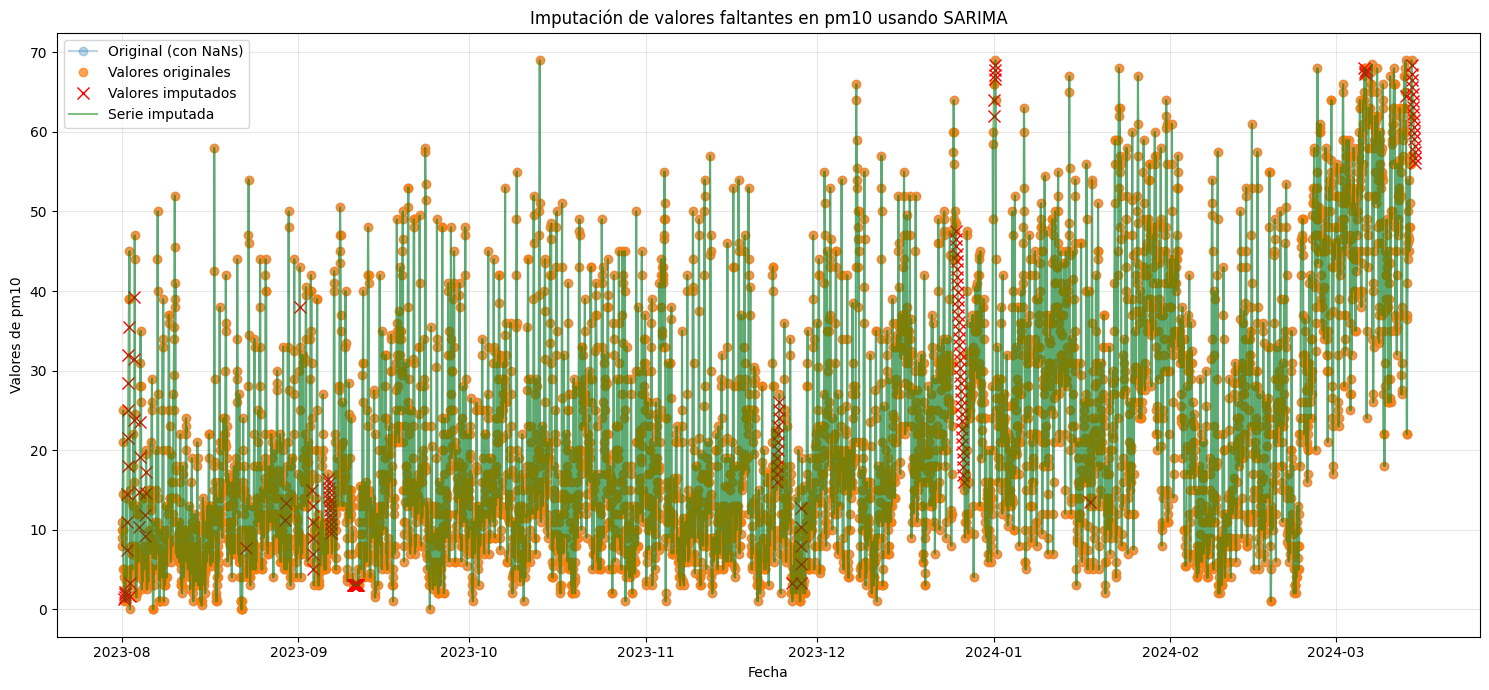

Se encontraron 149 valores faltantes
Usando parámetros SARIMA: (2, 0, 1) x (0, 0, 0, 24)
Imputando secuencia 1 de 23 (4 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 2 de 23 (9 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 3 de 23 (2 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 4 de 23 (3 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 5 de 23 (4 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 6 de 23 (4 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 7 de 23 (1 valores)
Error al imputar valores 

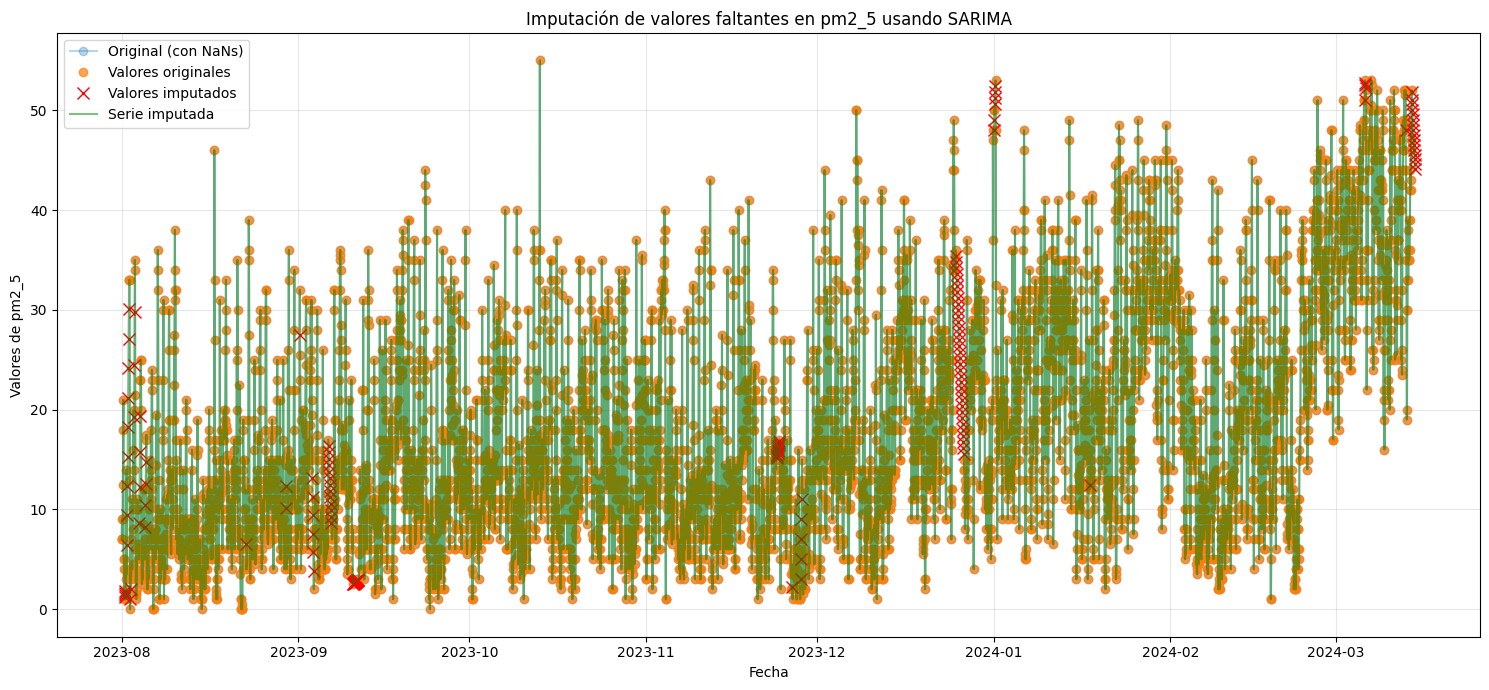

Se encontraron 149 valores faltantes
Usando parámetros SARIMA: (2, 0, 1) x (0, 0, 0, 24)
Imputando secuencia 1 de 23 (4 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 2 de 23 (9 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 3 de 23 (2 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 4 de 23 (3 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 5 de 23 (4 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 6 de 23 (4 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 7 de 23 (1 valores)
Error al imputar valores 

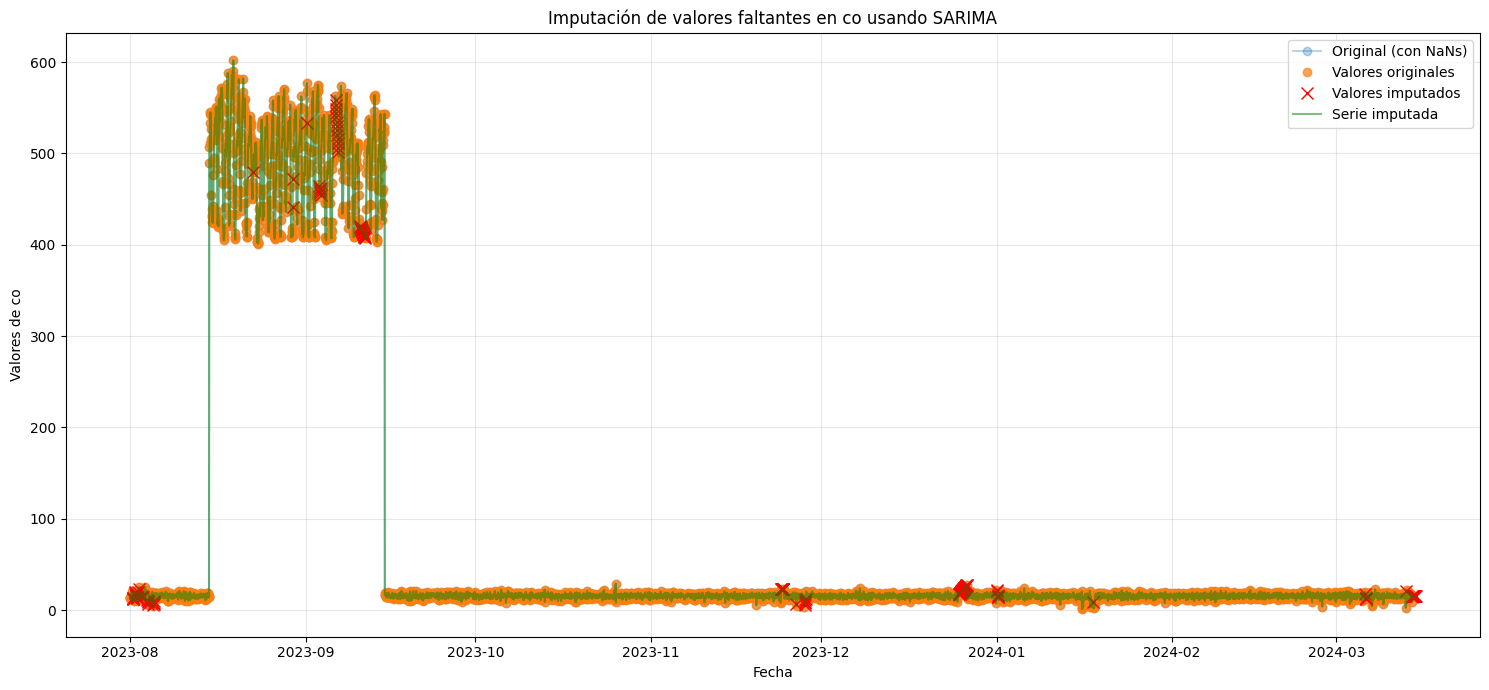

Se encontraron 149 valores faltantes
Usando parámetros SARIMA: (2, 0, 1) x (0, 0, 0, 24)
Imputando secuencia 1 de 23 (4 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 2 de 23 (9 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 3 de 23 (2 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 4 de 23 (3 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 5 de 23 (4 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 6 de 23 (4 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 7 de 23 (1 valores)
Error al imputar valores 

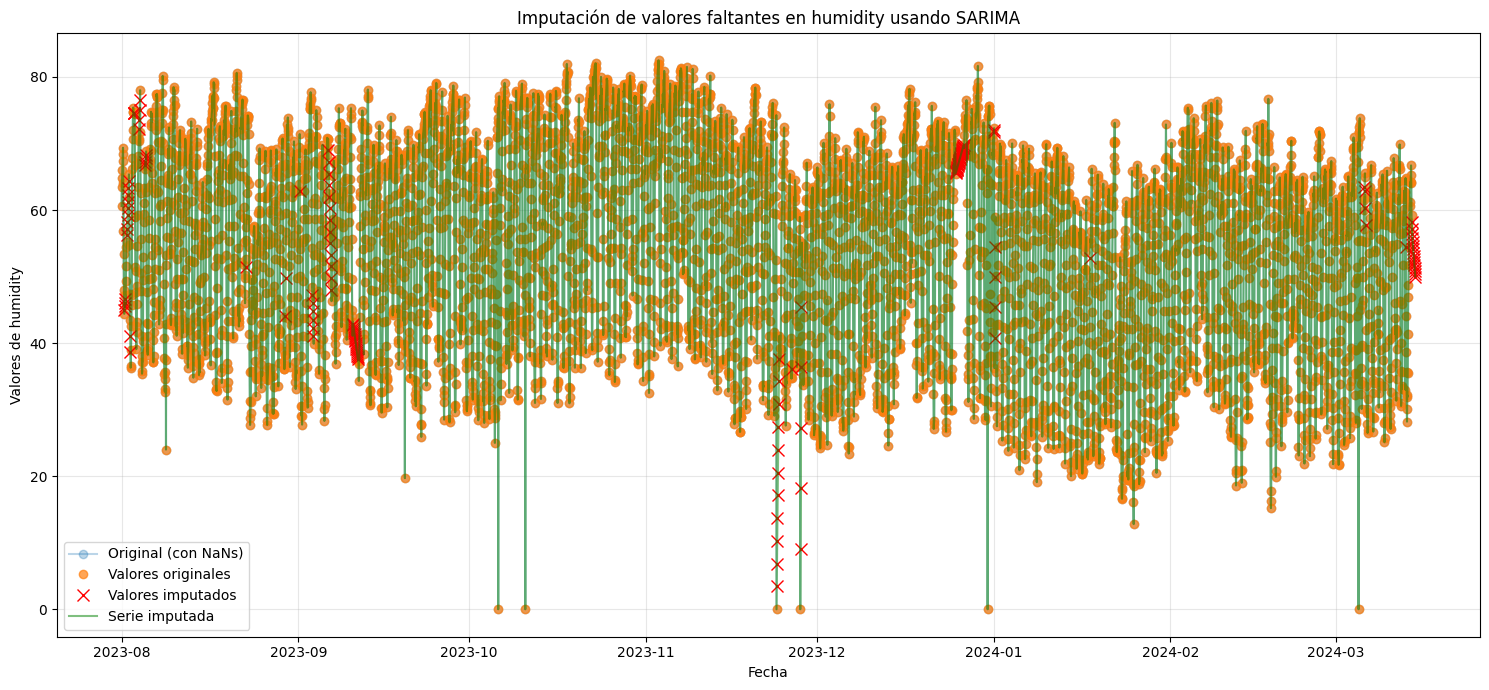

Se encontraron 149 valores faltantes
Usando parámetros SARIMA: (2, 0, 1) x (0, 0, 0, 24)
Imputando secuencia 1 de 23 (4 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 2 de 23 (9 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 3 de 23 (2 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 4 de 23 (3 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 5 de 23 (4 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 6 de 23 (4 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 7 de 23 (1 valores)
Error al imputar valores 

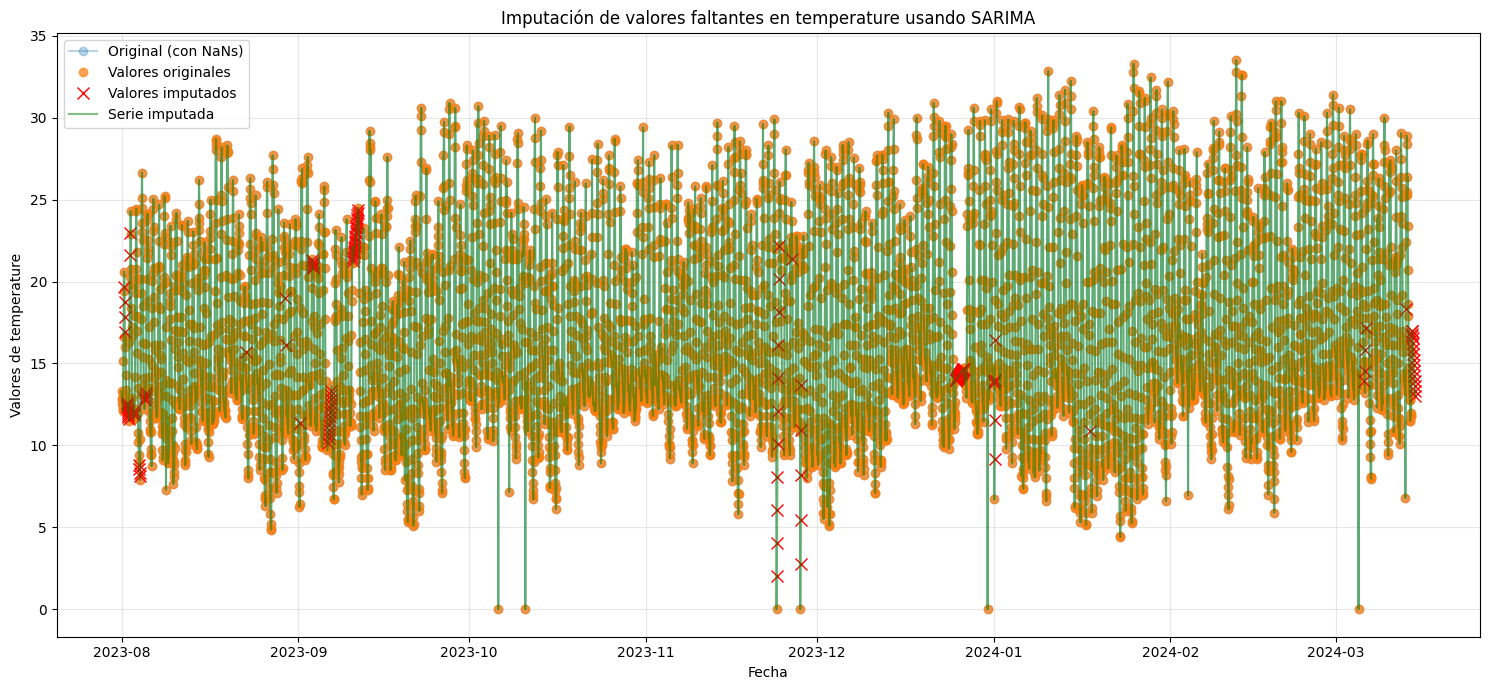

In [109]:
import warnings

# Ocultar warnings específicos por mensaje o categoría:
warnings.filterwarnings("ignore", message="No supported index is available")
warnings.filterwarnings("ignore", message="A date index has been provided")
warnings.filterwarnings("ignore", category=FutureWarning)

DFP_AQ1_CPM10_RR_I = imputar_valores_sarima(DFP_AQ1_CPM10_RR,columna='pm10',order=(2, 0, 1),seasonal_order=(0, 0, 0, 24),plot=True)
DFP_AQ1_CPM10_RR_I = imputar_valores_sarima(DFP_AQ1_CPM10_RR_I,columna='pm2_5',order=(2, 0, 1),seasonal_order=(0, 0, 0, 24),plot=True)
DFP_AQ1_CPM10_RR_I = imputar_valores_sarima(DFP_AQ1_CPM10_RR_I,columna='co',order=(2, 0, 1),seasonal_order=(0, 0, 0, 24),plot=True)
DFP_AQ1_CPM10_RR_I = imputar_valores_sarima(DFP_AQ1_CPM10_RR_I,columna='humidity',order=(2, 0, 1),seasonal_order=(0, 0, 0, 24),plot=True)
DFP_AQ1_CPM10_RR_I = imputar_valores_sarima(DFP_AQ1_CPM10_RR_I,columna='temperature',order=(2, 0, 1),seasonal_order=(0, 0, 0, 24),plot=True)

# 3.2 **RESULTADO SARIMA - DFP_AQ1_CPM10**

In [83]:
dtale.show(DFP_AQ1_CPM10_RR_I)

# 4. **RESAMPLE - DFP_AQ1_CPM2_5**

In [99]:
display(DFP_AQ1_CPM2_5)

pm2_5  pm10  co   o3  humidity  temperature          time_format
0          44    58   2  NaN      60.3         20.3  2024-04-08 18:39:00
1          46    56   3  NaN      60.3         20.3  2024-04-08 18:41:00
2          46    56   4  NaN      60.3         20.3  2024-04-08 18:43:00
3          46    61   5  NaN      60.4         20.3  2024-04-08 18:45:00
4          45    61   6  NaN      60.5         20.3  2024-04-08 18:48:00
...       ...   ...  ..  ...       ...          ...                  ...
181857      3     3  13  1.0      57.3         13.8  2023-07-20 23:49:20
181858      3     3  14  1.0      57.2         13.7  2023-07-20 23:51:25
181859      3     3  15  1.0       0.0          0.0  2023-07-20 23:53:30
181860      3     3  16  1.0      57.1         13.6  2023-07-20 23:55:35
181861      3     3  18  1.0      57.3         13.5  2023-07-20 23:59:42

[177427 rows x 7 columns]

In [100]:
# Asegúrate de que 'time_format' esté en formato datetime
DFP_AQ1_CPM2_5['time_format'] = pd.to_datetime(DFP_AQ1_CPM2_5['time_format'])

# Establecer la columna 'time_format' como índice
DFP_AQ1_CPM2_5.set_index('time_format', inplace=True)

# Resampleo por hora y calcular la media de 'pm10' en cada intervalo
DFP_AQ1_CPM2_5_resampled = DFP_AQ1_CPM2_5.resample('H').median()
DFP_AQ1_CPM2_5_resampled.index = pd.DatetimeIndex(DFP_AQ1_CPM2_5_resampled.index).to_period('H').to_timestamp()
# Mostrar los primeros registros del DataFrame resampleado
print(DFP_AQ1_CPM2_5_resampled.head())

                     pm2_5  pm10    co   o3  humidity  temperature
time_format                                                       
2023-06-28 00:00:00    8.0  13.0  16.0  0.0      75.1         11.4
2023-06-28 01:00:00   18.0  22.0  14.0  0.0      79.6         10.5
2023-06-28 02:00:00   18.0  21.0  15.5  0.0      78.4         11.0
2023-06-28 03:00:00   21.0  26.0  14.0  0.0      81.6          9.7
2023-06-28 04:00:00   20.0  25.0  15.0  0.0      79.3          9.4


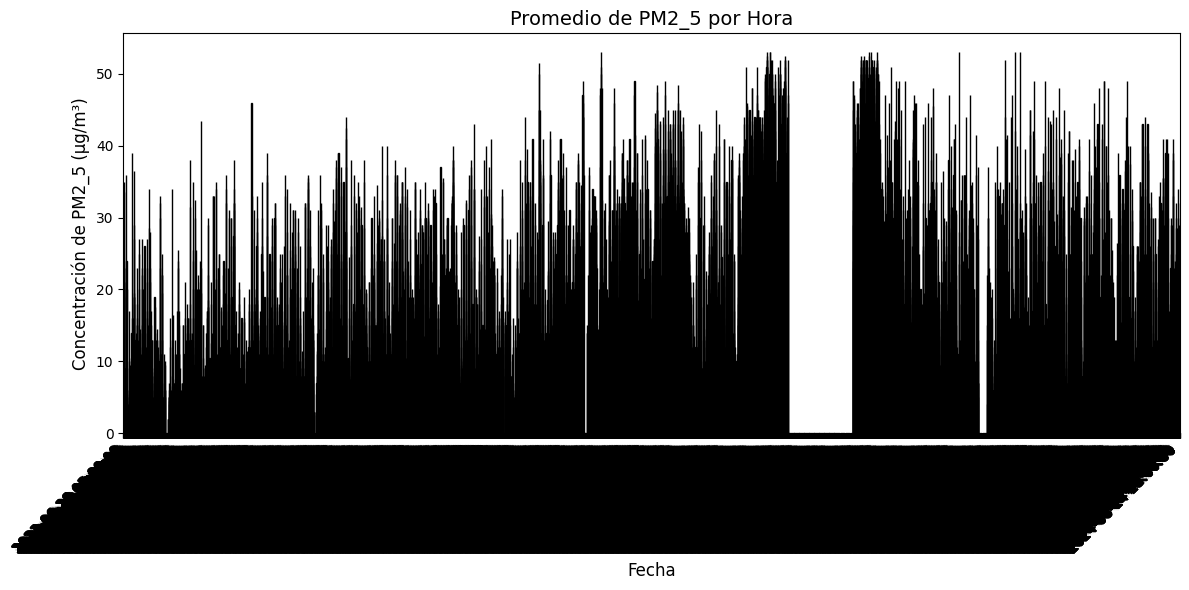

In [93]:
# Asegurarse de que los datos estén correctamente resampleados
# Usamos un gráfico de barras para mostrar las medias de pm10 por hora
plt.figure(figsize=(12, 6))

# Graficar el DataFrame resampleado
DFP_AQ1_CPM2_5_resampled['pm2_5'].plot(kind='bar', color='skyblue', edgecolor='black')

# Añadir título y etiquetas a los ejes
plt.title('Promedio de PM2_5 por Hora', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Concentración de PM2_5 (µg/m³)', fontsize=12)

# Ajustar el formato de las fechas en el eje X para que no se sobrepongan
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [87]:
DFP_AQ1_CPM2_5_resampled.count()

pm2_5          9040
pm10           9040
co             9040
o3              790
humidity       9040
temperature    9040
dtype: int64

In [88]:
df_pm2_5_null = DFP_AQ1_CPM2_5_resampled[DFP_AQ1_CPM2_5_resampled['pm2_5'].isnull()]
# Mostrar el resultado
print(df_pm2_5_null)

                     pm2_5  pm10  co  o3  humidity  temperature
time_format                                                    
2023-07-13 20:00:00    NaN   NaN NaN NaN       NaN          NaN
2023-07-13 21:00:00    NaN   NaN NaN NaN       NaN          NaN
2023-07-13 22:00:00    NaN   NaN NaN NaN       NaN          NaN
2023-07-13 23:00:00    NaN   NaN NaN NaN       NaN          NaN
2023-07-14 00:00:00    NaN   NaN NaN NaN       NaN          NaN
...                    ...   ...  ..  ..       ...          ...
2024-06-06 17:00:00    NaN   NaN NaN NaN       NaN          NaN
2024-06-06 18:00:00    NaN   NaN NaN NaN       NaN          NaN
2024-06-26 16:00:00    NaN   NaN NaN NaN       NaN          NaN
2024-06-26 17:00:00    NaN   NaN NaN NaN       NaN          NaN
2024-07-23 07:00:00    NaN   NaN NaN NaN       NaN          NaN

[896 rows x 6 columns]


# 4.1 **IDENTIFICAR MEJOR INTERVALOR - DFP_AQ1_CPM2_5**

# 1 .Identificar intervalos continuos:
# - Una vez que tengas la serie de conteo diario, puedes detectar “intervalos” (periodos consecutivos sin saltos de días) y sumar los registros de cada uno. Finalmente, se selecciona los dos intervalos con mayor cantidad total de datos.

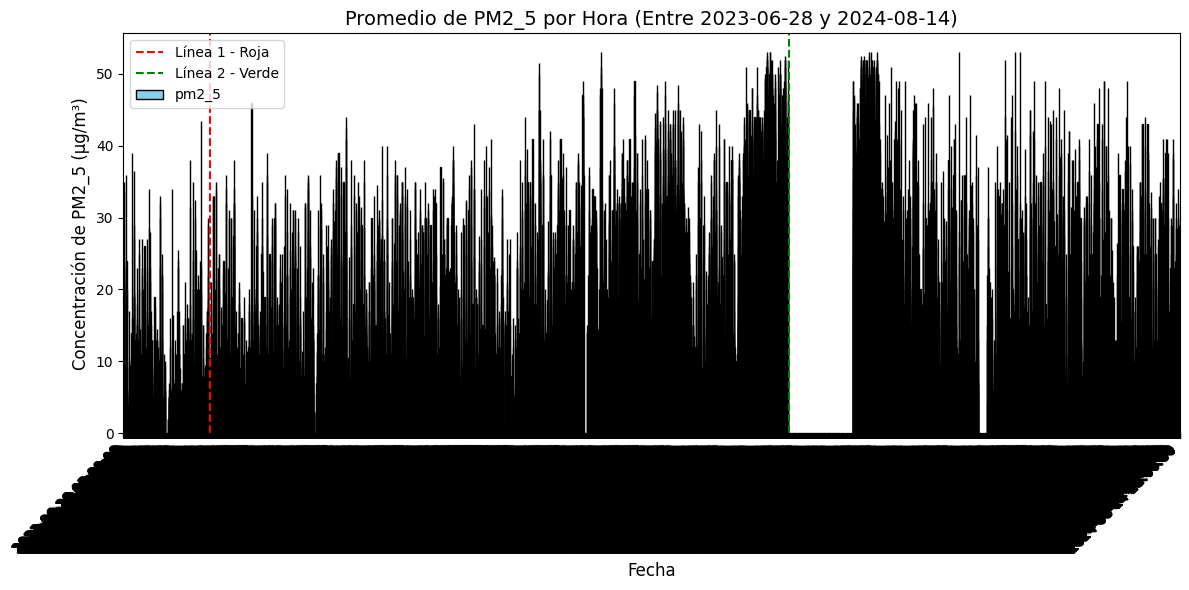

In [89]:
# Filtrar los datos entre el intervalo de fechas especificado
start_date = '2023-06-28 00:00:00'
end_date = '2024-08-14 23:00:00'

# Filtrar el DataFrame para que solo contenga los datos dentro del rango de fechas
DFP_AQ1_CPM2_5_resampled_filter = DFP_AQ1_CPM2_5_resampled[(DFP_AQ1_CPM2_5_resampled.index >= start_date) & (DFP_AQ1_CPM2_5_resampled.index <= end_date)]

# Asegurarse de que los datos estén correctamente resampleados
# Usamos un gráfico de barras para mostrar las medias de pm10 por hora
plt.figure(figsize=(12, 6))

# Graficar el DataFrame resampleado filtrado
DFP_AQ1_CPM2_5_resampled_filter['pm2_5'].plot(kind='bar', color='skyblue', edgecolor='black')

# Añadir título y etiquetas a los ejes
plt.title('Promedio de PM2_5 por Hora (Entre 2023-06-28 y 2024-08-14)', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Concentración de PM2_5 (µg/m³)', fontsize=12)

# Ajustar el formato de las fechas en el eje X para que no se sobrepongan
plt.xticks(rotation=45, ha='right')

# Fechas en las que se quiere agregar las líneas verticales
date_1 = pd.to_datetime('2023-08-01 00:00:00')
date_2 = pd.to_datetime('2024-03-15 00:00:00')

# Convertir las fechas a posiciones en el eje X
date_1_pos_AQ1_CPM2_5 = DFP_AQ1_CPM2_5_resampled_filter.index.get_loc(date_1)
date_2_pos_AQ1_CPM2_5 = DFP_AQ1_CPM2_5_resampled_filter.index.get_loc(date_2)

# Agregar las líneas verticales
plt.axvline(x=date_1_pos_AQ1_CPM2_5, color='red', linestyle='--', label='Línea 1 - Roja')  # Línea roja
plt.axvline(x=date_2_pos_AQ1_CPM2_5, color='green', linestyle='--', label='Línea 2 - Verde')  # Línea verde

# Mostrar leyenda
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


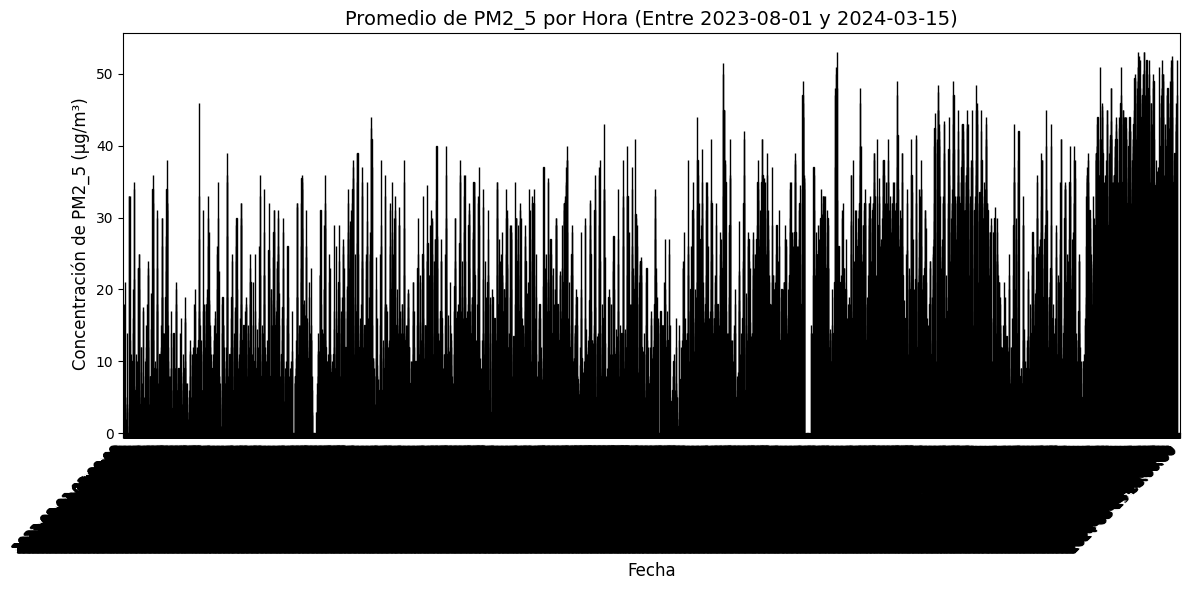

In [90]:
# Filtrar los datos entre el intervalo de fechas especificado
start_date = '2023-08-01 00:00:00'
end_date = '2024-03-15 00:00:00'

# Filtrar el DataFrame para que solo contenga los datos dentro del rango de fechas
DFP_AQ1_CPM2_5_RR = DFP_AQ1_CPM2_5_resampled[(DFP_AQ1_CPM2_5_resampled.index >= start_date) & (DFP_AQ1_CPM2_5_resampled.index <= end_date)]

# Asegurarse de que los datos estén correctamente resampleados
# Usamos un gráfico de barras para mostrar las medias de pm10 por hora
plt.figure(figsize=(12, 6))

# Graficar el DataFrame resampleado filtrado
DFP_AQ1_CPM2_5_RR['pm2_5'].plot(kind='bar', color='skyblue', edgecolor='black')

# Añadir título y etiquetas a los ejes
plt.title('Promedio de PM2_5 por Hora (Entre 2023-08-01 y 2024-03-15)', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Concentración de PM2_5 (µg/m³)', fontsize=12)

# Ajustar el formato de las fechas en el eje X para que no se sobrepongan
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [91]:
dtale.show(DFP_AQ1_CPM2_5_RR)

Se encontraron 147 valores faltantes
Usando parámetros SARIMA: (1, 1, 1) x (1, 1, 1, 24)
Imputando secuencia 1 de 22 (4 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 2 de 22 (9 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 3 de 22 (2 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 4 de 22 (3 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 5 de 22 (4 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 6 de 22 (4 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 7 de 22 (1 valores)
Error al imputar valores 

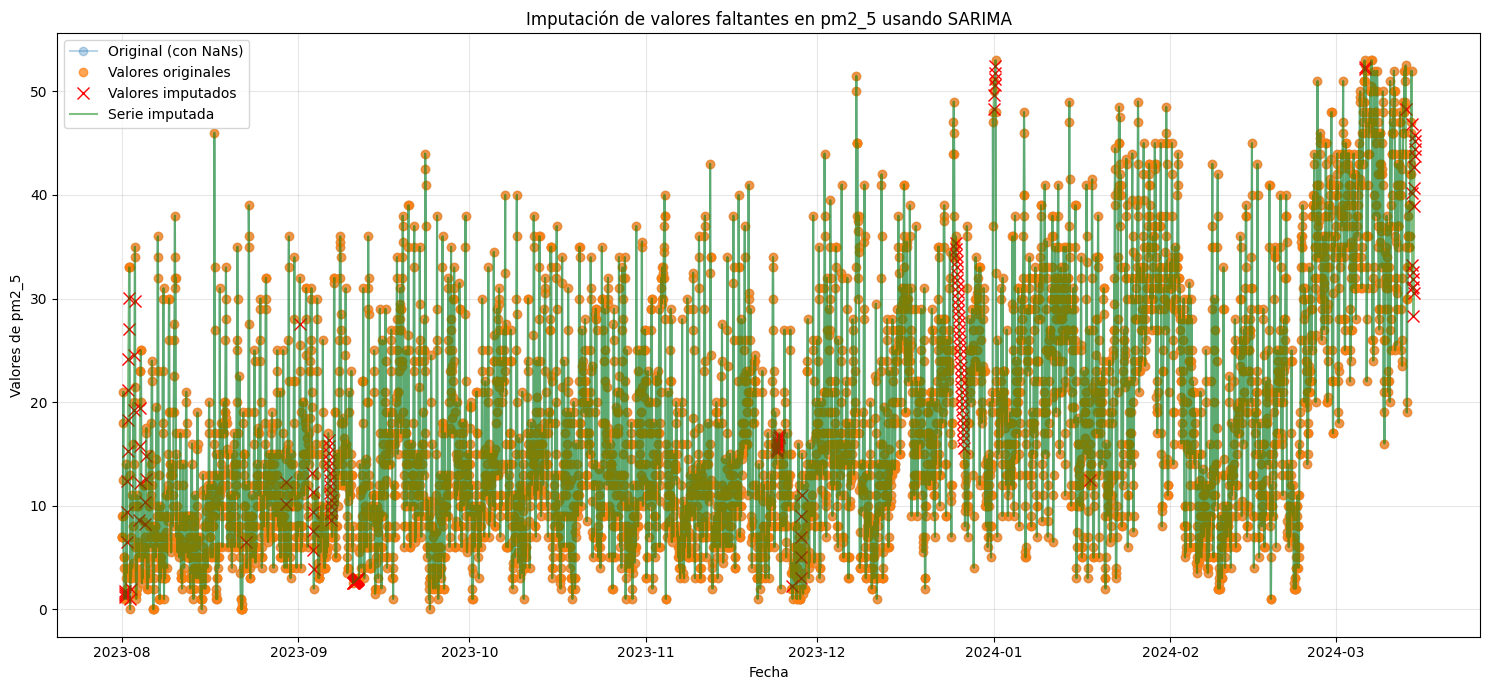

In [92]:
import warnings

# Ocultar warnings específicos por mensaje o categoría:
warnings.filterwarnings("ignore", message="No supported index is available")
warnings.filterwarnings("ignore", message="A date index has been provided")
warnings.filterwarnings("ignore", category=FutureWarning)
DFP_AQ1_CPM2_5_RR_I = imputar_valores_sarima(DFP_AQ1_CPM2_5_RR,columna='pm2_5')

# 4.2 **RESULTADO SARIMA - DFP_AQ1_CPM2_5**

In [93]:
dtale.show(DFP_AQ1_CPM2_5_RR_I)

# 5. **RESAMPLE - DFP_AQ2_CPM2_5**

In [94]:
display(DFP_AQ2_CPM2_5)

pm2_5  pm10  co   o3  humidity  temperature          time_format
0          39    45   1  NaN      78.0         19.0  2024-04-08 20:18:00
1          42    54   2  NaN      78.1         19.3  2024-04-08 20:20:00
2          40    47   1  NaN      72.0         20.3  2024-04-08 20:46:00
3          45    59   2  NaN      71.1         20.4  2024-04-08 20:48:00
4          44    56   4  NaN      69.5         20.5  2024-04-08 20:53:00
...       ...   ...  ..  ...       ...          ...                  ...
148497      8     8  21  1.0      67.0         12.4  2023-07-20 23:39:18
148498     11    13  23  1.0      67.3         12.4  2023-07-20 23:43:24
148499     10    13  24  1.0      67.4         12.4  2023-07-20 23:45:29
148500      4     4  29  1.0      67.5         12.6  2023-07-20 23:55:46
148501      5     5  30  1.0      67.5         12.5  2023-07-20 23:57:50

[143356 rows x 7 columns]

In [95]:
# Asegúrate de que 'time_format' esté en formato datetime
DFP_AQ2_CPM2_5['time_format'] = pd.to_datetime(DFP_AQ2_CPM2_5['time_format'])

# Establecer la columna 'time_format' como índice
DFP_AQ2_CPM2_5.set_index('time_format', inplace=True)

# Resampleo por hora y calcular la media de 'pm10' en cada intervalo
DFP_AQ2_CPM2_5_resampled = DFP_AQ2_CPM2_5.resample('H').median()
DFP_AQ2_CPM2_5_resampled.index = pd.DatetimeIndex(DFP_AQ2_CPM2_5_resampled.index).to_period('H').to_timestamp()
# Mostrar los primeros registros del DataFrame resampleado
print(DFP_AQ2_CPM2_5_resampled.head())

                     pm2_5  pm10    co   o3  humidity  temperature
time_format                                                       
2023-06-28 00:00:00   13.0  22.5  15.5  0.0      81.2        11.05
2023-06-28 01:00:00   10.0  13.0  12.5  0.0      83.9        10.90
2023-06-28 02:00:00   11.0  13.0  14.0  0.0      83.7        10.20
2023-06-28 03:00:00   13.0  21.0  17.0  0.0      85.7        10.30
2023-06-28 04:00:00   17.0  24.0  14.0  0.0      85.6        10.10


/tmp/ipykernel_160929/1976893153.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



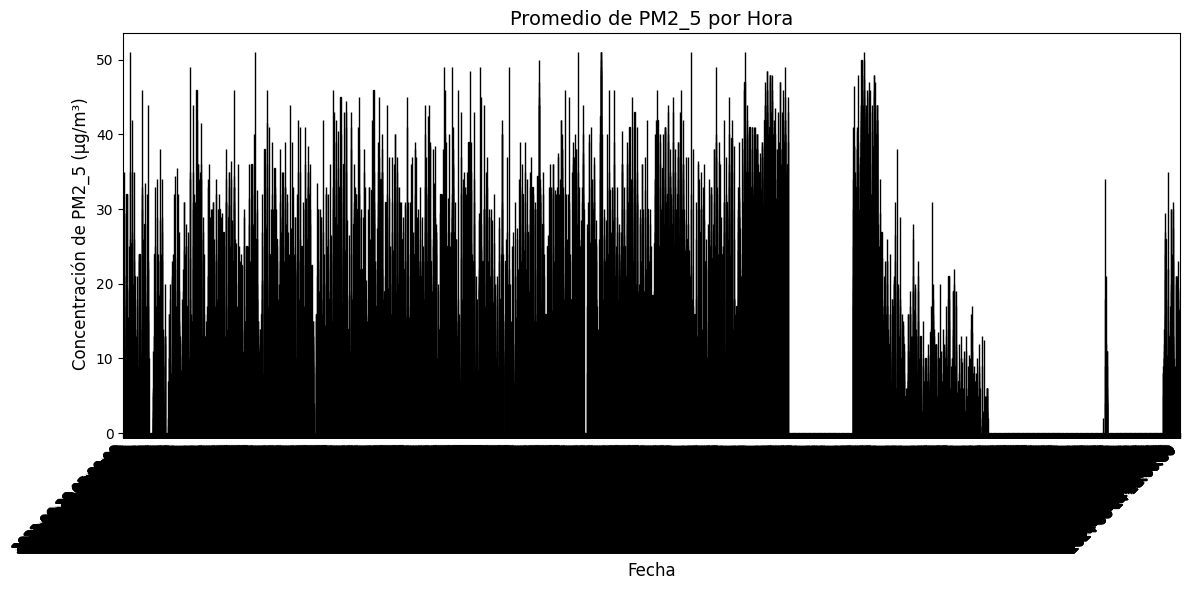

In [96]:
# Asegurarse de que los datos estén correctamente resampleados
# Usamos un gráfico de barras para mostrar las medias de pm10 por hora
plt.figure(figsize=(12, 6))

# Graficar el DataFrame resampleado
DFP_AQ2_CPM2_5_resampled['pm2_5'].plot(kind='bar', color='skyblue', edgecolor='black')

# Añadir título y etiquetas a los ejes
plt.title('Promedio de PM2_5 por Hora', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Concentración de PM2_5 (µg/m³)', fontsize=12)

# Ajustar el formato de las fechas en el eje X para que no se sobrepongan
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [97]:
DFP_AQ2_CPM2_5_resampled.count()

pm2_5          7435
pm10           7435
co             7435
o3              752
humidity       7435
temperature    7435
dtype: int64

In [98]:
df_pm2_5_AQ2_null = DFP_AQ2_CPM2_5_resampled[DFP_AQ2_CPM2_5_resampled['pm2_5'].isnull()]
# Mostrar el resultado
print(df_pm2_5_AQ2_null)

                     pm2_5  pm10  co  o3  humidity  temperature
time_format                                                    
2023-07-07 23:00:00    NaN   NaN NaN NaN       NaN          NaN
2023-07-08 00:00:00    NaN   NaN NaN NaN       NaN          NaN
2023-07-08 01:00:00    NaN   NaN NaN NaN       NaN          NaN
2023-07-08 02:00:00    NaN   NaN NaN NaN       NaN          NaN
2023-07-08 03:00:00    NaN   NaN NaN NaN       NaN          NaN
...                    ...   ...  ..  ..       ...          ...
2024-08-08 04:00:00    NaN   NaN NaN NaN       NaN          NaN
2024-08-08 05:00:00    NaN   NaN NaN NaN       NaN          NaN
2024-08-08 06:00:00    NaN   NaN NaN NaN       NaN          NaN
2024-08-08 07:00:00    NaN   NaN NaN NaN       NaN          NaN
2024-08-08 08:00:00    NaN   NaN NaN NaN       NaN          NaN

[2501 rows x 6 columns]


# 5.1 **IDENTIFICAR MEJOR INTERVALOR - DFP_AQ2_CPM2_5**

# 1 .Identificar intervalos continuos:
# - Una vez que tengas la serie de conteo diario, puedes detectar “intervalos” (periodos consecutivos sin saltos de días) y sumar los registros de cada uno. Finalmente, se selecciona los dos intervalos con mayor cantidad total de datos.

/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/air_quality/env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



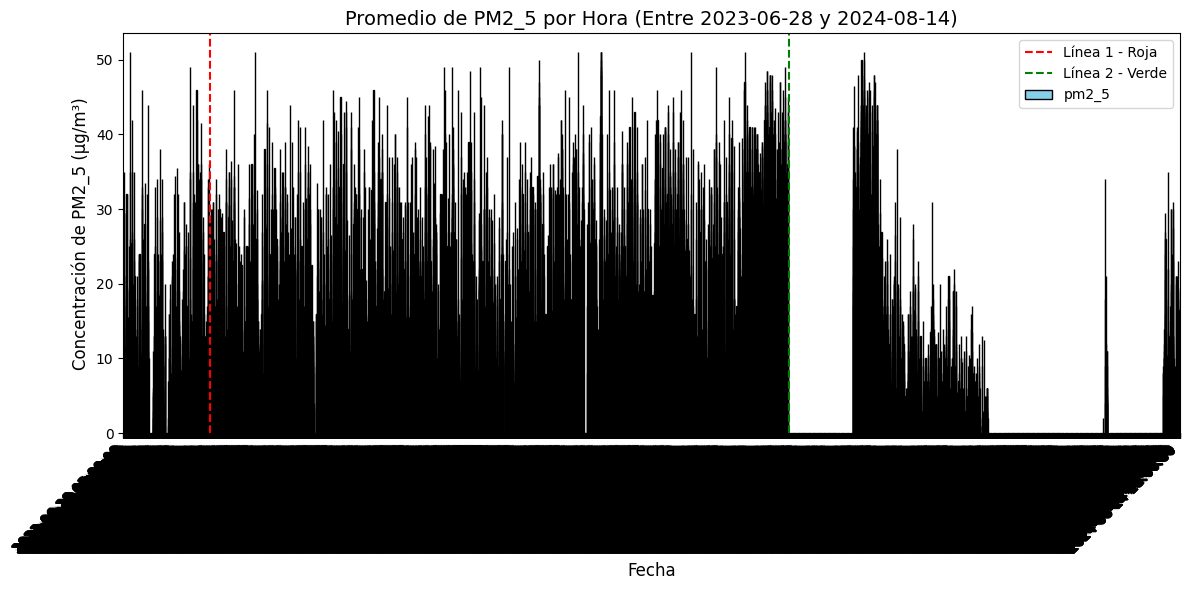

In [99]:
# Filtrar los datos entre el intervalo de fechas especificado
start_date = '2023-06-28 00:00:00'
end_date = '2024-08-14 23:00:00'

# Filtrar el DataFrame para que solo contenga los datos dentro del rango de fechas
DFP_AQ2_CPM2_5_resampled_filter = DFP_AQ2_CPM2_5_resampled[(DFP_AQ2_CPM2_5_resampled.index >= start_date) & (DFP_AQ2_CPM2_5_resampled.index <= end_date)]

# Asegurarse de que los datos estén correctamente resampleados
# Usamos un gráfico de barras para mostrar las medias de pm10 por hora
plt.figure(figsize=(12, 6))

# Graficar el DataFrame resampleado filtrado
DFP_AQ2_CPM2_5_resampled_filter['pm2_5'].plot(kind='bar', color='skyblue', edgecolor='black')

# Añadir título y etiquetas a los ejes
plt.title('Promedio de PM2_5 por Hora (Entre 2023-06-28 y 2024-08-14)', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Concentración de PM2_5 (µg/m³)', fontsize=12)

# Ajustar el formato de las fechas en el eje X para que no se sobrepongan
plt.xticks(rotation=45, ha='right')

# Fechas en las que se quiere agregar las líneas verticales
date_1 = pd.to_datetime('2023-08-01 00:00:00')
date_2 = pd.to_datetime('2024-03-15 00:00:00')

# Convertir las fechas a posiciones en el eje X
date_1_pos_AQ2_CPM2_5 = DFP_AQ2_CPM2_5_resampled_filter.index.get_loc(date_1)
date_2_pos_AQ2_CPM2_5 = DFP_AQ2_CPM2_5_resampled_filter.index.get_loc(date_2)

# Agregar las líneas verticales
plt.axvline(x=date_1_pos_AQ2_CPM2_5, color='red', linestyle='--', label='Línea 1 - Roja')  # Línea roja
plt.axvline(x=date_2_pos_AQ2_CPM2_5, color='green', linestyle='--', label='Línea 2 - Verde')  # Línea verde

# Mostrar leyenda
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


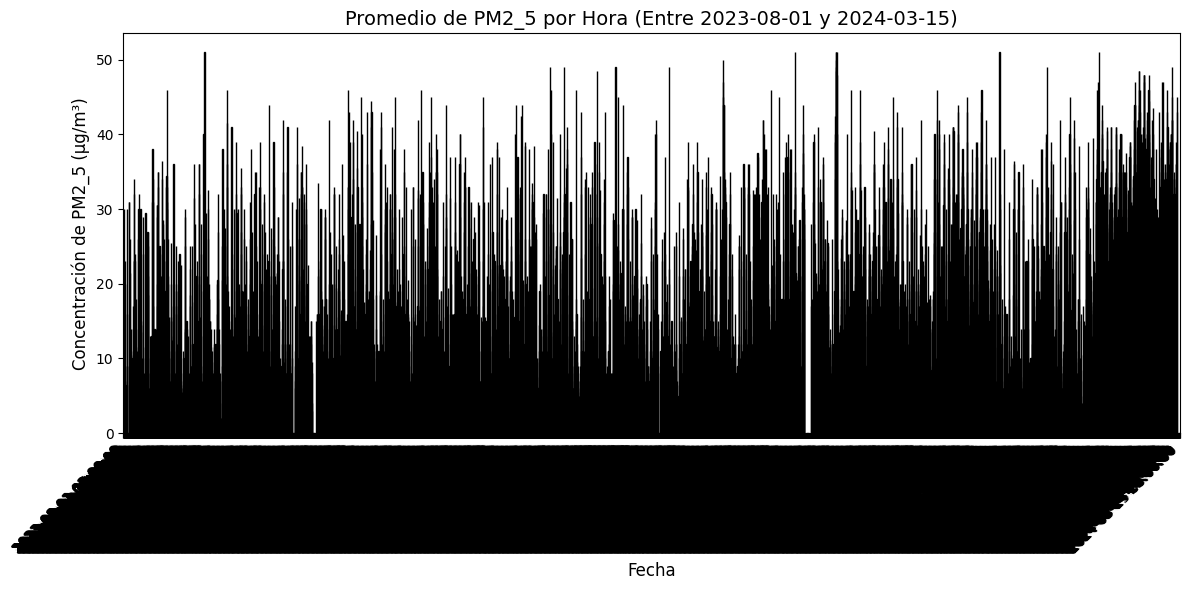

In [100]:
# Filtrar los datos entre el intervalo de fechas especificado
start_date = '2023-08-01 00:00:00'
end_date = '2024-03-15 00:00:00'

# Filtrar el DataFrame para que solo contenga los datos dentro del rango de fechas
DFP_AQ2_CPM2_5_RR = DFP_AQ2_CPM2_5_resampled[(DFP_AQ2_CPM2_5_resampled.index >= start_date) & (DFP_AQ2_CPM2_5_resampled.index <= end_date)]

# Asegurarse de que los datos estén correctamente resampleados
# Usamos un gráfico de barras para mostrar las medias de pm10 por hora
plt.figure(figsize=(12, 6))

# Graficar el DataFrame resampleado filtrado
DFP_AQ2_CPM2_5_RR['pm2_5'].plot(kind='bar', color='skyblue', edgecolor='black')

# Añadir título y etiquetas a los ejes
plt.title('Promedio de PM2_5 por Hora (Entre 2023-08-01 y 2024-03-15)', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Concentración de PM2_5 (µg/m³)', fontsize=12)

# Ajustar el formato de las fechas en el eje X para que no se sobrepongan
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [101]:
dtale.show(DFP_AQ2_CPM2_5_RR)

Se encontraron 145 valores faltantes
Usando parámetros SARIMA: (1, 1, 1) x (1, 1, 1, 24)
Imputando secuencia 1 de 24 (4 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 2 de 24 (9 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 3 de 24 (2 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 4 de 24 (3 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 5 de 24 (4 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 6 de 24 (4 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 7 de 24 (1 valores)
Error al imputar valores 

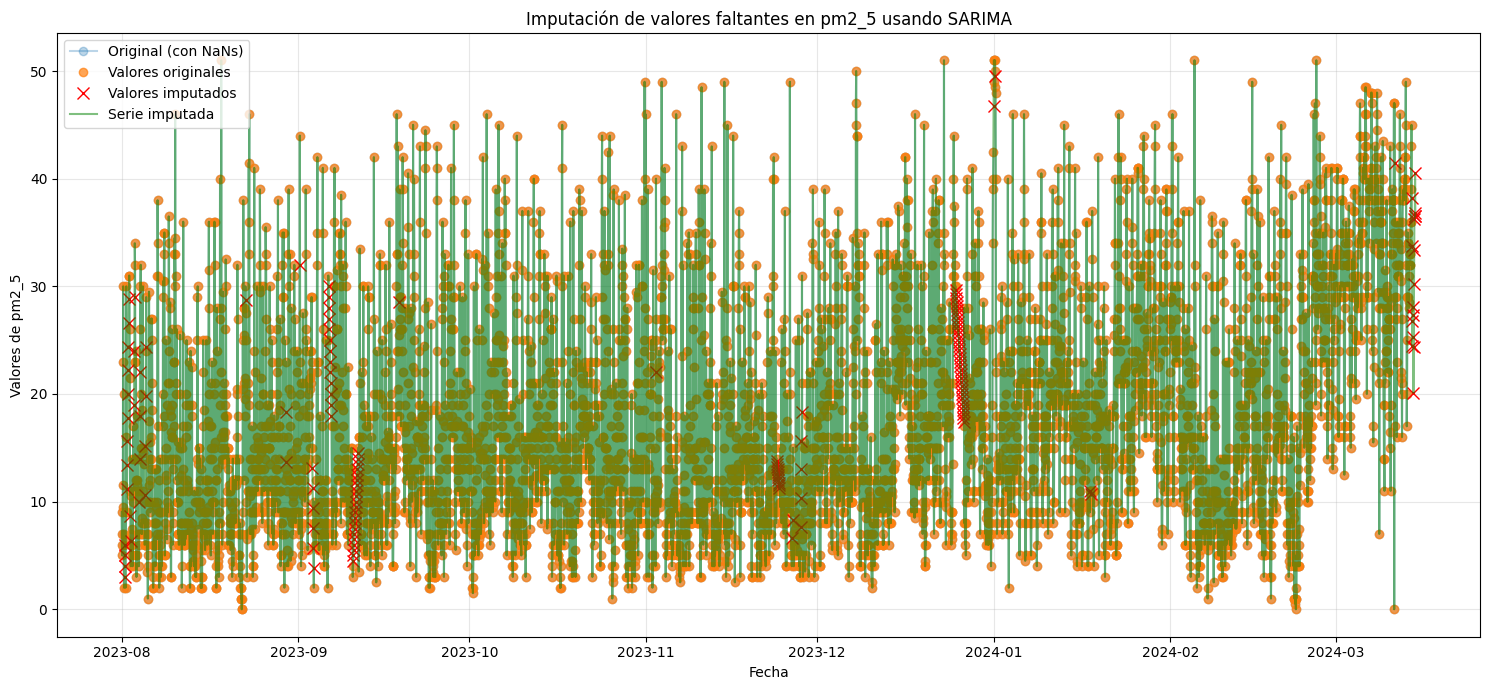

In [102]:
import warnings

# Ocultar warnings específicos por mensaje o categoría:
warnings.filterwarnings("ignore", message="No supported index is available")
warnings.filterwarnings("ignore", message="A date index has been provided")
warnings.filterwarnings("ignore", category=FutureWarning)
DFP_AQ2_CPM2_5_RR_I = imputar_valores_sarima(DFP_AQ2_CPM2_5_RR,columna='pm2_5')

# 5.2 **RESULTADO SARIMA - DFP_AQ2_CPM2_5**

In [103]:
dtale.show(DFP_AQ2_CPM2_5_RR_I)

# 6. **RESAMPLE - DFP_AQ2_CPM10**

In [104]:
display(DFP_AQ2_CPM10)

pm2_5  pm10  co   o3  humidity  temperature          time_format
0          39    45   1  NaN      78.0         19.0  2024-04-08 20:18:00
1          42    54   2  NaN      78.1         19.3  2024-04-08 20:20:00
2          40    47   1  NaN      72.0         20.3  2024-04-08 20:46:00
3          45    59   2  NaN      71.1         20.4  2024-04-08 20:48:00
4          44    56   4  NaN      69.5         20.5  2024-04-08 20:53:00
...       ...   ...  ..  ...       ...          ...                  ...
148497      8     8  21  1.0      67.0         12.4  2023-07-20 23:39:18
148498     11    13  23  1.0      67.3         12.4  2023-07-20 23:43:24
148499     10    13  24  1.0      67.4         12.4  2023-07-20 23:45:29
148500      4     4  29  1.0      67.5         12.6  2023-07-20 23:55:46
148501      5     5  30  1.0      67.5         12.5  2023-07-20 23:57:50

[142572 rows x 7 columns]

In [105]:
# Asegúrate de que 'time_format' esté en formato datetime
DFP_AQ2_CPM10['time_format'] = pd.to_datetime(DFP_AQ2_CPM10['time_format'])

# Establecer la columna 'time_format' como índice
DFP_AQ2_CPM10.set_index('time_format', inplace=True)

# Resampleo por hora y calcular la media de 'pm10' en cada intervalo
DFP_AQ2_CPM10_resampled = DFP_AQ2_CPM10.resample('H').median()
DFP_AQ2_CPM10_resampled.index = pd.DatetimeIndex(DFP_AQ2_CPM10_resampled.index).to_period('H').to_timestamp()
# Mostrar los primeros registros del DataFrame resampleado
print(DFP_AQ2_CPM10_resampled.head())

                     pm2_5  pm10    co   o3  humidity  temperature
time_format                                                       
2023-06-28 00:00:00   13.0  22.5  15.5  0.0      81.2        11.05
2023-06-28 01:00:00   10.0  13.0  12.5  0.0      83.9        10.90
2023-06-28 02:00:00   11.0  13.0  14.0  0.0      83.7        10.20
2023-06-28 03:00:00   13.0  21.0  17.0  0.0      85.7        10.30
2023-06-28 04:00:00   17.0  24.0  14.0  0.0      85.6        10.10


/tmp/ipykernel_160929/1928458388.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [106]:
df_AQ2_pm10_null = DFP_AQ2_CPM10_resampled[DFP_AQ2_CPM10_resampled['pm10'].isnull()]
# Mostrar el resultado
print(df_AQ2_pm10_null)

                     pm2_5  pm10  co  o3  humidity  temperature
time_format                                                    
2023-07-07 23:00:00    NaN   NaN NaN NaN       NaN          NaN
2023-07-08 00:00:00    NaN   NaN NaN NaN       NaN          NaN
2023-07-08 01:00:00    NaN   NaN NaN NaN       NaN          NaN
2023-07-08 02:00:00    NaN   NaN NaN NaN       NaN          NaN
2023-07-08 03:00:00    NaN   NaN NaN NaN       NaN          NaN
...                    ...   ...  ..  ..       ...          ...
2024-08-08 04:00:00    NaN   NaN NaN NaN       NaN          NaN
2024-08-08 05:00:00    NaN   NaN NaN NaN       NaN          NaN
2024-08-08 06:00:00    NaN   NaN NaN NaN       NaN          NaN
2024-08-08 07:00:00    NaN   NaN NaN NaN       NaN          NaN
2024-08-08 08:00:00    NaN   NaN NaN NaN       NaN          NaN

[2503 rows x 6 columns]


# 6.1 **IDENTIFICAR MEJOR INTERVALOR - DFP_AQ2_CPM10**

# 1 .Identificar intervalos continuos:
# - Una vez que tengas la serie de conteo diario, puedes detectar “intervalos” (periodos consecutivos sin saltos de días) y sumar los registros de cada uno. Finalmente, se selecciona los dos intervalos con mayor cantidad total de datos.

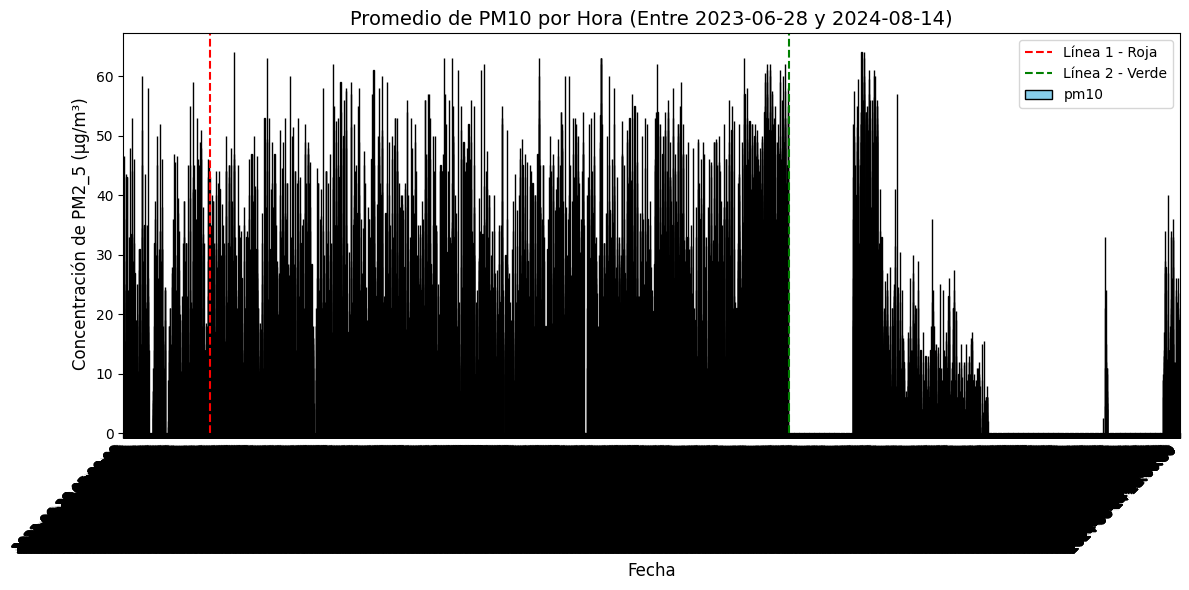

In [107]:
# Filtrar los datos entre el intervalo de fechas especificado
start_date = '2023-06-28 00:00:00'
end_date = '2024-08-14 23:00:00'

# Filtrar el DataFrame para que solo contenga los datos dentro del rango de fechas
DFP_AQ2_CPM10_resampled_filter = DFP_AQ2_CPM10_resampled[(DFP_AQ2_CPM10_resampled.index >= start_date) & (DFP_AQ2_CPM10_resampled.index <= end_date)]

# Asegurarse de que los datos estén correctamente resampleados
# Usamos un gráfico de barras para mostrar las medias de pm10 por hora
plt.figure(figsize=(12, 6))

# Graficar el DataFrame resampleado filtrado
DFP_AQ2_CPM10_resampled_filter['pm10'].plot(kind='bar', color='skyblue', edgecolor='black')

# Añadir título y etiquetas a los ejes
plt.title('Promedio de PM10 por Hora (Entre 2023-06-28 y 2024-08-14)', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Concentración de PM2_5 (µg/m³)', fontsize=12)

# Ajustar el formato de las fechas en el eje X para que no se sobrepongan
plt.xticks(rotation=45, ha='right')

# Fechas en las que se quiere agregar las líneas verticales
date_1 = pd.to_datetime('2023-08-01 00:00:00')
date_2 = pd.to_datetime('2024-03-15 00:00:00')

# Convertir las fechas a posiciones en el eje X
date_1_pos_AQ2_CPM10 = DFP_AQ2_CPM10_resampled_filter.index.get_loc(date_1)
date_2_pos_AQ2_CPM10 = DFP_AQ2_CPM10_resampled_filter.index.get_loc(date_2)

# Agregar las líneas verticales
plt.axvline(x=date_1_pos_AQ2_CPM10, color='red', linestyle='--', label='Línea 1 - Roja')  # Línea roja
plt.axvline(x=date_2_pos_AQ2_CPM10, color='green', linestyle='--', label='Línea 2 - Verde')  # Línea verde

# Mostrar leyenda
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


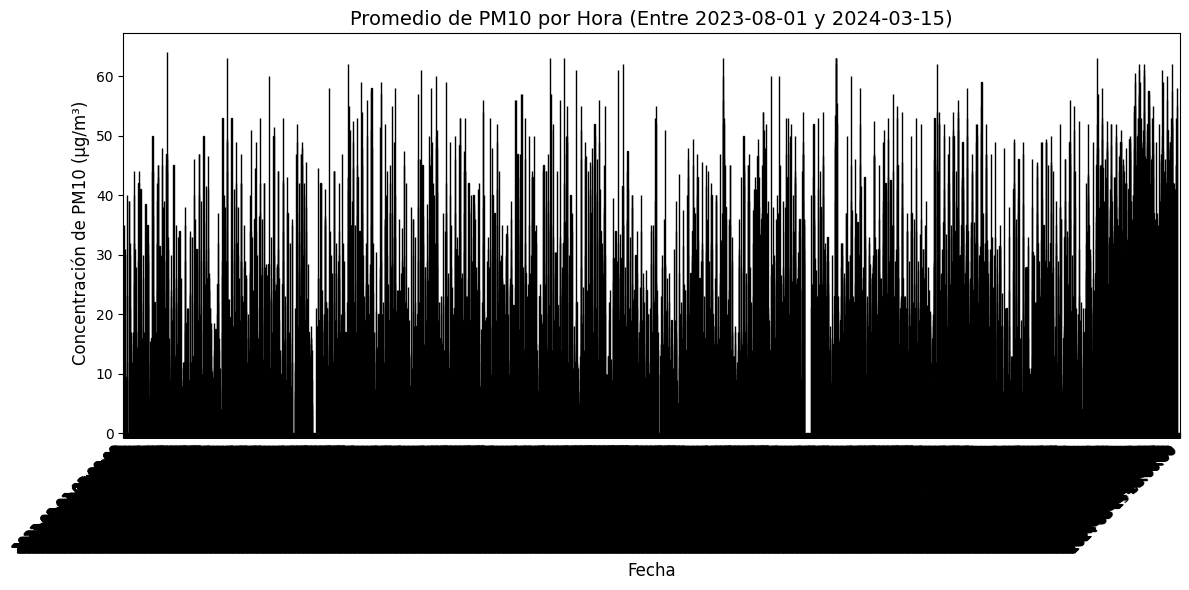

In [108]:
# Filtrar los datos entre el intervalo de fechas especificado
start_date = '2023-08-01 00:00:00'
end_date = '2024-03-15 00:00:00'

# Filtrar el DataFrame para que solo contenga los datos dentro del rango de fechas
DFP_AQ2_CPM10_RR = DFP_AQ2_CPM10_resampled[(DFP_AQ2_CPM10_resampled.index >= start_date) & (DFP_AQ2_CPM10_resampled.index <= end_date)]

# Asegurarse de que los datos estén correctamente resampleados
# Usamos un gráfico de barras para mostrar las medias de pm10 por hora
plt.figure(figsize=(12, 6))

# Graficar el DataFrame resampleado filtrado
DFP_AQ2_CPM10_RR['pm10'].plot(kind='bar', color='skyblue', edgecolor='black')

# Añadir título y etiquetas a los ejes
plt.title('Promedio de PM10 por Hora (Entre 2023-08-01 y 2024-03-15)', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Concentración de PM10 (µg/m³)', fontsize=12)

# Ajustar el formato de las fechas en el eje X para que no se sobrepongan
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [109]:
dtale.show(DFP_AQ2_CPM10_RR)

Se encontraron 147 valores faltantes
Usando parámetros SARIMA: (1, 1, 1) x (1, 1, 1, 24)
Imputando secuencia 1 de 24 (4 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 2 de 24 (9 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 3 de 24 (2 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 4 de 24 (3 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 5 de 24 (4 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 6 de 24 (4 valores)
Error al imputar valores intermedios: 0
Usando interpolación lineal para imputar valores intermedios
Imputando secuencia 7 de 24 (1 valores)
Error al imputar valores 

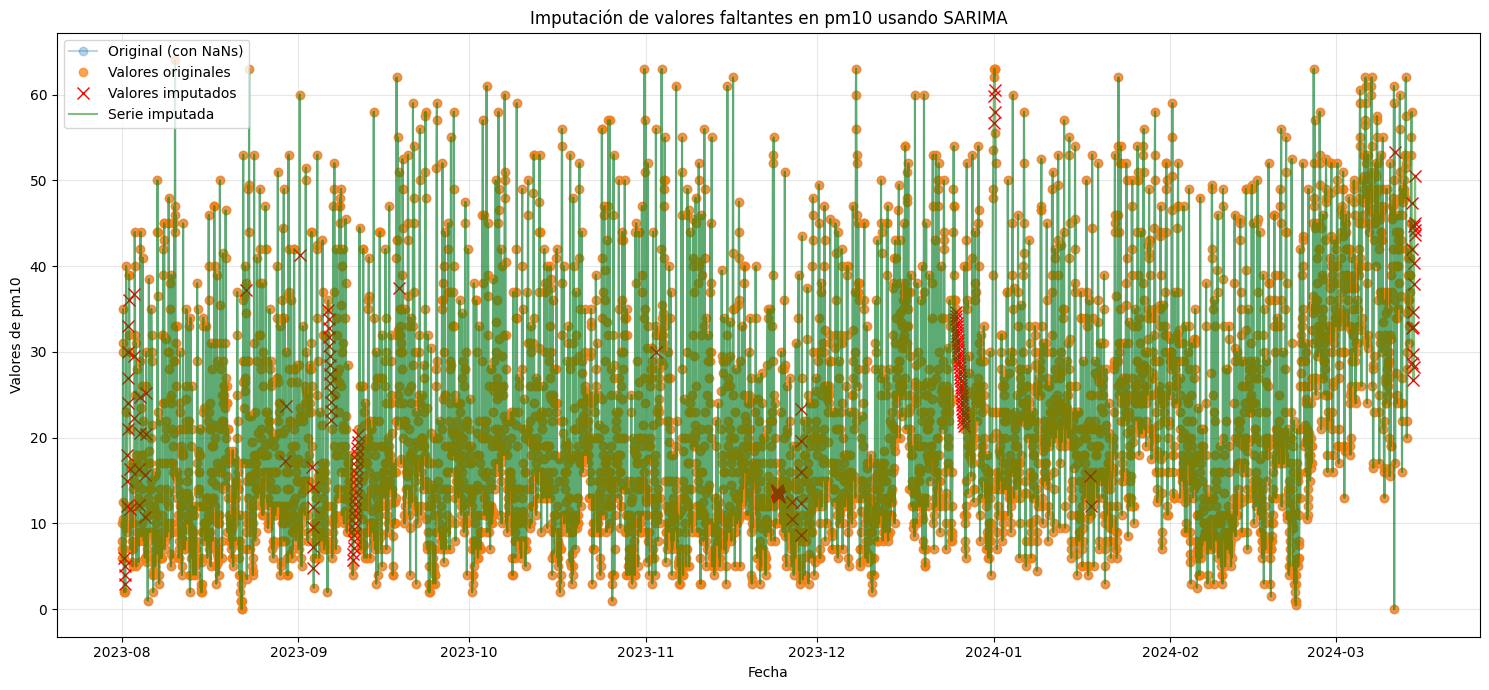

In [ ]:
import warnings

# Ocultar warnings específicos por mensaje o categoría:
warnings.filterwarnings("ignore", message="No supported index is available")
warnings.filterwarnings("ignore", message="A date index has been provided")
warnings.filterwarnings("ignore", category=FutureWarning)
DFP_AQ2_CPM10_RR_I = imputar_valores_sarima(DFP_AQ2_CPM10_RR,columna='pm10')

# 6.2 **RESULTADO SARIMA - DFP_AQ2_CPM10**

In [111]:
dtale.show(DFP_AQ2_CPM10_RR_I)

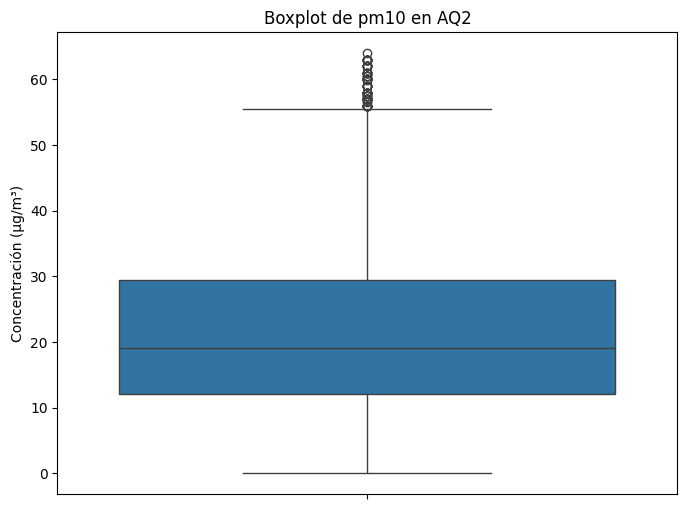

In [112]:
#Boxplot inicial de pm10 en DFP_AQ2
plt.figure(figsize=(8, 6))
sns.boxplot(y=DFP_AQ2_CPM10_RR_I['pm10'])
plt.title('Boxplot de pm10 en AQ2')
plt.ylabel('Concentración (µg/m³)')
plt.show()

In [86]:
def minmax_scale(df, column='pm10'):
    """
    Normaliza la columna 'pm' del DataFrame utilizando MinMaxScaler.
    
    Parámetros:
    -----------
    df : pandas.DataFrame
        DataFrame que tiene 'time_format' como índice y la columna a normalizar.
    column : str, default='pm10'
        Nombre de la columna a normalizar.
    
    Retorna:
    --------
    df_scaled : pandas.DataFrame
        DataFrame con la columna 'pm10' normalizada en el rango [0,1].
    """
    # Crear una copia para no modificar el DataFrame original
    df_scaled = df.copy()
    
    # Inicializar el MinMaxScaler
    scaler = MinMaxScaler()
    
    # Ajustar y transformar la columna 'pm10'
    df_scaled[column] = scaler.fit_transform(df_scaled[[column]])
    
    return df_scaled

In [110]:
#DFP_AQ2_CPM10_RR_I.to_csv("DFP_AQ2_CPM10_RR_I.csv", index=True)
#DFP_AQ2_CPM2_5_RR_I.to_csv("DFP_AQ2_CPM2_5_RR_I.csv", index=True)
DFP_AQ1_CPM10_RR_I.to_csv("DFP_AQ1_CPM10_RR_I.csv", index=True)
#DFP_AQ1_CPM2_5_RR_I.to_csv("DFP_AQ1_CPM2_5_RR_I.csv", index=True)

In [108]:
dtale.show(DFP_AQ1_CPM10_RR_I)

In [111]:
DFP_AQ1_CPM10_RR_IN = minmax_scale(DFP_AQ1_CPM10_RR_I, column='pm10')
DFP_AQ1_CPM10_RR_IN = minmax_scale(DFP_AQ1_CPM10_RR_I, column='pm2_5')
DFP_AQ1_CPM10_RR_IN = minmax_scale(DFP_AQ1_CPM10_RR_I, column='co')
DFP_AQ1_CPM10_RR_IN = minmax_scale(DFP_AQ1_CPM10_RR_I, column='humidity')
DFP_AQ1_CPM10_RR_IN = minmax_scale(DFP_AQ1_CPM10_RR_I, column='temperature')



In [ ]:
DFP_AQ2_CPM10_RR_IN = minmax_scale(DFP_AQ2_CPM10_RR_I, column='pm10')
DFP_AQ2_CPM2_5_RR_IN = minmax_scale(DFP_AQ2_CPM2_5_RR_I, column='pm2_5')
DFP_AQ1_CPM10_RR_IN = minmax_scale(DFP_AQ1_CPM10_RR_I, column='pm10')
DFP_AQ1_CPM2_5_RR_IN = minmax_scale(DFP_AQ1_CPM2_5_RR_I, column='pm2_5')

In [112]:
DFP_AQ1_CPM10_RR_IN.to_csv("DFP_AQ1_CPM10_RR_IN.csv", index=True)

In [ ]:
# Exportar cada DataFrame a un archivo CSV. El parámetro index=True se usa para incluir el índice (por ejemplo, 'time_format').
DFP_AQ2_CPM10_RR_IN.to_csv("DFP_AQ2_CPM10_RR_IN.csv", index=True)
DFP_AQ2_CPM2_5_RR_IN.to_csv("DFP_AQ2_CPM2_5_RR_IN.csv", index=True)
DFP_AQ1_CPM10_RR_IN.to_csv("DFP_AQ1_CPM10_RR_IN.csv", index=True)
DFP_AQ1_CPM2_5_RR_IN.to_csv("DFP_AQ1_CPM2_5_RR_IN.csv", index=True)


In [115]:
dtale.show(DFP_AQ2_CPM10_RR_IN)

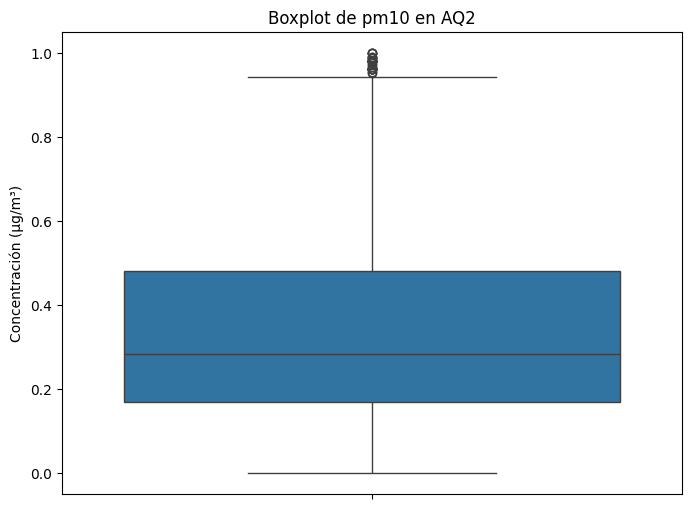

In [116]:
#Boxplot inicial de pm10 en DFP_AQ2
plt.figure(figsize=(8, 6))
sns.boxplot(y=DFP_AQ1_CPM2_5_RR_IN['pm2_5'])
plt.title('Boxplot de pm10 en AQ2')
plt.ylabel('Concentración (µg/m³)')
plt.show()

In [117]:
def lstm_prediction(df, target_column='pm10', n_steps=24, test_size=0.2, 
                    epochs=50, batch_size=32, plot=False):
    """
    Entrena un modelo LSTM para predecir la serie temporal de 'target_column'.
    
    Parámetros:
    -----------
    df : pandas.DataFrame
        DataFrame con la columna objetivo ya normalizada. Se asume que el índice es datetime.
    target_column : str, default='pm10'
        Nombre de la columna que se va a predecir.
    n_steps : int, default=24
        Número de pasos de tiempo (horas) que se usarán para predecir el siguiente valor.
    test_size : float, default=0.2
        Proporción de datos para el conjunto de test.
    epochs : int, default=50
        Número de épocas de entrenamiento.
    batch_size : int, default=32
        Tamaño del batch para el entrenamiento.
    plot : bool, default=False
        Si es True, se grafica la comparación entre las predicciones y los valores reales.
    
    Retorna:
    --------
    model : tf.keras.Model
        El modelo LSTM entrenado.
    predictions : numpy.array
        Predicciones en el conjunto de test.
    y_test : numpy.array
        Valores reales del conjunto de test.
    """
    
    # Extraer la serie de interés
    series = df[target_column].values
    
    # Crear secuencias para el modelo: 
    # Por cada posición i, se toman n_steps valores para predecir el valor en i + n_steps
    X, y = [], []
    for i in range(len(series) - n_steps):
        X.append(series[i:i+n_steps])
        y.append(series[i+n_steps])
    X, y = np.array(X), np.array(y)
    
    # Ajustar la forma de X para que sea [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    # Dividir en conjuntos de entrenamiento y test
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    # Definir el modelo LSTM
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # Entrenar el modelo
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    
    # Realizar predicciones sobre el conjunto de test
    predictions = model.predict(X_test)
    
    # Opcional: graficar las predicciones vs. los valores reales
    if plot:
        plt.figure(figsize=(12,6))
        plt.plot(y_test, label='Valores Reales', marker='o')
        plt.plot(predictions, label='Predicciones', marker='x')
        plt.title('Predicción con LSTM')
        plt.xlabel('Muestras del test')
        plt.ylabel(target_column)
        plt.legend()
        plt.show()
    
    return model, predictions, y_test

# Ejemplo de uso:
# model, preds, y_test = lstm_prediction(DFP_AQ2_CPM10_RR_I, target_column='pm10', n_steps=24, epochs=50, batch_size=32, plot=True)


In [118]:
def lstm_prediction_with_index(df, target_column='pm10', n_steps=24, test_size=0.2, 
                               epochs=50, batch_size=32, plot=False):
    """
    Entrena un modelo LSTM para predecir la serie temporal de 'target_column' y 
    retorna además el índice temporal correspondiente a los datos de test.
    
    Parámetros:
    -----------
    df : pandas.DataFrame
        DataFrame con la columna objetivo ya normalizada. Se asume que el índice es datetime.
    target_column : str, default='pm10'
        Nombre de la columna que se va a predecir.
    n_steps : int, default=24
        Número de pasos de tiempo (horas) que se usarán para predecir el siguiente valor.
    test_size : float, default=0.2
        Proporción de datos para el conjunto de test.
    epochs : int, default=50
        Número de épocas de entrenamiento.
    batch_size : int, default=32
        Tamaño del batch para el entrenamiento.
    plot : bool, default=False
        Si es True, se grafica la comparación entre las predicciones y los valores reales.
    
    Retorna:
    --------
    model : tf.keras.Model
        El modelo LSTM entrenado.
    predictions : numpy.array
        Predicciones en el conjunto de test.
    y_test : numpy.array
        Valores reales del conjunto de test.
    test_time_index : pandas.DatetimeIndex
        Índice temporal correspondiente a los datos de test.
    """
    
    # Extraer la serie de interés
    series = df[target_column].values
    
    # Crear secuencias para el modelo
    X, y = [], []
    for i in range(len(series) - n_steps):
        X.append(series[i:i+n_steps])
        y.append(series[i+n_steps])
    X, y = np.array(X), np.array(y)
    
    # Ajustar la forma de X para que sea [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    # Calcular el índice temporal asociado a las secuencias
    # Los tiempos corresponden a df.index[n_steps:]
    time_index = df.index[n_steps:]
    
    # Dividir en conjuntos de entrenamiento y test
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    test_time_index = time_index[split_idx:]
    
    # Definir el modelo LSTM
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # Entrenar el modelo
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    
    # Realizar predicciones sobre el conjunto de test
    predictions = model.predict(X_test)
    
    # Opcional: graficar las predicciones vs. los valores reales
    if plot:
        plt.figure(figsize=(12,6))
        # Usamos test_time_index para que se muestren las fechas en el eje x
        plt.plot(test_time_index, y_test, label='Valores Reales', marker='o')
        plt.plot(test_time_index, predictions, label='Predicciones Test', marker='x')
        plt.title('Predicción con LSTM')
        plt.xlabel('Tiempo')
        plt.ylabel(target_column)
        plt.legend()
        plt.show()
    
    return model, predictions, y_test, test_time_index


Epoch 1/50


2025-04-04 12:21:51.115028: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/air_quality/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 396.0576
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 81.1149
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 80.2532
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 74.3150
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 70.9440
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 75.6769
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 67.9974
Epoch 8/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 73.6427
Epoch 9/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 76.9706
Epoch 10/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 65.1327
Epoch 11/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 70.3453
Epoch 12/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 68.9040
Epoch 13/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 72.4645
Epoch 14/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 68.7385
Epoch 15/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step 

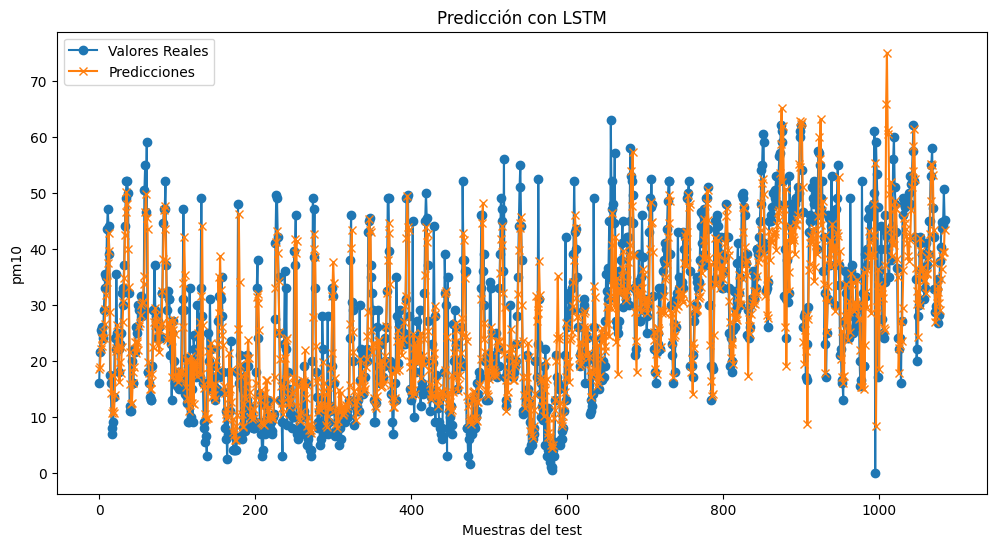

(<Sequential name=sequential, built=True>,
 array([[18.543509],
        [18.938606],
        [22.047142],
        ...,
        [39.425865],
        [39.44219 ],
        [43.309017]], dtype=float32),
 array([16.        , 21.5       , 25.5       , ..., 44.2003169 ,
        50.56535246, 45.07341718]))

In [119]:
lstm_prediction(DFP_AQ2_CPM10_RR_I,target_column="pm10",plot=True)

Epoch 1/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0716
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0274
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0240
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0219
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0204
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0197
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0192
Epoch 8/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0194
Epoch 9/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0194
Epoch 10/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0181
Epoch 11/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0182
Epoch 12/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0200
Epoch 13/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0179
Epoch 14/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0186
Epoch 15/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - lo

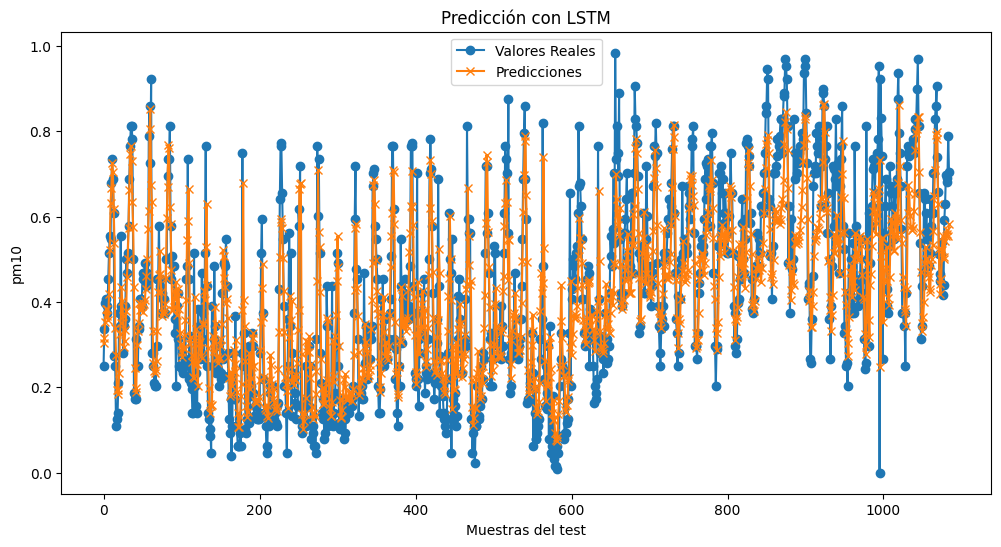

(<Sequential name=sequential_1, built=True>,
 array([[0.3043444 ],
        [0.31589994],
        [0.3527515 ],
        ...,
        [0.5594859 ],
        [0.55428195],
        [0.58267415]], dtype=float32),
 array([0.25      , 0.3359375 , 0.3984375 , ..., 0.69062995, 0.79008363,
        0.70427214]))

In [120]:
lstm_prediction(DFP_AQ2_CPM10_RR_IN,target_column="pm10",plot=True)

-----------------


In [ ]:
model, preds, y_test = lstm_prediction(DFP_AQ2_CPM10_RR_IN, target_column="pm10", plot=True)


In [122]:
def forecast_future(model, initial_sequence, n_steps, forecast_steps):
    """
    Realiza un pronóstico iterativo a partir de una secuencia inicial utilizando el modelo LSTM.
    
    Parámetros:
    -----------
    model : tf.keras.Model
        Modelo LSTM entrenado.
    initial_sequence : numpy.array
        Arreglo 1D de longitud n_steps con los últimos valores conocidos.
    n_steps : int
        Tamaño de la ventana de entrada (número de pasos de tiempo).
    forecast_steps : int
        Número de pasos a predecir.
    
    Retorna:
    --------
    predictions : list
        Lista con las predicciones para los próximos forecast_steps.
    """
    predictions = []
    current_seq = initial_sequence.copy()
    for i in range(forecast_steps):
        # La entrada debe tener forma (1, n_steps, 1)
        input_seq = current_seq.reshape(1, n_steps, 1)
        next_val = model.predict(input_seq, verbose=0)
        next_val = next_val[0, 0]  # Extraer el valor
        predictions.append(next_val)
        # Actualizar la secuencia: se elimina el primer valor y se añade el predicho al final
        current_seq = np.append(current_seq[1:], next_val)
    return predictions

In [123]:
def forecast_future_dates(model, df, target_column='pm10', n_steps=24, forecast_steps=24):
    """
    Genera un pronóstico para un número específico de pasos en el futuro a partir del modelo LSTM.
    Se asume que df es un DataFrame de Pandas con un índice datetime (por ejemplo, 'time_format') 
    y que la columna target_column ya está normalizada (por ejemplo, con MinMaxScaler).
    
    Parámetros:
    -----------
    model : tf.keras.Model
        Modelo LSTM entrenado.
    df : pandas.DataFrame
        DataFrame con el índice temporal y la columna objetivo.
    target_column : str, default='pm10'
        Columna que se va a predecir.
    n_steps : int, default=24
        Número de pasos de tiempo (ventana) usados para la entrada.
    forecast_steps : int, default=24
        Número de pasos (horas) a predecir.
    
    Retorna:
    --------
    forecast_df : pandas.DataFrame
        DataFrame con el pronóstico futuro. El índice contiene las fechas (con frecuencia horaria)
        y una columna con los valores predichos.
    """
    # Asegurarse de que el DataFrame esté ordenado por el índice
    df_sorted = df.sort_index()
    
    # Extraer la secuencia inicial: los últimos n_steps valores conocidos de la columna target
    initial_sequence = df_sorted[target_column].values[-n_steps:]
    
    # Realizar el pronóstico iterativo
    predictions = forecast_future(model, initial_sequence, n_steps, forecast_steps)
    
    # Crear un índice de fechas para las predicciones. Se asume frecuencia horaria.
    last_date = df_sorted.index[-1]
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), periods=forecast_steps, freq='H')
    
    forecast_df = pd.DataFrame({f'predicted_{target_column}': predictions}, index=forecast_dates)
    
    return forecast_df



Epoch 1/80


/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/air_quality/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 6535586.0000
Epoch 2/80
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 95510.7812
Epoch 3/80
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 46702.0938
Epoch 4/80
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 83672.5469
Epoch 5/80
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 15162.6768
Epoch 6/80
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 3405.0862
Epoch 7/80
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 4372.4912
Epoch 8/80
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 7806.9014
Epoch 9/80
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 4393.5977
Epoch 10/80
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 193115136.0000
Epoch 11/80
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 497895.0938
Epoch 12/80
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 24352.5859
Epoch 13/80
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 24871.4277
Epoch 14/80
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 24645.

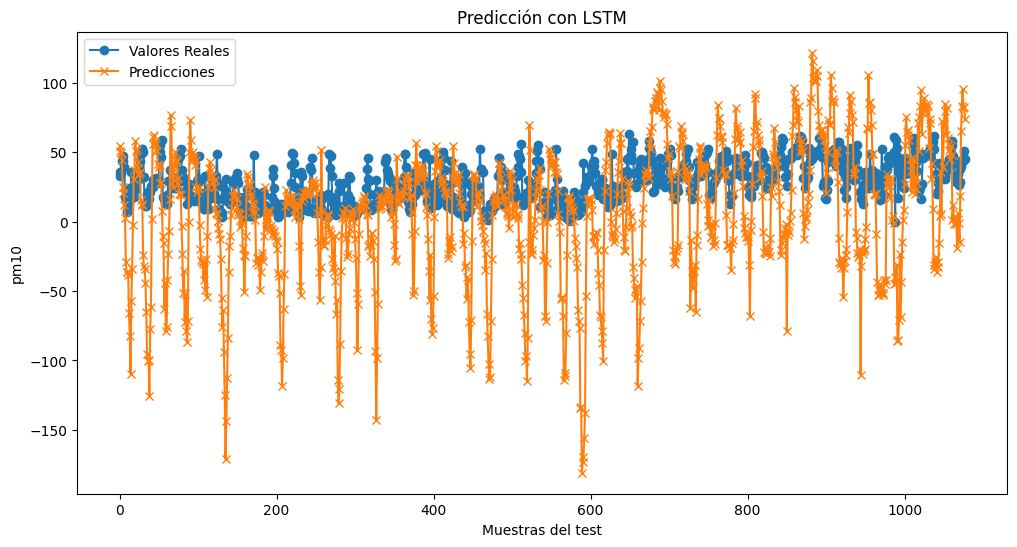

                     predicted_pm10
2024-03-15 01:00:00       52.893047
2024-03-15 02:00:00       48.750435
2024-03-15 03:00:00       61.934364
2024-03-15 04:00:00       43.635754
2024-03-15 05:00:00       28.088745
2024-03-15 06:00:00      -12.239070
2024-03-15 07:00:00      -41.203087
2024-03-15 08:00:00      -45.687553
2024-03-15 09:00:00      -47.004829
2024-03-15 10:00:00      -45.444317
2024-03-15 11:00:00      -45.806889
2024-03-15 12:00:00      -45.817810
2024-03-15 13:00:00      -43.138134
2024-03-15 14:00:00      -55.986492
2024-03-15 15:00:00      -43.344379
2024-03-15 16:00:00      -42.498135
2024-03-15 17:00:00      -37.082012
2024-03-15 18:00:00      -29.637444
2024-03-15 19:00:00      -26.304199
2024-03-15 20:00:00       -8.916793
2024-03-15 21:00:00       34.506508
2024-03-15 22:00:00       53.092213
2024-03-15 23:00:00       50.811039
2024-03-16 00:00:00       39.237385
2024-03-16 01:00:00       45.644657
2024-03-16 02:00:00       29.292891
2024-03-16 03:00:00       -1

In [ ]:

# Modelo entrenado con DFP_AQ2_CPM10_RR_IN
model, preds, y_test = lstm_prediction(DFP_AQ2_CPM10_RR_I, target_column='pm10', n_steps=24, epochs=50, batch_size=32, plot=True)
#
# Para pronosticar, por ejemplo, las próximas 48 horas:
forecast_df = forecast_future_dates(model, DFP_AQ2_CPM10_RR_I, target_column='pm10', n_steps=24, forecast_steps=48)
print(forecast_df)

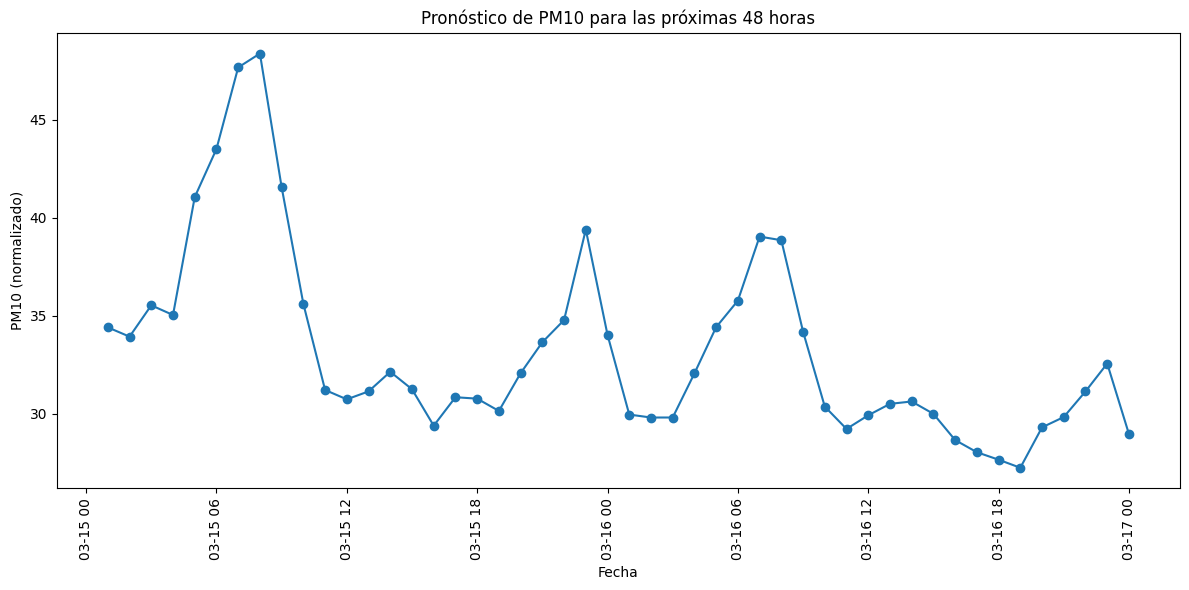

In [126]:
plt.figure(figsize=(12,6))
plt.plot(forecast_df.index, forecast_df['predicted_pm10'], marker='o', linestyle='-')
plt.title("Pronóstico de PM10 para las próximas 48 horas")
plt.xlabel("Fecha")
plt.ylabel("PM10 (normalizado)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


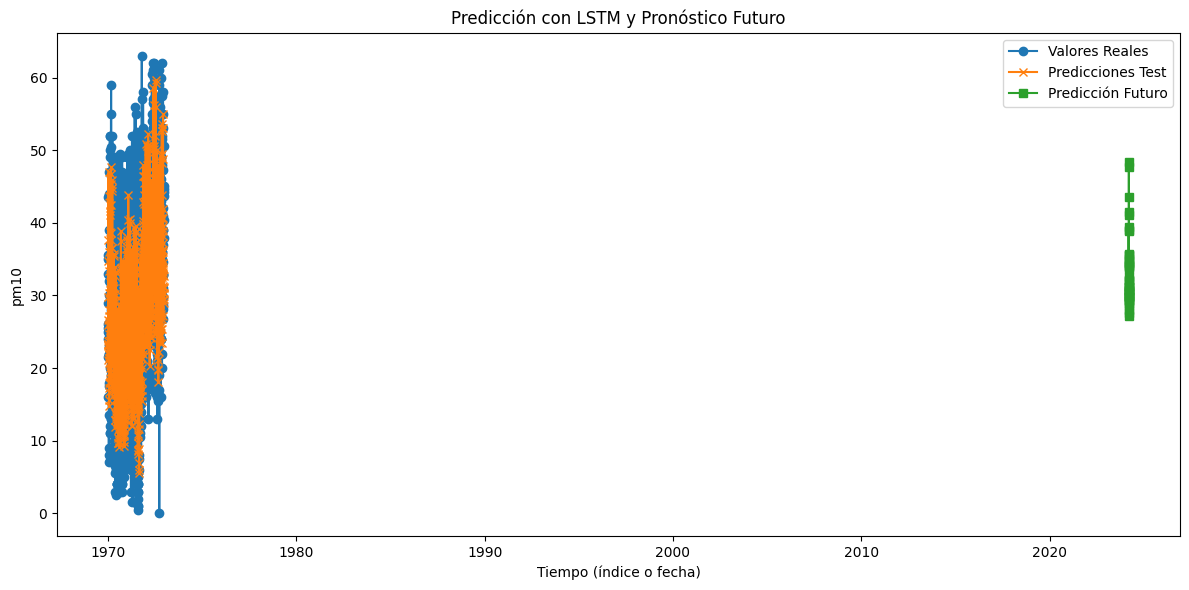

In [131]:
plt.figure(figsize=(12,6))

# Graficar los valores reales y las predicciones del test (índice de muestras)
plt.plot(y_test, label='Valores Reales', marker='o')
plt.plot(preds, label='Predicciones Test', marker='x')

# Graficar la predicción futura a partir de forecast_df
# Se asume que forecast_df tiene un índice datetime y una columna llamada, por ejemplo, 'predicted_pm10'
plt.plot(forecast_df.index, forecast_df[f'predicted_pm10'], label='Predicción Futuro', marker='s')

plt.title('Predicción con LSTM y Pronóstico Futuro')
plt.xlabel('Tiempo (índice o fecha)')
plt.ylabel("pm10")
plt.legend()
plt.tight_layout()
plt.show()

In [133]:
print(preds)

[[21.102423]
 [23.693182]
 [23.25202 ]
 ...
 [29.478827]
 [31.221869]
 [32.643562]]


Epoch 1/50


/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/air_quality/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 188.5440
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 101.6026
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 84.4427
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 77.4311
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 119.3805
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 87.0451
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 88.0067
Epoch 8/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 80.2663
Epoch 9/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 94.5279
Epoch 10/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 118.8570
Epoch 11/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 284.1145
Epoch 12/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 150.9711
Epoch 13/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 138.6920
Epoch 14/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 133.1785
Epoch 15/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1

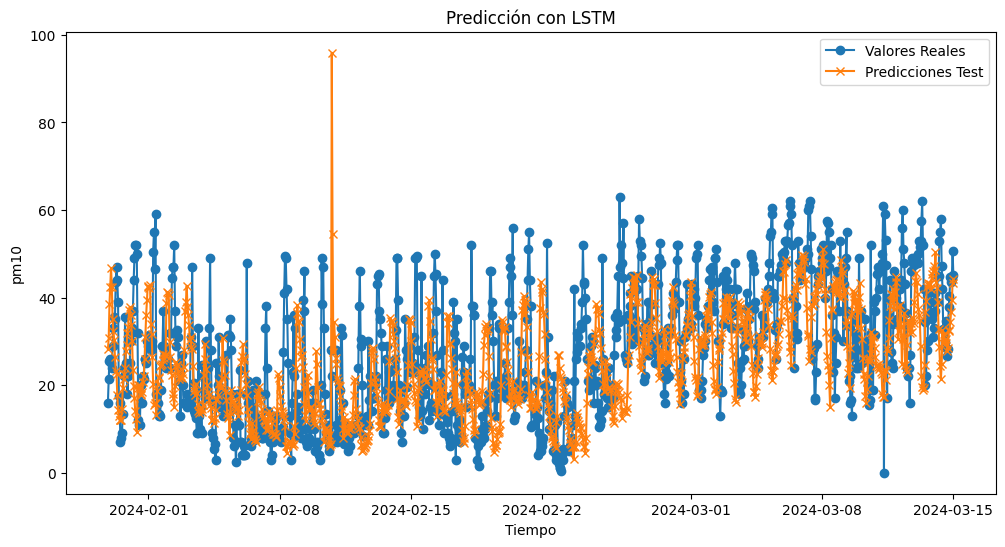

In [137]:
model, preds, y_test, test_time = lstm_prediction_with_index(DFP_AQ2_CPM10_RR_I, 
                                                              target_column='pm10', 
                                                              n_steps=24, 
                                                              epochs=50, 
                                                              batch_size=32, 
                                                              plot=True)

In [144]:
forecast_df = forecast_future_dates(model, DFP_AQ2_CPM10_RR_I, 
                                    target_column='pm10', 
                                    n_steps=24, 
                                    forecast_steps=60) 

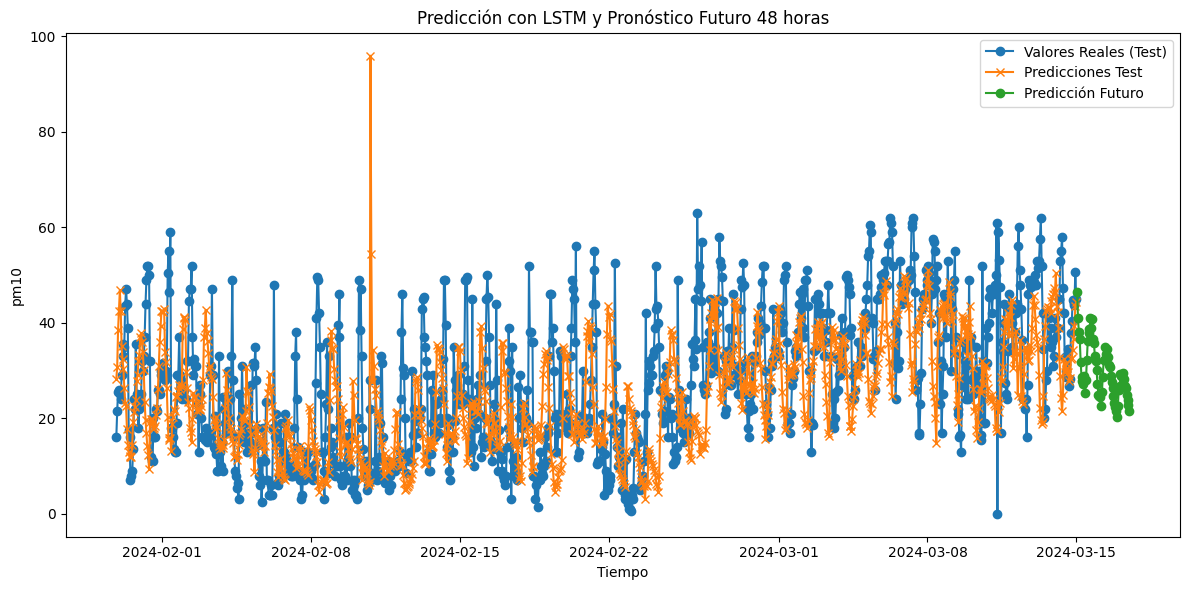

In [147]:
plt.figure(figsize=(12,6))

# Graficar los datos de test con su índice temporal
plt.plot(test_time, y_test, label='Valores Reales (Test)', marker='o')
plt.plot(test_time, preds, label='Predicciones Test', marker='x')

# Graficar la predicción futura
plt.plot(forecast_df.index, forecast_df['predicted_pm10'], label='Predicción Futuro',marker='o')

plt.title('Predicción con LSTM y Pronóstico Futuro 48 horas')
plt.xlabel('Tiempo')
plt.ylabel('pm10')
plt.legend()
plt.tight_layout()
plt.show()

In [146]:
print(forecast_df)

                     predicted_pm10
2024-03-15 01:00:00       46.459167
2024-03-15 02:00:00       40.992092
2024-03-15 03:00:00       37.986488
2024-03-15 04:00:00       36.683376
2024-03-15 05:00:00       31.786715
2024-03-15 06:00:00       28.714340
2024-03-15 07:00:00       27.767725
2024-03-15 08:00:00       27.136396
2024-03-15 09:00:00       28.910643
2024-03-15 10:00:00       25.200644
2024-03-15 11:00:00       27.958624
2024-03-15 12:00:00       32.156944
2024-03-15 13:00:00       36.217358
2024-03-15 14:00:00       38.662659
2024-03-15 15:00:00       37.885719
2024-03-15 16:00:00       40.991920
2024-03-15 17:00:00       39.009342
2024-03-15 18:00:00       40.801826
2024-03-15 19:00:00       36.563473
2024-03-15 20:00:00       35.780769
2024-03-15 21:00:00       33.126167
2024-03-15 22:00:00       32.049046
2024-03-15 23:00:00       30.015949
2024-03-16 00:00:00       27.247580
2024-03-16 01:00:00       24.836723
2024-03-16 02:00:00       24.709511
2024-03-16 03:00:00       24

In [ ]:
predictions_flat = preds.flatten()  # preds es lo que retorna la función lstm_prediction
y_test_flat = y_test.flatten()        # y_test es lo que retorna la función lstm_prediction

# Calcular R² y MAE
r2 = r2_score(y_test_flat, predictions_flat)
mae = mean_absolute_error(y_test_flat, predictions_flat)

print(f"R²: {r2:.4f}") #0.9
print(f"MAE: {mae:.4f}") 

R²: -10.1379
MAE: 36.9155


-------------


In [ ]:

# Modelo entrenado con DFP_AQ2_CPM10_RR_IN
model, preds, y_test = lstm_prediction(DFP_AQ2_CPM10_RR_I, target_column='pm10', n_steps=24, epochs=50, batch_size=32, plot=True)
#
# Para pronosticar, por ejemplo, las próximas 48 horas:
forecast_df = forecast_future_dates(model, DFP_AQ2_CPM10_RR_I, target_column='pm10', n_steps=24, forecast_steps=48)
print(forecast_df)

In [157]:
def lstm_prediction_improved(df, target_column='pm10', n_steps=24, test_size=0.2, 
                             epochs=100, batch_size=32, plot=False):
    # Extraer la serie
    series = df[target_column].values

    # Crear secuencias
    X, y = [], []
    for i in range(len(series) - n_steps):
        X.append(series[i:i+n_steps])
        y.append(series[i+n_steps])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    # Índice temporal para test
    time_index = df.index[n_steps:]
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    test_time_index = time_index[split_idx:]
    
    # Definir modelo LSTM mejorado
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    
    # Entrenar con EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
              validation_split=0.1, callbacks=[early_stop], verbose=1)
    
    # Predecir en test
    predictions = model.predict(X_test)
    
    if plot:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12,6))
        plt.plot(test_time_index, y_test, label='Valores Reales', marker='o')
        plt.plot(test_time_index, predictions, label='Predicciones Test', marker='x')
        plt.title('Predicción con LSTM Mejorado')
        plt.xlabel('Tiempo')
        plt.ylabel(target_column)
        plt.legend()
        plt.show()
    
    return model, predictions, y_test, test_time_index


/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/air_quality/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 242.8777 - val_loss: 86.8953
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 109.1790 - val_loss: 78.9464
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 99.6943 - val_loss: 119.2854
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 97.5660 - val_loss: 82.4494
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 84.7904 - val_loss: 82.9372
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 97.2573 - val_loss: 81.3490
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 87.7769 - val_loss: 84.4932
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 87.4594 - val_loss: 93.1425
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 85.0339 - val_loss: 106.9831
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 81.6154 - val_loss: 84.7942
Epoch 11/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 83.6395 - val_loss: 89.1069
Epo

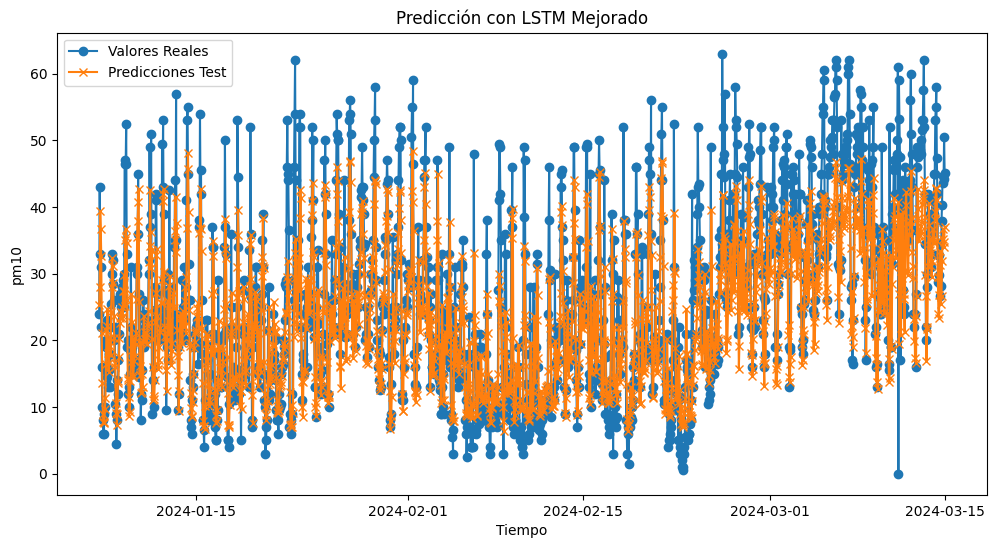

In [160]:
model, preds, y_test, _ = lstm_prediction_improved(DFP_AQ2_CPM10_RR_I, 
                                                   target_column='pm10', 
                                                   n_steps=24,
                                                   test_size=0.3, 
                                                   epochs=100, 
                                                   batch_size=32, 
                                                   plot=True)


In [161]:
predictions_flat = preds.flatten()  # preds es lo que retorna la función lstm_prediction
y_test_flat = y_test.flatten()        # y_test es lo que retorna la función lstm_prediction

# Calcular R² y MAE
r2 = r2_score(y_test_flat, predictions_flat)
mae = mean_absolute_error(y_test_flat, predictions_flat)

print(f"R²: {r2:.4f}") #0.9
print(f"MAE: {mae:.4f}") 

R²: 0.6451
MAE: 6.1352


In [165]:

y_test_flat = y_test.flatten()
preds_flat = preds.flatten()

mape_manual = np.mean(np.abs((y_test_flat - preds_flat) / y_test_flat))
print(f"MAPE (manual): {mape_manual:.2%}")


MAPE (manual): inf%


/tmp/ipykernel_858290/1589499598.py:4: RuntimeWarning:

divide by zero encountered in divide

